In [1]:
%reset
%load_ext autoreload
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import collections 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import seaborn as sns

from kde_spikephase import kde_spikephase_estimator_forarray
from mdl_eval_tools import bayes,kl,logloss
from pprint import pprint
from rayleigh_pr import rayleigh_pr
from scipy.stats import sem
from sklearn.model_selection import GridSearchCV 
from sklearn.neighbors import KernelDensity
from tqdm import tqdm

sns.set(font_scale=2,style='whitegrid')

pd.options.display.max_colwidth = 100

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Compare rhythmic cshort models over time

In [2]:
def grab_probs_and_data(datapath,rh_folders,cell_id,fold,filename_probs,filename_data):
    """
    datapath: 'RESULTS/PHASE_HIST_MODELS_all_realcells/intlogoddsCompleteSinglePredMdls940/'
    rh_folders: os.listdir(datapath)
    cell_id: 'LH16_08_22_14_D29_theta_correct_odorblock2TETSPK53c'
    fold: scalar
    filename_probs: 'probs_models_test.csv'
    filename_data: 'test_data.csv'
    """
    
    test = []
    ptest=[]
    
    for f in rh_folders:
    
        rh_path = os.path.join(datapath, f)
        rh_path_to_cell = rh_path + '/folds/' + str(fold) + '/single_neuron/' + cell_id
#         rh_path_to_cell = rh_path + '/folds/' + str(fold) + '/' + cell_id
        
        rhythm = f.split('phase')[0]

        #just read a few columns from the test df
#         testtmp = pd.read_csv(os.path.join(rh_path_to_cell, filename_data), usecols = ['spikes','trial_labels'])


        testtmp = pd.read_csv(os.path.join(rh_path_to_cell, filename_data), usecols = ['spikes','phase','trial_labels'])
        testtmp['rhythm'] = np.repeat(rhythm, testtmp.shape[0])
        testtmp['cell_id'] = np.repeat(cell_id, testtmp.shape[0])

        test.append(testtmp)

        ptesttmp = pd.read_csv(os.path.join(rh_path_to_cell, filename_probs))
        ptesttmp['rhythm'] = np.repeat(rhythm, ptesttmp.shape[0])
        ptesttmp['cell_id'] = np.repeat(cell_id, ptesttmp.shape[0])
        ptesttmp['trial_labels'] = testtmp['trial_labels'].values

        ptest.append(ptesttmp)
    
    ptest = pd.concat(ptest)
    test = pd.concat(test)
    
    return ptest, test

In [3]:
from process_lfps import create_data_segments

def compute_logloss_deltas(ptest, test, window_size, window_slide, model_subset, rhythm_subset):
    """
    ptest: df obtained from function grab_probs_and_data.py
    test: df obtained from function grab_probs_and_data.py
    window_size: scalar [ms], e.g. 50ms windows
    window_slide: scalar [ms], e.g. same size as window for no overlap at all
    model_subset: list of model names, e.g. ['cshort', 'phase']
    rhythm_subset: list of rhythm names you want to grab models for, ['theta','beta','lowgamma', 'highgamma']
    """
    
    trial_labels = list(set(test['trial_labels'].to_list()))
    rhythm_labels = list(set(test['rhythm'].to_list()))
    
    # break the trials into windows
    gather_dfs = []
    for rhythm in rhythm_labels:

        for trial in trial_labels:

            subtest = test[(test['trial_labels']==trial) & (test['rhythm'] == rhythm)]
            subptest = ptest[(ptest['trial_labels']==trial) & (ptest['rhythm'] == rhythm)]

            tmp = create_data_segments(subtest['spikes'].values,window_size,window_slide,['spikes','win_labels'])
            tmp['trial_labels'] = np.repeat(trial,tmp.shape[0])
            tmp['rhythm'] = np.repeat(rhythm,tmp.shape[0])

            gather_dfs.append(tmp)

    windowed_data = pd.concat(gather_dfs)   
    
    #since the windowed data drops some ms, make sure to drop the corresponding ms for each trial in test/ptest dfs
    len_trial = test[(test['trial_labels'] == trial_labels[0]) & (test['rhythm'] == rhythm)].shape[0]
    windowed_len_trial = windowed_data[(windowed_data['trial_labels'] == trial_labels[0]) & (windowed_data['rhythm'] == rhythm)].shape[0]

    rows_to_drop = len_trial - windowed_len_trial
    gather_test = []
    gather_ptest = []
    for rhythm in rhythm_labels:

        for trial in trial_labels:

            subtest = test[(test['trial_labels']==trial) & (test['rhythm'] == rhythm)]
            subptest = ptest[(ptest['trial_labels']==trial) & (ptest['rhythm'] == rhythm)]
            subwin = windowed_data[(windowed_data['trial_labels'] == trial) & (windowed_data['rhythm'] == rhythm)]

            n = subtest.drop(index=subtest.tail(rows_to_drop).index)
            m = subptest.drop(index=subptest.tail(rows_to_drop).index)

            n['window_labels'] = subwin['win_labels'].values
            m['window_labels'] = subwin['win_labels'].values

            gather_test.append(n)
            gather_ptest.append(m)

    shaved_test = pd.concat(gather_test)
    shaved_ptest = pd.concat(gather_ptest)  

    window_labels = list(set(shaved_test['window_labels'].to_list()))
    
    # now compute the log loss delta between models per window
    gather_ptest = []
    gather_test = []
    for rhythm in rhythm_subset: 
        for trial in trial_labels: 
            subptest = shaved_ptest[(shaved_ptest['rhythm'] == rhythm) & (shaved_ptest['trial_labels'] == trial)]
            subtest = shaved_test[(shaved_test['rhythm'] == rhythm) & (shaved_test['trial_labels'] == trial)]

            subptest['spikes'] = subtest['spikes']
            subptest['phases'] = subtest['phase']

            for model in model_subset: 


                _, _, subptest['logloss_'+model] = logloss(subptest['p_'+model].values, subtest['spikes'].values)


                gather_ptest.append(subptest)

    ll_ptest = pd.concat(gather_ptest)

    
    return ll_ptest

In [127]:
# cell_path = '/Volumes/Sula/PhaseModelsOverTime/data/python_spkphaseOdorsamp_multirhythm/'
# cell_labels = os.listdir(cell_path)
# cell_labels = [c for c in cell_labels if not c.startswith('.')]

# cell_path = 'RESULTS/PHASE_HIST_MODELS_highvapproach_all_realcells/starintlogoddsCompleteSinglePredMdls177/theta_250ms/folds/0/'
# cell_labels = ['LH16_D22_ctxtsig_odorblock2_TETSPK09a.mat',
#                'LH16_D29_ctxtsig_odorblock1_TETSPK53c.mat',
#                'LH16_08_08_14_D22_theta_correct_odorblock2TETSPK09a.mat'
#               ]
# cell_labels = os.listdir(cell_path)
# cell_labels = [c for c in cell_labels if not c.startswith('.')]

datapath = 'RESULTS/PHASE_HIST_MODELS_all_realcells/intlogoddsCompleteSinglePredMdls940/'
# datapath = 'RESULTS/PHASE_HIST_MODELS_highvapproach_all_realcells/starintlogoddsCompleteSinglePredMdls177/'

rh_folders = os.listdir(datapath)

# cell_labels = ['LH16_08_22_14_D29_theta_correct_odorblock2TETSPK53c',
#                'LH9_10_10_13_D10_theta_correct_odorblock2TETSPK13a',
#                'LH16_08_08_14_D22_theta_correct_odorblock2TETSPK09a'
#               ]

cell_labels = ['LH16_07_09_14_D09_theta_correct_odorblock1TETSPK37c']

# cell_labels = list(cell_labels)

window_size = 50
window_slide = 50
model_subset = ['cshort','hshort']
rhythm_subset = ['theta','lowgamma']
# rhythm_subset = ['theta_250ms','lowgamma_250ms']

loss_delta_tmp = []

for cell_id in tqdm(cell_labels):
    
    for fold in range(20): 


        ptest, test = grab_probs_and_data(datapath,rh_folders,cell_id,fold,'probs_models_test.csv','test_data.csv')

        
        ll_ptest = compute_logloss_deltas(ptest, test, window_size, window_slide, model_subset, rhythm_subset)

        grouped_ptest = ll_ptest.groupby(['rhythm','trial_labels','window_labels']).mean()[['logloss_cshort','logloss_hshort']].reset_index()
        grouped_ptest = ll_ptest.groupby(['rhythm','window_labels']).mean()[['logloss_cshort','logloss_hshort']].reset_index()


        subthetaloss = grouped_ptest[grouped_ptest['rhythm'] == 'theta']
        sublowgammaloss = grouped_ptest[grouped_ptest['rhythm'] == 'lowgamma']
        
#         subthetaloss = grouped_ptest[grouped_ptest['rhythm'] == 'theta_250ms']
#         sublowgammaloss = grouped_ptest[grouped_ptest['rhythm'] == 'lowgamma_250ms']
        
        delta_theta_lowgamma = subthetaloss['logloss_cshort'].values - sublowgammaloss['logloss_cshort'].values
        delta_theta_hshort = subthetaloss['logloss_cshort'].values - subthetaloss['logloss_hshort'].values
        delta_lowgamma_hshort = sublowgammaloss['logloss_cshort'].values - sublowgammaloss['logloss_hshort'].values

        tmp = {'cell_id': np.repeat(cell_id,subthetaloss.shape[0]),
               'delta_logloss_theta_minus_lowgamma': delta_theta_lowgamma,
               'delta_logloss_theta_minus_hshort': delta_theta_hshort,
               'delta_logloss_lowgamma_minus_hshort': delta_lowgamma_hshort,
               'window_labels': sublowgammaloss['window_labels'].to_list(),
               'fold': np.repeat(fold,subthetaloss.shape[0])}

        loss_delta_tmp.append(pd.DataFrame(tmp))
    
loss_delta_df = pd.concat(loss_delta_tmp)
    

  0%|                                                     | 0/1 [00:00<?, ?it/s]/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_1437/487413070.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subptest['spikes'] = subtest['spikes']
/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_1437/487413070.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subptest['phases'] = subtest['phase']
/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_1437/487413070.py:76: SettingWithCopyWarni

### ordering the population

In [4]:
df_odor = pd.read_csv('loss_delta_theta_lowgamma_odor_allcells.csv')
df_approach = pd.read_csv('loss_delta_theta_lowgamma_approach_allcells.csv')

In [5]:
df_odor.shape,df_approach.shape

((67000, 10), (67000, 8))

Find the core identities so you can map the correct cells across dfs

In [6]:
cell_labels = list(set(df_approach['cell_id'].to_list()))
unique_ids = []
gather_dfs = []
for cell_id in cell_labels: 
    
    #find rat name
    ratname = cell_id.split('_')[0]
    
    #find session name 
    sessionname = cell_id.split('_')[1]
    
    #find block id
    blockname = cell_id.split('_')[3]
    
    #find unit ids
#     unitname = cell_id.split('_')[-1].split('.mat')[0]
    unitname = cell_id.split('TETSPK')[1].split('.mat')[0]
    
    unique = ratname + '_' + sessionname + '_' + blockname + '_' + unitname
    unique_ids.append(unique)
    
    index = df_approach.loc[df_approach['cell_id']==cell_id]
    index['core_cell_id'] = unique
    
    gather_dfs.append(index)
    
unique_ids = set(unique_ids)  
df_approach_core = pd.concat(gather_dfs)


/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_650/22230630.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  index['core_cell_id'] = unique


In [7]:
cell_labels = list(set(df_odor['cell_id'].to_list()))
unique_ids = []
gather_dfs = []
for cell_id in cell_labels: 
    
    #find rat name
    ratname = cell_id.split('_')[0]
    
    #find session name 
    sessionname = cell_id.split('_')[4]
    if sessionname[1] == '0':
        sessionname1 = sessionname.split('0')[0]
        sessionname2 = sessionname.split('0')[1]
        sessionname = sessionname1 + sessionname2
    
    #find block id
    tmp_blockname = cell_id.split('TET')[0]
    blockname = tmp_blockname.split('_')[-1]
    #find unit ids
    unitname = cell_id.split('TETSPK')[1]
    
    unique = ratname + '_' + sessionname + '_' + blockname + '_' + unitname
    unique_ids.append(unique)
    
    index = df_odor.loc[df_odor['cell_id']==cell_id]
    index['core_cell_id'] = unique
    
    gather_dfs.append(index)
    
unique_ids = set(unique_ids)  
df_odor_core = pd.concat(gather_dfs)

/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_650/550639591.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  index['core_cell_id'] = unique


Choose the model comparison you want to order the heatmaps by

In [8]:
delta_to_orderBy = 'delta_logloss_theta_minus_lowgamma'

In [9]:
tmp = df_odor_core.reset_index()
tmp2 = tmp.groupby(['core_cell_id','window_labels']).median()[delta_to_orderBy].reset_index()

In [10]:
tmp2

core_cell_id  window_labels  \
0     LH16_D10_odorblock1_21k              0   
1     LH16_D10_odorblock1_21k              1   
2     LH16_D10_odorblock1_21k              2   
3     LH16_D10_odorblock1_21k              3   
4     LH16_D10_odorblock1_21k              4   
...                       ...            ...   
3345    LH9_D9_odorblock2_53b             20   
3346    LH9_D9_odorblock2_53b             21   
3347    LH9_D9_odorblock2_53b             22   
3348    LH9_D9_odorblock2_53b             23   
3349    LH9_D9_odorblock2_53b             24   

      delta_logloss_theta_minus_lowgamma  
0                              -0.003079  
1                              -0.001255  
2                               0.003540  
3                              -0.001697  
4                              -0.002806  
...                                  ...  
3345                            0.000381  
3346                           -0.002432  
3347                           -0.004264  
3348                           -0.002099  
3349                           -0.001605  

[3350 rows x 3 columns]

In [11]:
cell_labels = list(set(df_odor_core['core_cell_id'].to_list()))

In [12]:
gather_dfs = []
for cell in cell_labels:
    
    subcell = tmp2[tmp2['core_cell_id'] == cell]
    
    win_at_max = np.where(subcell[delta_to_orderBy].values == max(subcell[delta_to_orderBy].values))
    win_at_max = win_at_max[0][0]
    
    subcell['win_at_max'] = np.repeat(win_at_max,subcell.shape[0])
    
    gather_dfs.append(subcell)
    
winmax_df = pd.concat(gather_dfs)
    

/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_650/1798255765.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subcell['win_at_max'] = np.repeat(win_at_max,subcell.shape[0])


In [13]:
winmax_df

core_cell_id  window_labels  \
600  LH16_D23_odorblock2_09c              0   
601  LH16_D23_odorblock2_09c              1   
602  LH16_D23_odorblock2_09c              2   
603  LH16_D23_odorblock2_09c              3   
604  LH16_D23_odorblock2_09c              4   
..                       ...            ...   
720  LH16_D25_odorblock1_09a             20   
721  LH16_D25_odorblock1_09a             21   
722  LH16_D25_odorblock1_09a             22   
723  LH16_D25_odorblock1_09a             23   
724  LH16_D25_odorblock1_09a             24   

     delta_logloss_theta_minus_lowgamma  win_at_max  
600                           -0.010097           3  
601                           -0.011116           3  
602                            0.002357           3  
603                            0.008492           3  
604                           -0.007957           3  
..                                  ...         ...  
720                            0.003176          23  
721                            0.002175          23  
722                           -0.000190          23  
723                            0.003505          23  
724                           -0.001314          23  

[3350 rows x 4 columns]

In [14]:
#order the dfs with max windows by the max window
window_labels = list(set(winmax_df['window_labels'].to_list()))

last_cell_order = 0
merged_ranking = []
for window in window_labels:
    
    submaxwin = winmax_df[(winmax_df['win_at_max'] == window) & (winmax_df['window_labels'] == window)]
    
    tmp_df = submaxwin.sort_values(by=delta_to_orderBy,ascending=False)

    tmp_df['ordering'] = (np.arange(0,tmp_df.shape[0]))+(last_cell_order+1)

    last_cell_order = tmp_df['ordering'].tail(1).values[0]
    
    merged_ranking.append(tmp_df)

merged_ranking = pd.concat(merged_ranking)
    

In [15]:
merged_ranking

core_cell_id  window_labels  \
675   LH16_D23_odorblock2_53b              0   
1950   LH16_D9_odorblock2_29g              0   
2025   LH2_D11_odorblock2_05a              0   
625   LH16_D23_odorblock2_25h              0   
550   LH16_D23_odorblock1_29k              0   
...                       ...            ...   
2348   LH9_D10_odorblock1_53b             23   
2849   LH9_D18_odorblock2_13a             24   
2624   LH9_D15_odorblock1_13a             24   
2699   LH9_D15_odorblock2_13b             24   
3199    LH9_D9_odorblock1_13b             24   

      delta_logloss_theta_minus_lowgamma  win_at_max  ordering  
675                             0.008879           0         1  
1950                            0.008109           0         2  
2025                            0.004175           0         3  
625                             0.003825           0         4  
550                             0.003439           0         5  
...                                  ...         ...       ...  
2348                           -0.000979          23       130  
2849                            0.006248          24       131  
2624                            0.003571          24       132  
2699                            0.001564          24       133  
3199                            0.001350          24       134  

[134 rows x 5 columns]

In [20]:
rank_df = merged_ranking[['core_cell_id','ordering']]
# ordered_df_odor = df_odor.join(rank_df, on='cell_id')
# ordered_df_odor = df_odor.join(rank_df.set_index('cell_id'), on='cell_id')

cell_labels = list(set(df_odor_core['core_cell_id'].to_list()))
gather_odor_dfs = []
gather_approach_dfs = []
for cell in cell_labels: 
    
    subodorcell = df_odor_core[df_odor_core['core_cell_id']==cell]
    subappcell = df_approach_core[df_approach_core['core_cell_id']==cell]
    subrankcell = rank_df[rank_df['core_cell_id']==cell]
    
    subodorcell['ordering'] = np.repeat(subrankcell['ordering'].values,subodorcell.shape[0])
    gather_odor_dfs.append(subodorcell)
    
    subappcell['ordering'] = np.repeat(subrankcell['ordering'].values,subodorcell.shape[0])
    gather_approach_dfs.append(subappcell)
#     print(subodorcell.shape[0])
    
ordered_df_odor = pd.concat(gather_odor_dfs)
ordered_df_approach = pd.concat(gather_approach_dfs)  
    

/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_650/1501687257.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subodorcell['ordering'] = np.repeat(subrankcell['ordering'].values,subodorcell.shape[0])
/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_650/1501687257.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subappcell['ordering'] = np.repeat(subrankcell['ordering'].values,subodorcell.shape[0])


In [21]:
ordered_df_odor = ordered_df_odor.reset_index()
ordered_df_approach = ordered_df_approach.reset_index()


## subplots: ordered by log loss delta (theta cshort - lowgamma cshort)

In [30]:
odor_premap = ordered_df_odor.groupby(['ordering','window_labels']).median()[delta_to_orderBy].reset_index()
odor_map = odor_premap.pivot("ordering","window_labels",delta_to_orderBy)

approach_premap = ordered_df_approach.groupby(['ordering','window_labels']).median()[delta_to_orderBy].reset_index()
approach_map = approach_premap.pivot("ordering","window_labels",delta_to_orderBy)


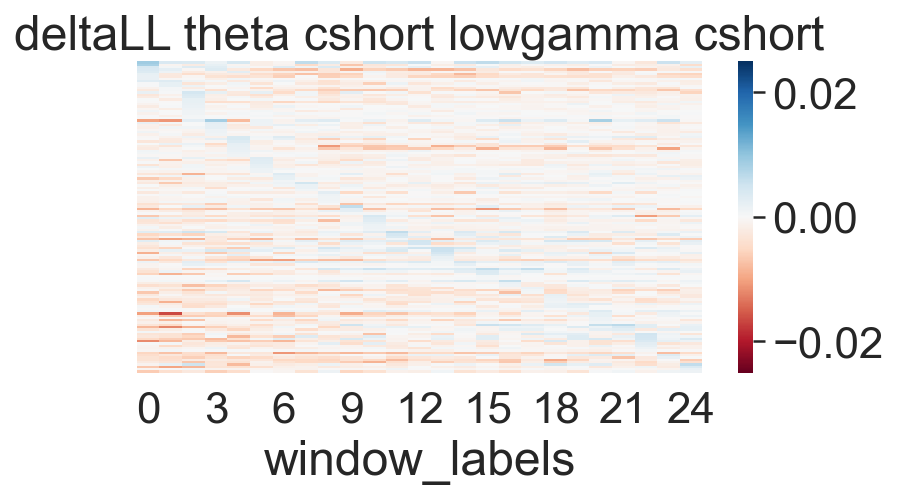

In [31]:
cmin = -0.025
# sns.heatmap(odor_map,cmap="RdBu",center=0, vmin = cmin, vmax = np.abs(cmin))

g1 = sns.heatmap(odor_map,cmap="RdBu",center=0, vmin = cmin, vmax = np.abs(cmin))
g1.set_ylabel('')
g1.set_yticklabels('')
g1.set_title('deltaLL theta cshort lowgamma cshort')
# g1.set_xlabel('')

plt.tight_layout()
plt.savefig('RESULTS/figures/JNeurophysiol_subplot_deltaLLovertime_orderedBy_odorLLDeltaTcshortLcshort_allcells_odor_thetacshort_min_lowgammacshort.pdf')



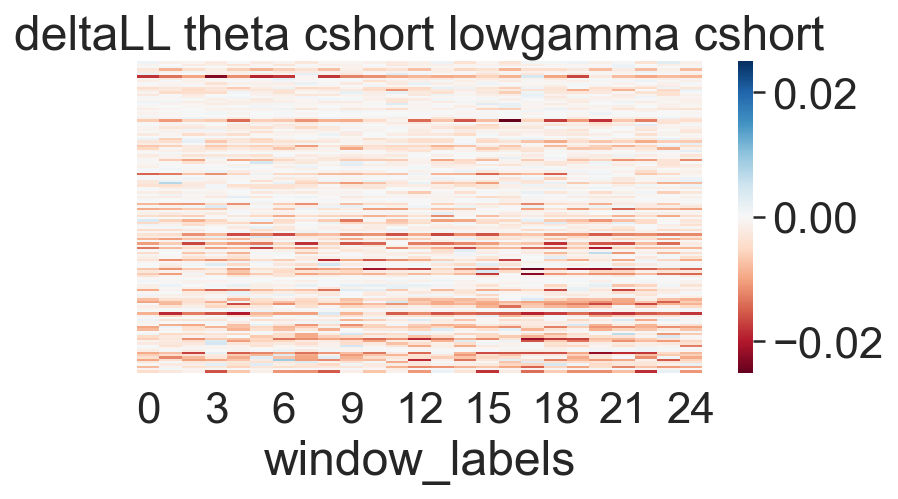

In [32]:

g1 = sns.heatmap(approach_map,cmap="RdBu",center=0, vmin = cmin, vmax = np.abs(cmin))
g1.set_ylabel('')
g1.set_yticklabels('')
g1.set_title('deltaLL theta cshort lowgamma cshort')
# g1.set_xlabel('')

plt.tight_layout()
plt.savefig('RESULTS/figures/JNeurophysiol_subplot_deltaLLovertime_orderedBy_odorLLDeltaTcshortLcshort_allcells_approach_thetacshort_min_lowgammacshort.pdf')



In [33]:
odor_premap = ordered_df_odor.groupby(['ordering','window_labels']).median()['delta_logloss_theta_minus_hshort'].reset_index()
odor_map = odor_premap.pivot("ordering","window_labels",'delta_logloss_theta_minus_hshort')

approach_premap = ordered_df_approach.groupby(['ordering','window_labels']).median()['delta_logloss_theta_minus_hshort'].reset_index()
approach_map = approach_premap.pivot("ordering","window_labels",'delta_logloss_theta_minus_hshort')


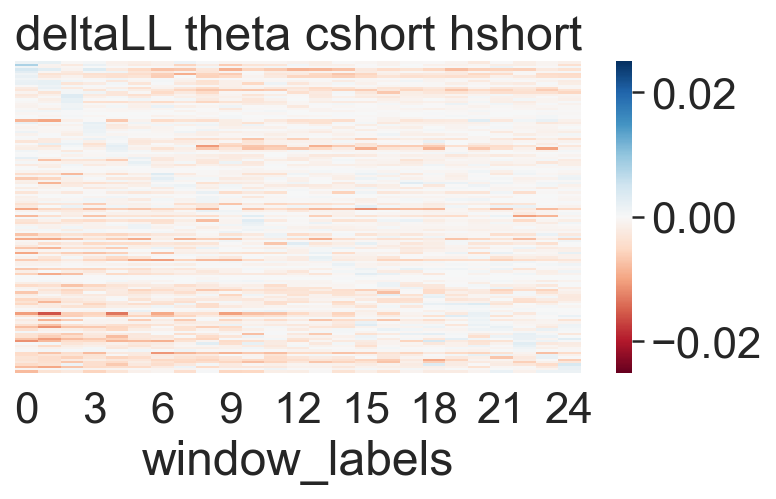

In [35]:
g1 = sns.heatmap(odor_map,cmap="RdBu",center=0, vmin = cmin, vmax = np.abs(cmin))
g1.set_ylabel('')
g1.set_yticklabels('')
g1.set_title('deltaLL theta cshort hshort')
# g1.set_xlabel('')

plt.tight_layout()
plt.savefig('RESULTS/figures/JNeurophysiol_subplot_deltaLLovertime_orderedBy_odorLLDeltaTcshortLcshort_allcells_odor_thetacshort_min_hshort.pdf')



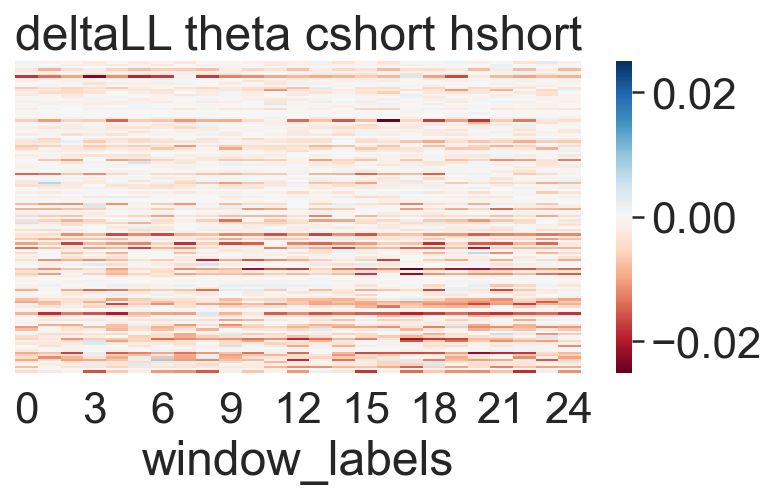

In [36]:
g1 = sns.heatmap(approach_map,cmap="RdBu",center=0, vmin = cmin, vmax = np.abs(cmin))
g1.set_ylabel('')
g1.set_yticklabels('')
g1.set_title('deltaLL theta cshort hshort')
# g1.set_xlabel('')

plt.tight_layout()
plt.savefig('RESULTS/figures/JNeurophysiol_subplot_deltaLLovertime_orderedBy_odorLLDeltaTcshortLcshort_allcells_approach_thetacshort_min_hshort.pdf')


In [37]:
odor_premap = ordered_df_odor.groupby(['ordering','window_labels']).median()['delta_logloss_lowgamma_minus_hshort'].reset_index()
odor_map = odor_premap.pivot("ordering","window_labels",'delta_logloss_lowgamma_minus_hshort')

approach_premap = ordered_df_approach.groupby(['ordering','window_labels']).median()['delta_logloss_lowgamma_minus_hshort'].reset_index()
approach_map = approach_premap.pivot("ordering","window_labels",'delta_logloss_lowgamma_minus_hshort')


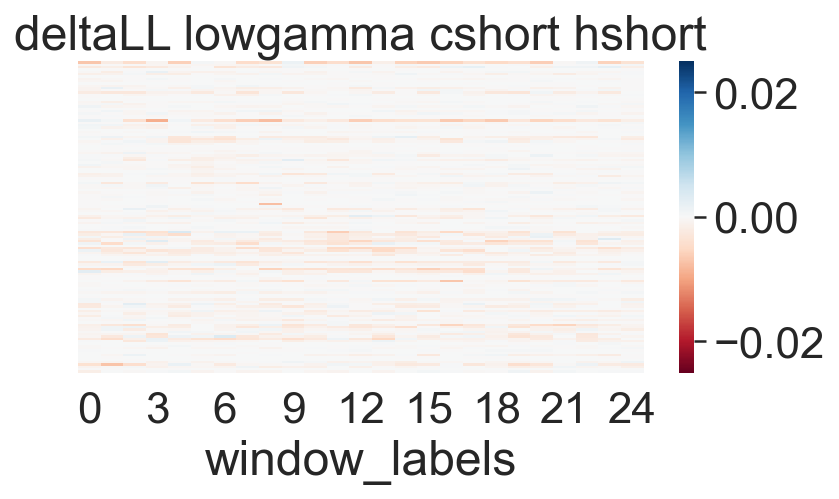

In [39]:
g1 = sns.heatmap(odor_map,cmap="RdBu",center=0, vmin = cmin, vmax = np.abs(cmin))
g1.set_ylabel('')
g1.set_yticklabels('')
g1.set_title('deltaLL lowgamma cshort hshort')
# g1.set_xlabel('')

plt.tight_layout()
plt.savefig('RESULTS/figures/JNeurophysiol_subplot_deltaLLovertime_orderedBy_odorLLDeltaTcshortLcshort_allcells_odor_lowgammacshort_min_hshort.pdf')



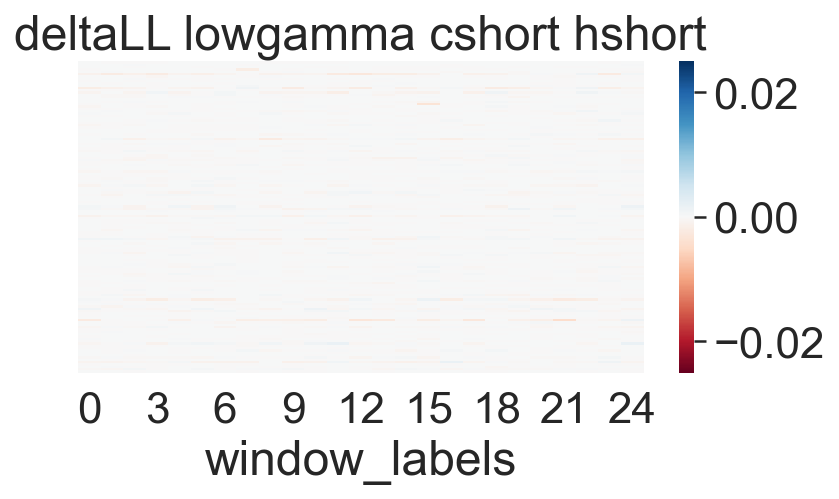

In [40]:
g1 = sns.heatmap(approach_map,cmap="RdBu",center=0, vmin = cmin, vmax = np.abs(cmin))
g1.set_ylabel('')
g1.set_yticklabels('')
g1.set_title('deltaLL lowgamma cshort hshort')
# g1.set_xlabel('')

plt.tight_layout()
plt.savefig('RESULTS/figures/JNeurophysiol_subplot_deltaLLovertime_orderedBy_odorLLDeltaTcshortLcshort_allcells_approach_lowgammacshort_min_hshort.pdf')


### subplots: population approach

In [53]:
tmpdf = pd.read_csv('loss_delta_theta_lowgamma_approach_allcells.csv')

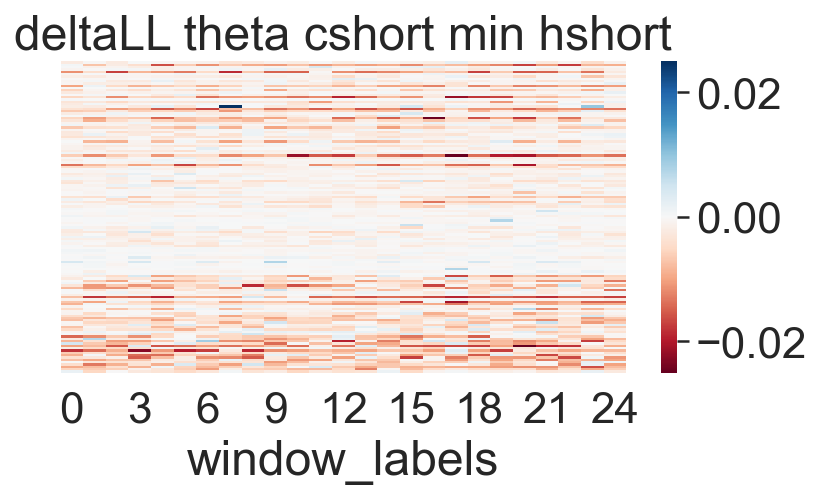

In [54]:
cmin = -0.025

tmp = tmpdf.reset_index()
tmp2 = tmp.groupby(['cell_id','window_labels']).mean()['delta_logloss_theta_minus_hshort'].reset_index()
tmp3 = tmp2.pivot("cell_id","window_labels","delta_logloss_theta_minus_hshort")

g1 = sns.heatmap(tmp3,cmap="RdBu",center=0, vmin = cmin, vmax = np.abs(cmin))
g1.set_ylabel('')
g1.set_yticklabels('')
g1.set_title('deltaLL theta cshort min hshort')
# g1.set_xlabel('')

plt.tight_layout()
# plt.savefig('RESULTS/figures/JNeurophysiol_subplot_deltaLLovertime_allcells_approach_thetacshort_min_hshort.pdf')

In [45]:
df_pivot = pd.pivot_table(tmp, index=['cell_id'], columns = ['window_labels'],values=['delta_logloss_theta_minus_lowgamma'], fill_value=0)




In [54]:
tmp

index  Unnamed: 0  Unnamed: 0.1  \
0          0           0             0   
1          1           1             1   
2          2           2             2   
3          3           3             3   
4          4           4             4   
...      ...         ...           ...   
66995  66995       42995            20   
66996  66996       42996            21   
66997  66997       42997            22   
66998  66998       42998            23   
66999  66999       42999            24   

                                         cell_id  \
0      LH16_D10_ctxtsig_odorblock1_TETSPK21k.mat   
1      LH16_D10_ctxtsig_odorblock1_TETSPK21k.mat   
2      LH16_D10_ctxtsig_odorblock1_TETSPK21k.mat   
3      LH16_D10_ctxtsig_odorblock1_TETSPK21k.mat   
4      LH16_D10_ctxtsig_odorblock1_TETSPK21k.mat   
...                                          ...   
66995   LH16_D9_ctxtsig_odorblock2_TETSPK37c.mat   
66996   LH16_D9_ctxtsig_odorblock2_TETSPK37c.mat   
66997   LH16_D9_ctxtsig_odorblock2_TETSPK37c.mat   
66998   LH16_D9_ctxtsig_odorblock2_TETSPK37c.mat   
66999   LH16_D9_ctxtsig_odorblock2_TETSPK37c.mat   

       delta_logloss_theta_minus_lowgamma  delta_logloss_theta_minus_hshort  \
0                               -0.002934                         -0.002447   
1                                0.000405                          0.000691   
2                               -0.002435                         -0.002663   
3                               -0.001985                         -0.001855   
4                               -0.001646                         -0.001344   
...                                   ...                               ...   
66995                           -0.002040                         -0.002036   
66996                            0.000495                          0.000495   
66997                           -0.001282                         -0.001283   
66998                            0.001437                          0.001446   
66999                           -0.000869                         -0.000867   

       delta_logloss_lowgamma_minus_hshort  window_labels  fold  
0                             4.869676e-04              0     0  
1                             2.858715e-04              1     0  
2                            -2.280288e-04              2     0  
3                             1.295129e-04              3     0  
4                             3.018998e-04              4     0  
...                                    ...            ...   ...  
66995                         4.271006e-06             20    19  
66996                         2.219189e-07             21    19  
66997                        -6.109562e-07             22    19  
66998                         8.844299e-06             23    19  
66999                         1.807661e-06             24    19  

[67000 rows x 9 columns]

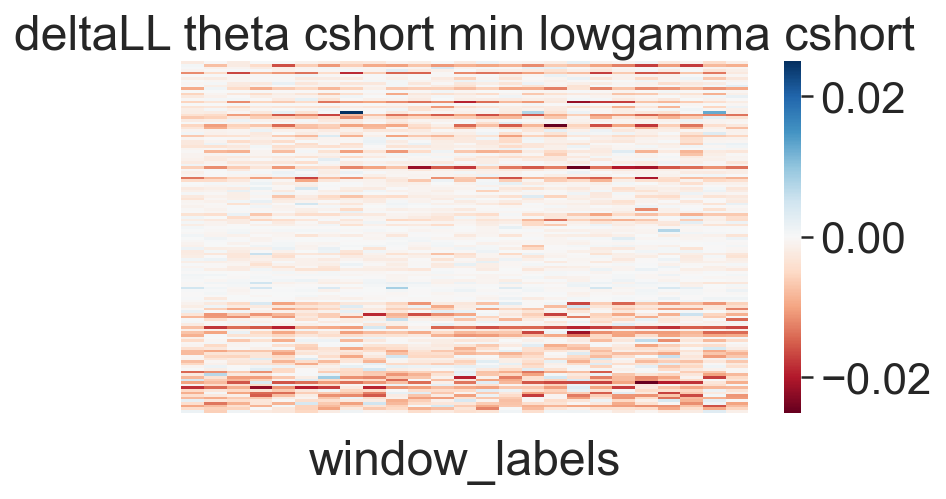

In [42]:

tmp = tmpdf.reset_index()
tmp2 = tmp.groupby(['cell_id','window_labels']).mean()['delta_logloss_theta_minus_lowgamma'].reset_index()
tmp3 = tmp2.pivot("cell_id","window_labels","delta_logloss_theta_minus_lowgamma")

# df_pivot = pd.pivot_table(tmp, index=['cell_id'], columns = ['window_labels'],values=['delta_logloss_theta_minus_lowgamma'], fill_value=0)
# tmp4 = df_pivot.reindex(df_pivot['delta_logloss_theta_minus_lowgamma'].sort_values(by=[1,2,0], ascending=True).index)

g1 = sns.heatmap(tmp3,cmap="RdBu",center=0, vmin = cmin, vmax = np.abs(cmin))
g1.set_ylabel('')
g1.set_yticklabels('')
g1.set_xticklabels('')
g1.set_title('deltaLL theta cshort min lowgamma cshort')
# g1.set_xlabel('')

plt.tight_layout()
plt.savefig('RESULTS/figures/JNeurophysiol_subplot_deltaLLovertime_allcells_approach_thetacshort_min_lowgammacshort.pdf')

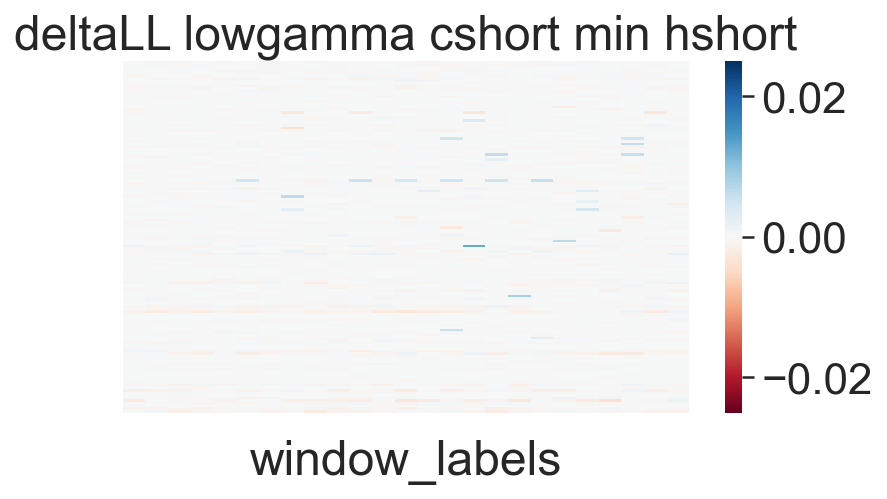

In [61]:
tmp = tmpdf.reset_index()
tmp2 = tmp.groupby(['cell_id','window_labels']).mean()['delta_logloss_lowgamma_minus_hshort'].reset_index()
tmp3 = tmp2.pivot("cell_id","window_labels","delta_logloss_lowgamma_minus_hshort")



g1 = sns.heatmap(tmp3,cmap="RdBu",center=0, vmin = cmin, vmax = np.abs(cmin))
g1.set_ylabel('')
g1.set_yticklabels('')
g1.set_xticklabels('')
g1.set_title('deltaLL lowgamma cshort min hshort')
# g1.set_xlabel('')

plt.tight_layout()
plt.savefig('RESULTS/figures/JNeurophysiol_subplot_deltaLLovertime_allcells_approach_lowgammacshort_min_hshort.pdf')



### subplots: population odor

In [62]:
df_odor = pd.read_csv('loss_delta_theta_lowgamma_odor_allcells.csv')

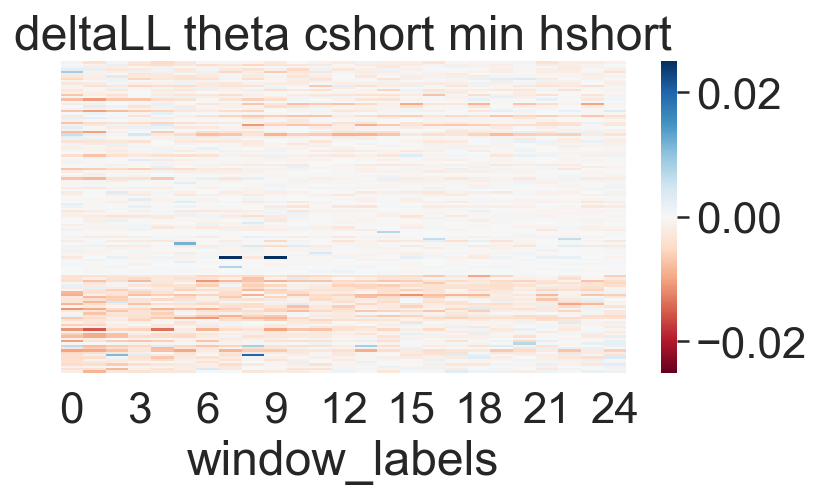

In [64]:
cmin = -0.025

tmp = df_odor.reset_index()
tmp2 = tmp.groupby(['cell_id','window_labels']).mean()['delta_logloss_theta_minus_hshort'].reset_index()
tmp3 = tmp2.pivot("cell_id","window_labels","delta_logloss_theta_minus_hshort")

g1 = sns.heatmap(tmp3,cmap="RdBu",center=0, vmin = cmin, vmax = np.abs(cmin))
g1.set_ylabel('')
g1.set_yticklabels('')
g1.set_title('deltaLL theta cshort min hshort')
# g1.set_xlabel('')

plt.tight_layout()
plt.savefig('RESULTS/figures/JNeurophysiol_subplot_deltaLLovertime_allcells_odor_thetacshort_min_hshort.pdf')

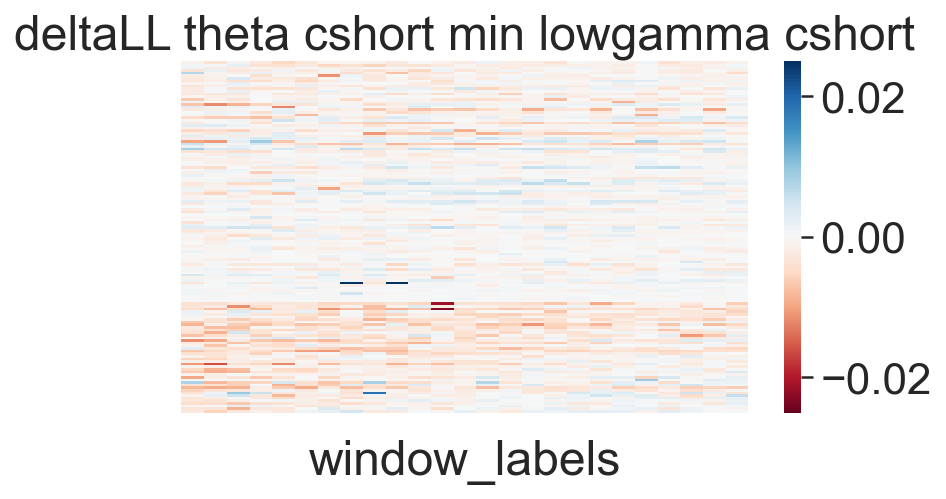

In [66]:
tmp = df_odor.reset_index()
tmp2 = tmp.groupby(['cell_id','window_labels']).mean()['delta_logloss_theta_minus_lowgamma'].reset_index()
tmp3 = tmp2.pivot("cell_id","window_labels","delta_logloss_theta_minus_lowgamma")

# df_pivot = pd.pivot_table(tmp, index=['cell_id'], columns = ['window_labels'],values=['delta_logloss_theta_minus_lowgamma'], fill_value=0)
# tmp4 = df_pivot.reindex(df_pivot['delta_logloss_theta_minus_lowgamma'].sort_values(by=[1,2,0], ascending=True).index)

g1 = sns.heatmap(tmp3,cmap="RdBu",center=0, vmin = cmin, vmax = np.abs(cmin))
g1.set_ylabel('')
g1.set_yticklabels('')
g1.set_xticklabels('')
g1.set_title('deltaLL theta cshort min lowgamma cshort')
# g1.set_xlabel('')

plt.tight_layout()
plt.savefig('RESULTS/figures/JNeurophysiol_subplot_deltaLLovertime_allcells_odor_thetacshort_min_lowgammacshort.pdf')



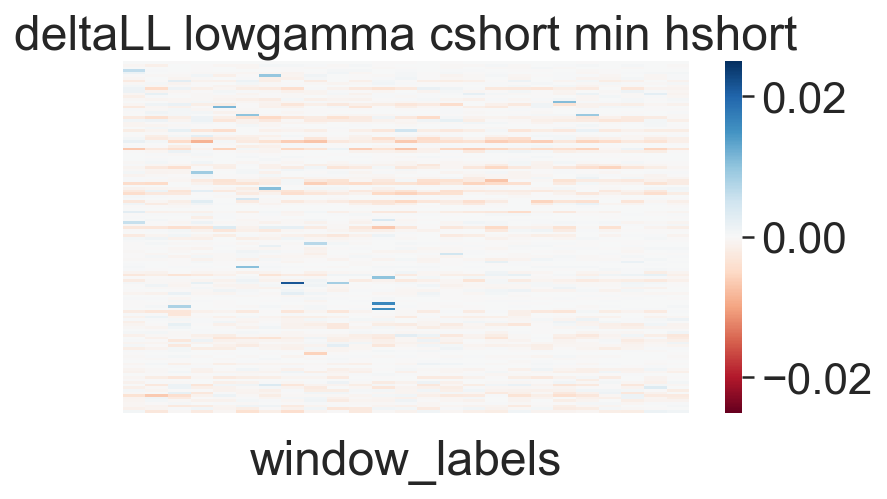

In [68]:
tmp = df_odor.reset_index()
tmp2 = tmp.groupby(['cell_id','window_labels']).mean()['delta_logloss_lowgamma_minus_hshort'].reset_index()
tmp3 = tmp2.pivot("cell_id","window_labels","delta_logloss_lowgamma_minus_hshort")



g1 = sns.heatmap(tmp3,cmap="RdBu",center=0, vmin = cmin, vmax = np.abs(cmin))
g1.set_ylabel('')
g1.set_yticklabels('')
g1.set_xticklabels('')
g1.set_title('deltaLL lowgamma cshort min hshort')
# g1.set_xlabel('')

plt.tight_layout()
plt.savefig('RESULTS/figures/JNeurophysiol_subplot_deltaLLovertime_allcells_odor_lowgammacshort_min_hshort.pdf')





### subplots: subset approach

In [6]:
cells_odor = ['LH16_08_22_14_D29_theta_correct_odorblock2TETSPK53c',
              'LH9_10_10_13_D10_theta_correct_odorblock2TETSPK13a',
              'LH16_08_08_14_D22_theta_correct_odorblock2TETSPK09a']

cells_app = ['LH16_D29_ctxtsig_odorblock2_TETSPK53c.mat',
              'LH9_D10_ctxtsig_odorblock2_TETSPK13a.mat',
              'LH16_D22_ctxtsig_odorblock2_TETSPK09a.mat']

In [7]:
df_app_subset = df_approach[df_approach['cell_id'].isin(cells_app)]
df_odor_subset = df_odor[df_odor['cell_id'].isin(cells_odor)]

In [8]:
cmin = -0.025

tmp = df_app_subset.reset_index()
tmp2 = tmp.groupby(['cell_id','window_labels']).median()['delta_logloss_theta_minus_hshort'].reset_index()
tmp3 = tmp2.pivot("cell_id","window_labels","delta_logloss_theta_minus_hshort")

g1 = sns.heatmap(tmp3,cmap="RdBu",center=0, vmin = cmin, vmax = np.abs(cmin))
g1.set_ylabel('')
g1.set_yticklabels('')
g1.set_title('deltaLL theta cshort min hshort')
# g1.set_xlabel('')

plt.tight_layout()
plt.savefig('RESULTS/figures/JNeurophysiol_subplot_deltaLLovertime_3samplecells_approach_thetacshort_min_hshort.pdf')



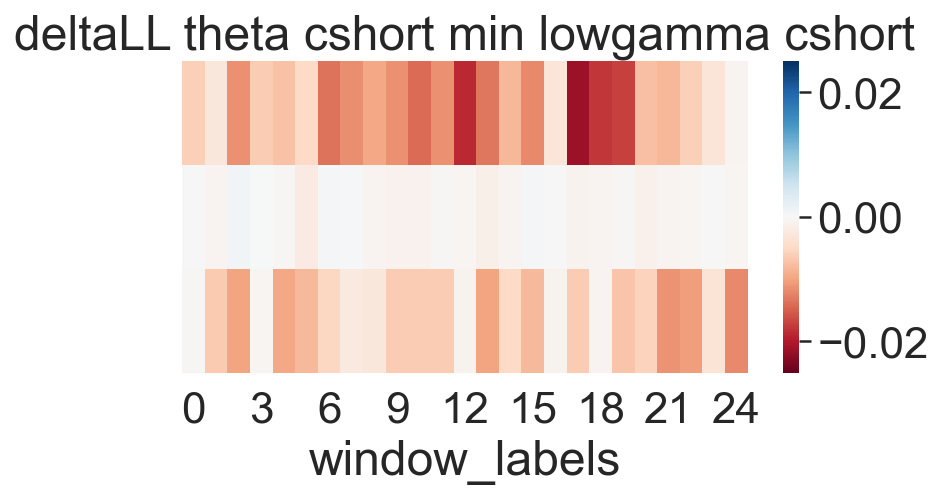

In [9]:
tmp = df_app_subset.reset_index()
tmp2 = tmp.groupby(['cell_id','window_labels']).median()['delta_logloss_theta_minus_lowgamma'].reset_index()
tmp3 = tmp2.pivot("cell_id","window_labels","delta_logloss_theta_minus_lowgamma")

g1 = sns.heatmap(tmp3,cmap="RdBu",center=0, vmin = cmin, vmax = np.abs(cmin))
g1.set_ylabel('')
g1.set_yticklabels('')
g1.set_title('deltaLL theta cshort min lowgamma cshort')
# g1.set_xlabel('')

plt.tight_layout()
plt.savefig('RESULTS/figures/JNeurophysiol_subplot_deltaLLovertime_3samplecells_approach_thetacshort_min_lowgammacshort.pdf')


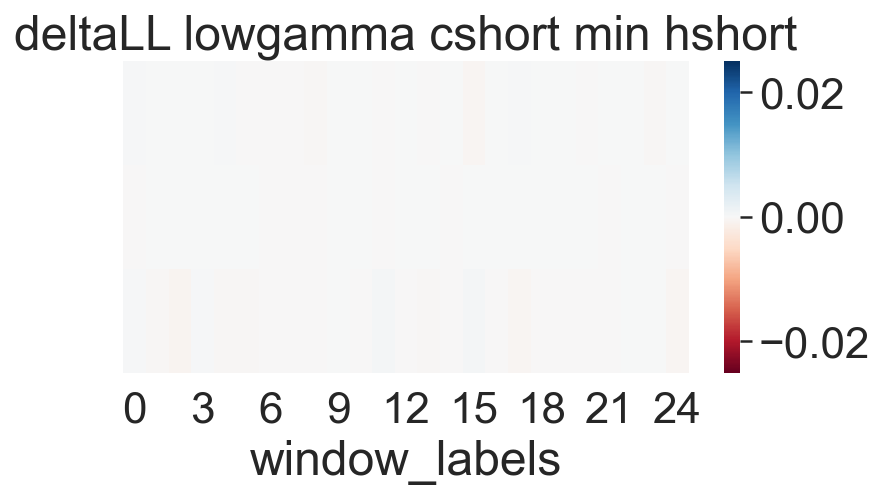

In [10]:
tmp = df_app_subset.reset_index()
tmp2 = tmp.groupby(['cell_id','window_labels']).median()['delta_logloss_lowgamma_minus_hshort'].reset_index()
tmp3 = tmp2.pivot("cell_id","window_labels","delta_logloss_lowgamma_minus_hshort")

g1 = sns.heatmap(tmp3,cmap="RdBu",center=0, vmin = cmin, vmax = np.abs(cmin))
g1.set_ylabel('')
g1.set_yticklabels('')
g1.set_title('deltaLL lowgamma cshort min hshort')
# g1.set_xlabel('')

plt.tight_layout()
plt.savefig('RESULTS/figures/JNeurophysiol_subplot_deltaLLovertime_3samplecells_approach_lowgammacshort_min_hshort.pdf')


Firing rates for these interneurons: 

In [18]:
datapath = 'RESULTS/PHASE_HIST_MODELS_highvapproach_all_realcells/starintlogoddsCompleteSinglePredMdls177/theta_250ms/folds/'

cells_app = ['LH16_D29_ctxtsig_odorblock2_TETSPK53c.mat',
              'LH9_D10_ctxtsig_odorblock2_TETSPK13a.mat',
              'LH16_D22_ctxtsig_odorblock2_TETSPK09a.mat']
fratedf = []
count = 0
for cell_id in cells_app: 
    
    for fold in tqdm(range(20)):
        
        foldpath = os.path.join(datapath,str(fold))
        nrnpath = os.path.join(foldpath,cell_id)
        
        test = pd.read_csv(os.path.join(nrnpath,'test_data.csv'),usecols=['spikes'])

        frate = test['spikes'].sum()/test.shape[0]
        
        fratedict = {'cell_id': cell_id,
                     'fold': fold,
                     'frate': frate
                    }
        
        fratedf.append(pd.DataFrame(fratedict,index=[count]))
        count+=1
        
frate_df_app = pd.concat(fratedf)


100%|███████████████████████████████████████████| 20/20 [00:05<00:00,  3.42it/s]


In [24]:
frate_df_app.groupby(['cell_id']).mean()['frate'].reset_index()


cell_id     frate
0  LH16_D22_ctxtsig_odorblock2_TETSPK09a.mat  0.035474
1  LH16_D29_ctxtsig_odorblock2_TETSPK53c.mat  0.036590
2   LH9_D10_ctxtsig_odorblock2_TETSPK13a.mat  0.042432

### subplots: subset odor

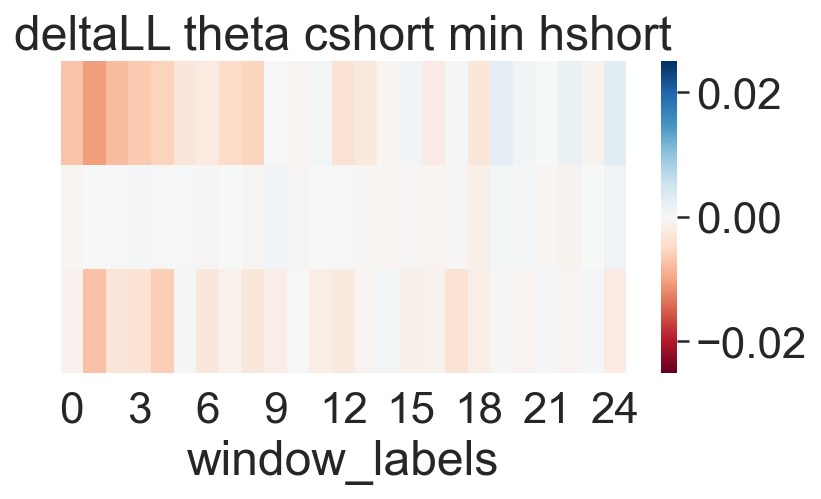

In [13]:
tmp = df_odor_subset.reset_index()
tmp2 = tmp.groupby(['cell_id','window_labels']).median()['delta_logloss_theta_minus_hshort'].reset_index()
tmp3 = tmp2.pivot("cell_id","window_labels","delta_logloss_theta_minus_hshort")

g1 = sns.heatmap(tmp3,cmap="RdBu",center=0, vmin = cmin, vmax = np.abs(cmin))
g1.set_ylabel('')
g1.set_yticklabels('')
g1.set_title('deltaLL theta cshort min hshort')
# g1.set_xlabel('')

plt.tight_layout()
plt.savefig('RESULTS/figures/JNeurophysiol_subplot_deltaLLovertime_3samplecells_odor_thetacshort_min_hshort.pdf')


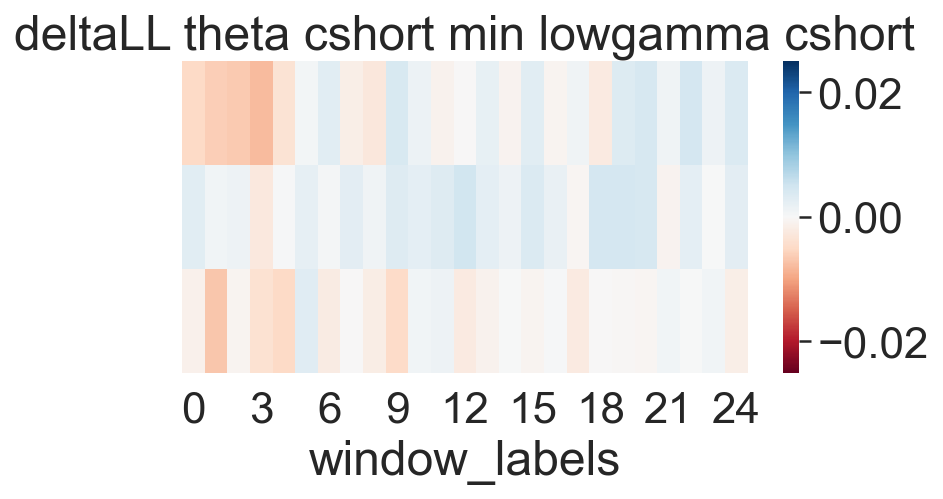

In [14]:
tmp = df_odor_subset.reset_index()
tmp2 = tmp.groupby(['cell_id','window_labels']).median()['delta_logloss_theta_minus_lowgamma'].reset_index()
tmp3 = tmp2.pivot("cell_id","window_labels","delta_logloss_theta_minus_lowgamma")

g1 = sns.heatmap(tmp3,cmap="RdBu",center=0, vmin = cmin, vmax = np.abs(cmin))
g1.set_ylabel('')
g1.set_yticklabels('')
g1.set_title('deltaLL theta cshort min lowgamma cshort')
# g1.set_xlabel('')

plt.tight_layout()
plt.savefig('RESULTS/figures/JNeurophysiol_subplot_deltaLLovertime_3samplecells_odor_thetacshort_min_lowgammacshort.pdf')



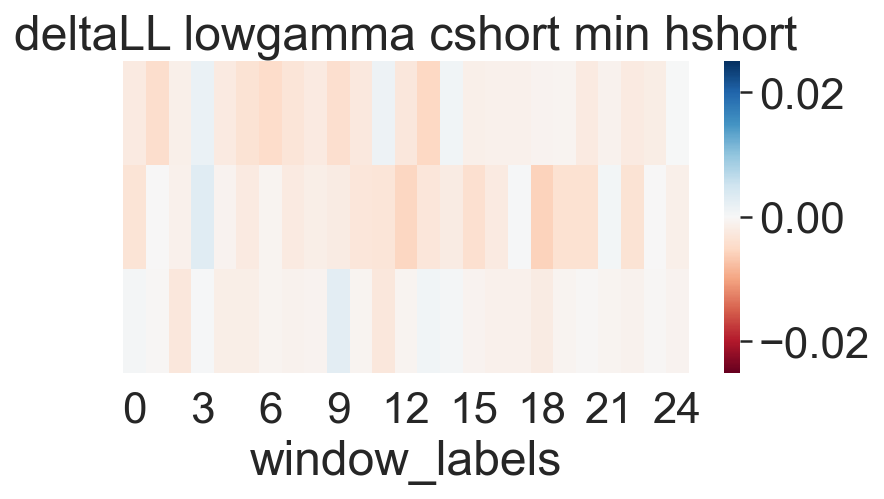

In [15]:
tmp = df_odor_subset.reset_index()
tmp2 = tmp.groupby(['cell_id','window_labels']).median()['delta_logloss_lowgamma_minus_hshort'].reset_index()
tmp3 = tmp2.pivot("cell_id","window_labels","delta_logloss_lowgamma_minus_hshort")

g1 = sns.heatmap(tmp3,cmap="RdBu",center=0, vmin = cmin, vmax = np.abs(cmin))
g1.set_ylabel('')
g1.set_yticklabels('')
g1.set_title('deltaLL lowgamma cshort min hshort')
# g1.set_xlabel('')

plt.tight_layout()
plt.savefig('RESULTS/figures/JNeurophysiol_subplot_deltaLLovertime_3samplecells_odor_lowgammacshort_min_hshort.pdf')


Firing rates for these interneurons: 

In [30]:
datapath = 'RESULTS/PHASE_HIST_MODELS_all_realcells/intlogoddsCompleteSinglePredMdls940/thetaphase_250ms/folds/'


cells_odor = ['LH16_08_22_14_D29_theta_correct_odorblock2TETSPK53c',
              'LH9_10_10_13_D10_theta_correct_odorblock2TETSPK13a',
              'LH16_08_08_14_D22_theta_correct_odorblock2TETSPK09a']
fratedf = []
count = 0
for cell_id in cells_odor: 
    
    for fold in tqdm(range(20)):
        
        foldpath = os.path.join(datapath,str(fold))
        foldpath = os.path.join(foldpath,'single_neuron')
        nrnpath = os.path.join(foldpath,cell_id)
        
        test = pd.read_csv(os.path.join(nrnpath,'test_data.csv'),usecols=['spikes'])

        frate = test['spikes'].sum()/test.shape[0]
        
        fratedict = {'cell_id': cell_id,
                     'fold': fold,
                     'frate': frate
                    }
        
        fratedf.append(pd.DataFrame(fratedict,index=[count]))
        count+=1
        
frate_df_odor = pd.concat(fratedf)


100%|███████████████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


In [32]:
frate_df_app.groupby('cell_id').mean()['frate'].reset_index()

cell_id     frate
0  LH16_08_08_14_D22_theta_correct_odorblock2TETSPK09a  0.020306
1  LH16_08_22_14_D29_theta_correct_odorblock2TETSPK53c  0.020871
2   LH9_10_10_13_D10_theta_correct_odorblock2TETSPK13a  0.026233

Find velocity for approach

In [18]:
datapath = 'python_approach_highestv_data/'

for cell in cells_app[:1]:
    
    matfile = sio.loadmat(os.path.join(datapath,cell))
    v = matfile['vseries']

In [19]:
matfile

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Wed Apr 13 08:42:18 2022',
 '__version__': '1.0',
 '__globals__': [],
 'beta_15to35_phase_long': array([[ 1.98410339,  1.86526296,  1.74458925, ..., -0.9979944 ,
         -1.13141864, -1.26605684]]),
 'beta_15to35_phase_stacked': array([[ 1.98410339,  1.86526296,  1.74458925, ...,  1.57476241,
          1.42883606,  1.28128309],
        [-2.61531962, -2.72865285, -2.84307338, ..., -1.33277971,
         -1.48832863, -1.6438708 ],
        [ 3.03999573,  2.92285843,  2.80138061, ...,  0.39171473,
          0.23301447,  0.07430858],
        ...,
        [-2.76299466, -2.93829722, -3.11376536, ..., -0.8851601 ,
         -1.01348508, -1.13999667],
        [-0.06607433, -0.26506881, -0.47505558, ...,  0.38151363,
          0.28974741,  0.19737367],
        [-0.36931323, -0.37681356, -0.41002889, ..., -0.9979944 ,
         -1.13141864, -1.26605684]]),
 'highgamma_65to90_phase_long': array([[-2.96599225,  2.84865229,  2.3792886

In [17]:
import scipy.io as sio

In [120]:
cell_subset_app = ['LH16_D29_ctxtsig_odorblock1_TETSPK53c.mat',
                   'LH16_D22_ctxtsig_odorblock2_TETSPK09a.mat'
              ]

cell_subset_odor = ['LH16_08_22_14_D29_theta_correct_odorblock1TETSPK53c',
                    'LH16_08_08_14_D22_theta_correct_odorblock2TETSPK09a'
              ]

lossdf_app = loss_delta_df[loss_delta_df['cell_id'].isin(cell_subset_app)]
lossdf_odor = df4[df4['cell_id'].isin(cell_subset_odor)]

In [121]:
lossdf_odor

Unnamed: 0                                              cell_id  \
1000            0  LH16_08_08_14_D22_theta_correct_odorblock2TETSPK09a   
1001            1  LH16_08_08_14_D22_theta_correct_odorblock2TETSPK09a   
1002            2  LH16_08_08_14_D22_theta_correct_odorblock2TETSPK09a   
1003            3  LH16_08_08_14_D22_theta_correct_odorblock2TETSPK09a   
1004            4  LH16_08_08_14_D22_theta_correct_odorblock2TETSPK09a   
...           ...                                                  ...   
14995          20  LH16_08_22_14_D29_theta_correct_odorblock1TETSPK53c   
14996          21  LH16_08_22_14_D29_theta_correct_odorblock1TETSPK53c   
14997          22  LH16_08_22_14_D29_theta_correct_odorblock1TETSPK53c   
14998          23  LH16_08_22_14_D29_theta_correct_odorblock1TETSPK53c   
14999          24  LH16_08_22_14_D29_theta_correct_odorblock1TETSPK53c   

       delta_logloss_theta_minus_lowgamma  delta_logloss_theta_minus_hshort  \
1000                            -0.002927                         -0.006344   
1001                            -0.006327                         -0.009565   
1002                            -0.006100                         -0.006478   
1003                            -0.005546                         -0.006604   
1004                            -0.006010                         -0.006115   
...                                   ...                               ...   
14995                           -0.000336                         -0.000151   
14996                            0.002174                          0.000305   
14997                            0.004164                          0.000156   
14998                            0.001277                         -0.000523   
14999                           -0.002473                         -0.001061   

       delta_logloss_lowgamma_minus_hshort  window_labels  fold  
1000                             -0.003418              0     0  
1001                             -0.003237              1     0  
1002                             -0.000378              2     0  
1003                             -0.001058              3     0  
1004                             -0.000105              4     0  
...                                    ...            ...   ...  
14995                             0.000185             20    19  
14996                            -0.001870             21    19  
14997                            -0.004008             22    19  
14998                            -0.001799             23    19  
14999                             0.001412             24    19  

[1000 rows x 7 columns]

In [143]:
lossdf_app

cell_id  \
0   LH16_D22_ctxtsig_odorblock2_TETSPK09a.mat   
1   LH16_D22_ctxtsig_odorblock2_TETSPK09a.mat   
2   LH16_D22_ctxtsig_odorblock2_TETSPK09a.mat   
3   LH16_D22_ctxtsig_odorblock2_TETSPK09a.mat   
4   LH16_D22_ctxtsig_odorblock2_TETSPK09a.mat   
..                                        ...   
20  LH16_D29_ctxtsig_odorblock1_TETSPK53c.mat   
21  LH16_D29_ctxtsig_odorblock1_TETSPK53c.mat   
22  LH16_D29_ctxtsig_odorblock1_TETSPK53c.mat   
23  LH16_D29_ctxtsig_odorblock1_TETSPK53c.mat   
24  LH16_D29_ctxtsig_odorblock1_TETSPK53c.mat   

    delta_logloss_theta_minus_lowgamma  delta_logloss_theta_minus_hshort  \
0                            -0.006178                         -0.005788   
1                             0.000122                         -0.000264   
2                            -0.017939                         -0.018004   
3                            -0.006671                         -0.006265   
4                            -0.006847                         -0.006749   
..                                 ...                               ...   
20                            0.000730                          0.000708   
21                           -0.000472                         -0.000465   
22                            0.000415                          0.000426   
23                            0.001598                          0.001604   
24                           -0.001955                         -0.001955   

    delta_logloss_lowgamma_minus_hshort  window_labels  fold  
0                          3.906911e-04              0     0  
1                         -3.857676e-04              1     0  
2                         -6.546820e-05              2     0  
3                          4.064051e-04              3     0  
4                          9.882209e-05              4     0  
..                                  ...            ...   ...  
20                        -2.206753e-05             20    19  
21                         6.836444e-06             21    19  
22                         1.095031e-05             22    19  
23                         5.823203e-06             23    19  
24                        -3.780082e-07             24    19  

[1000 rows x 6 columns]

### subplots: approach

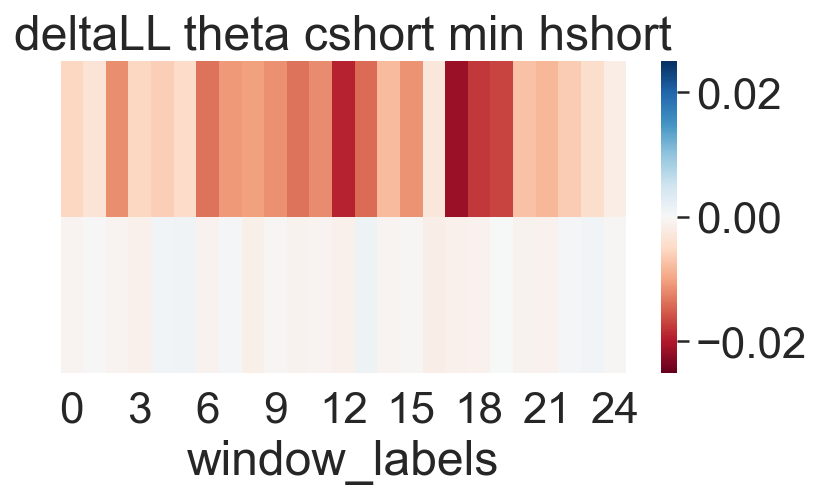

In [185]:
cmin = -0.025

tmp = lossdf_app.reset_index()
tmp2 = tmp.groupby(['cell_id','window_labels']).mean()['delta_logloss_theta_minus_hshort'].reset_index()
tmp3 = tmp2.pivot("cell_id","window_labels","delta_logloss_theta_minus_hshort")

g1 = sns.heatmap(tmp3,cmap="RdBu",center=0, vmin = cmin, vmax = np.abs(cmin))
g1.set_ylabel('')
g1.set_yticklabels('')
g1.set_title('deltaLL theta cshort min hshort')
# g1.set_xlabel('')

plt.tight_layout()
plt.savefig('RESULTS/figures/JNeurophysiol_subplot_deltaLLovertime_2samplecells_approach_thetacshort_min_hshort.pdf')

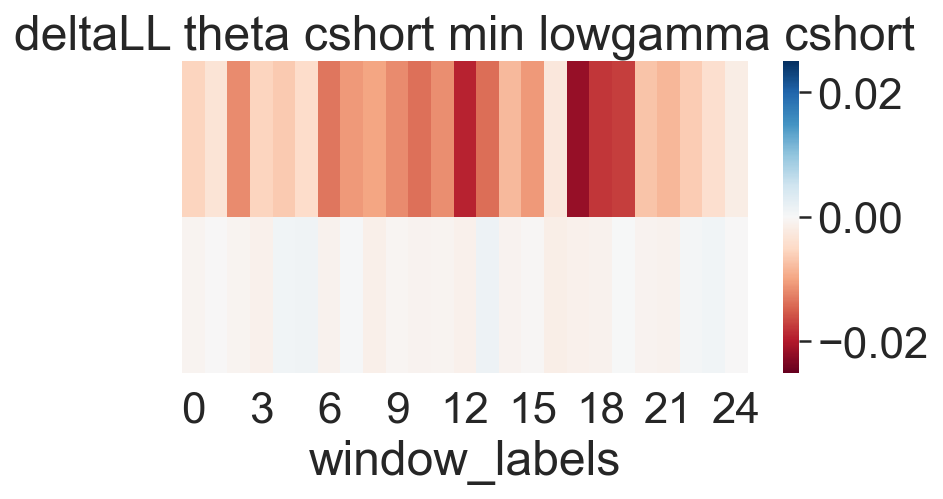

In [186]:
tmp = lossdf_app.reset_index()
tmp2 = tmp.groupby(['cell_id','window_labels']).mean()['delta_logloss_theta_minus_lowgamma'].reset_index()
tmp3 = tmp2.pivot("cell_id","window_labels","delta_logloss_theta_minus_lowgamma")

g1 = sns.heatmap(tmp3,cmap="RdBu",center=0, vmin = cmin, vmax = np.abs(cmin))
g1.set_ylabel('')
g1.set_yticklabels('')
g1.set_title('deltaLL theta cshort min lowgamma cshort')

plt.tight_layout()
plt.savefig('RESULTS/figures/JNeurophysiol_subplot_deltaLLovertime_2samplecells_approach_thetacshort_min_lowgammacshort.pdf')

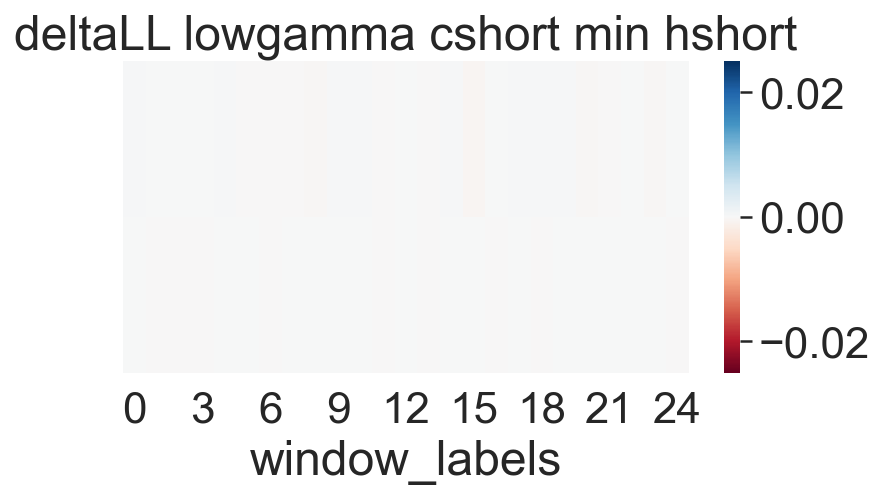

In [187]:
tmp = lossdf_app.reset_index()
tmp2 = tmp.groupby(['cell_id','window_labels']).mean()['delta_logloss_lowgamma_minus_hshort'].reset_index()
tmp3 = tmp2.pivot("cell_id","window_labels","delta_logloss_lowgamma_minus_hshort")

g1 = sns.heatmap(tmp3,cmap="RdBu",center=0, vmin = cmin, vmax = np.abs(cmin))
g1.set_ylabel('')
g1.set_yticklabels('')
g1.set_title('deltaLL lowgamma cshort min hshort')

plt.tight_layout()
plt.savefig('RESULTS/figures/JNeurophysiol_subplot_deltaLLovertime_2samplecells_approach_lowgammacshort_min_hshort.pdf')

### subplots: odor

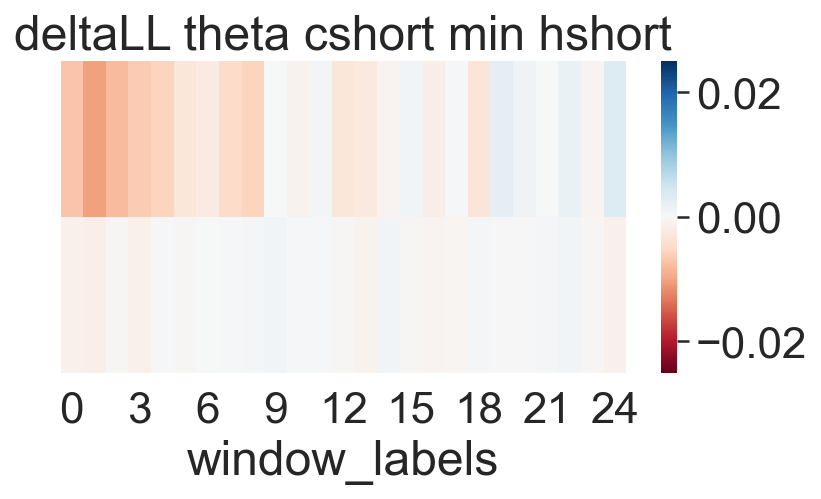

In [188]:
tmp = lossdf_odor.reset_index()
tmp2 = tmp.groupby(['cell_id','window_labels']).mean()['delta_logloss_theta_minus_hshort'].reset_index()
tmp3 = tmp2.pivot("cell_id","window_labels","delta_logloss_theta_minus_hshort")

g1 = sns.heatmap(tmp3,cmap="RdBu",center=0, vmin = cmin, vmax = np.abs(cmin))
g1.set_ylabel('')
g1.set_yticklabels('')
g1.set_title('deltaLL theta cshort min hshort')

plt.tight_layout()
plt.savefig('RESULTS/figures/JNeurophysiol_subplot_deltaLLovertime_2samplecells_odor_thetacshort_min_hshort.pdf')

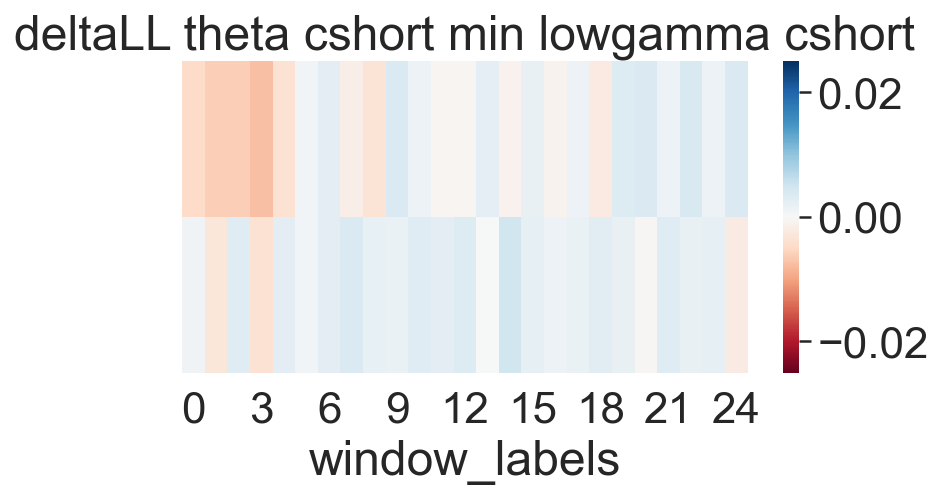

In [189]:
tmp = lossdf_odor.reset_index()
tmp2 = tmp.groupby(['cell_id','window_labels']).mean()['delta_logloss_theta_minus_lowgamma'].reset_index()
tmp3 = tmp2.pivot("cell_id","window_labels","delta_logloss_theta_minus_lowgamma")

g1 = sns.heatmap(tmp3,cmap="RdBu",center=0, vmin = cmin, vmax = np.abs(cmin))
g1.set_ylabel('')
g1.set_yticklabels('')
g1.set_title('deltaLL theta cshort min lowgamma cshort')

plt.tight_layout()
plt.savefig('RESULTS/figures/JNeurophysiol_subplot_deltaLLovertime_2samplecells_odor_thetacshort_min_lowgammacshort.pdf')

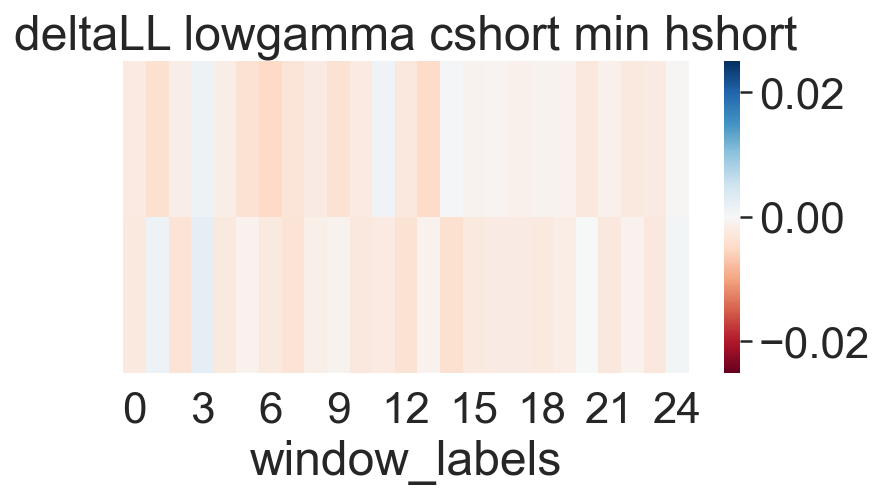

In [190]:
tmp = lossdf_odor.reset_index()
tmp2 = tmp.groupby(['cell_id','window_labels']).mean()['delta_logloss_lowgamma_minus_hshort'].reset_index()
tmp3 = tmp2.pivot("cell_id","window_labels","delta_logloss_lowgamma_minus_hshort")

g1 = sns.heatmap(tmp3,cmap="RdBu",center=0, vmin = cmin, vmax = np.abs(cmin))
g1.set_ylabel('')
g1.set_yticklabels('')
g1.set_title('deltaLL lowgamma cshort min hshort')

plt.tight_layout()
plt.savefig('RESULTS/figures/JNeurophysiol_subplot_deltaLLovertime_2samplecells_odor_lowgammacshort_min_hshort.pdf')

In [88]:
tmp = loss_delta_df.reset_index()
tmp2 = tmp.groupby(['cell_id','window_labels']).mean()['delta_logloss_theta_minus_hshort'].reset_index()
tmp3 = tmp2.pivot("cell_id","window_labels","delta_logloss_theta_minus_hshort")

# tmp = loss_delta_df.reset_index()
# tmp2 = tmp.groupby(['cell_id','window_labels']).mean()['delta_logloss_theta_minus_lowgamma'].reset_index()
# tmp3 = tmp2.pivot("cell_id","window_labels","delta_logloss_theta_minus_lowgamma")

tmp = loss_delta_df.reset_index()
tmp2 = tmp.groupby(['cell_id','window_labels']).mean()['delta_logloss_lowgamma_minus_hshort'].reset_index()
tmp3 = tmp2.pivot("cell_id","window_labels","delta_logloss_lowgamma_minus_hshort")

<AxesSubplot:xlabel='window_labels', ylabel='cell_id'>

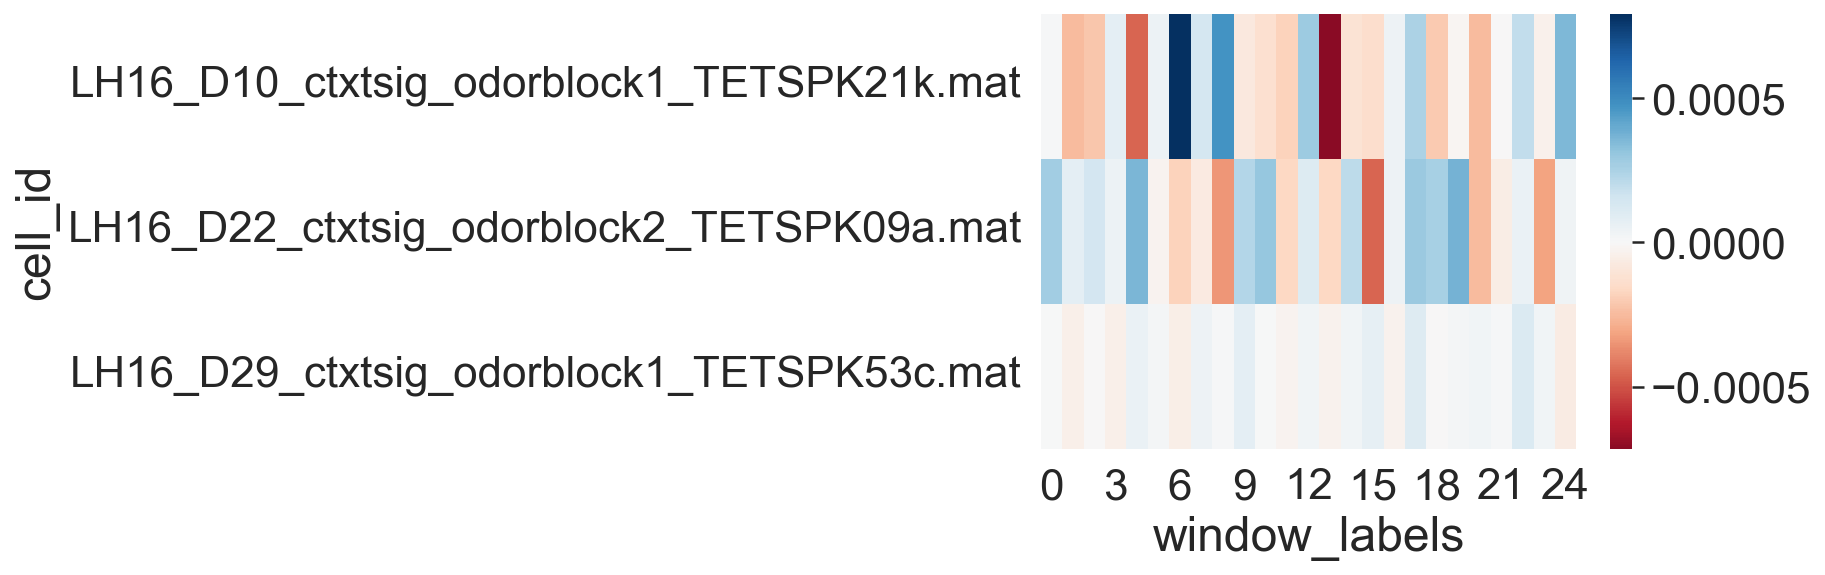

In [89]:
sns.heatmap(tmp3,cmap="RdBu",center=0)

In [5]:
# loss_delta_df = pd.concat(loss_delta_tmp)
loss_delta_df.to_csv('inprogress_loss_delta_theta_lowgamma_cells67to73.csv')
# loss_delta_df.to_csv('inprogress_loss_delta_theta_lowgamma_cells0to57.csv')

In [6]:
set(loss_delta_df['cell_id'].to_list())

{'LH16_08_22_14_D29_theta_correct_odorblock2TETSPK53c',
 'LH2_11_20_12_D11_theta_correct_odorblock1TETSPK05a',
 'LH2_11_27_12_D14_theta_correct_odorblock1TETSPK41d',
 'LH9_10_08_13_D09_theta_correct_odorblock1TETSPK21b',
 'LH9_10_08_13_D09_theta_correct_odorblock2TETSPK53b',
 'LH9_10_10_13_D10_theta_correct_odorblock1TETSPK53b',
 'LH9_10_15_13_D12_theta_correct_odorblock1TETSPK13a'}

In [9]:
tmp = loss_delta_df.reset_index()
tmp2 = tmp.groupby(['cell_id','window_labels']).mean()['delta_logloss_theta_minus_hshort'].reset_index()
tmp3 = tmp2.pivot("cell_id","window_labels","delta_logloss_theta_minus_hshort")

tmp = loss_delta_df.reset_index()
tmp2 = tmp.groupby(['cell_id','window_labels']).mean()['delta_logloss_theta_minus_lowgamma'].reset_index()
tmp3 = tmp2.pivot("cell_id","window_labels","delta_logloss_theta_minus_lowgamma")

# tmp = loss_delta_df.reset_index()
# tmp2 = tmp.groupby(['cell_id','window_labels']).mean()['delta_logloss_lowgamma_minus_hshort'].reset_index()
# tmp3 = tmp2.pivot("cell_id","window_labels","delta_logloss_lowgamma_minus_hshort")

<AxesSubplot:xlabel='window_labels', ylabel='cell_id'>

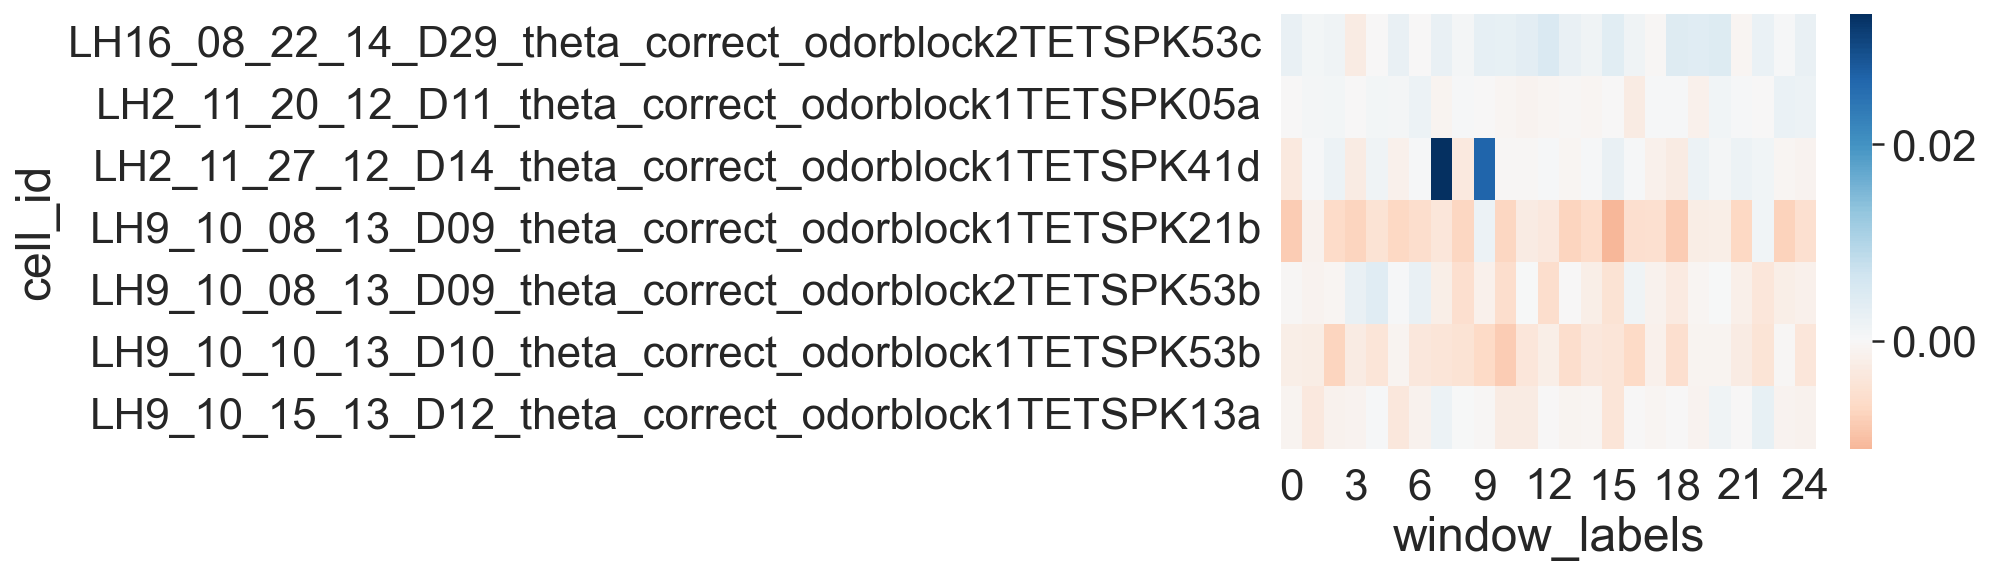

In [10]:
sns.heatmap(tmp3,cmap="RdBu",center=0)

In [11]:
df1 = pd.read_csv('inprogress_loss_delta_theta_lowgamma_cells0to57.csv')
df2 = pd.read_csv('inprogress_loss_delta_theta_lowgamma_cells57to66.csv')
df3 = pd.read_csv('inprogress_loss_delta_theta_lowgamma_cells67to73.csv')
df4 = pd.read_csv('inprogress_loss_delta_theta_lowgamma_cells74onward.csv')

In [20]:
fulldf = pd.concat([df1,df2,df3,df4])

In [28]:
tmp = fulldf.reset_index()
tmp2 = tmp.groupby(['cell_id','window_labels']).mean()['delta_logloss_theta_minus_hshort'].reset_index()
tmp3 = tmp2.pivot("cell_id","window_labels","delta_logloss_theta_minus_hshort")

tmp = fulldf.reset_index()
tmp2 = tmp.groupby(['cell_id','window_labels']).mean()['delta_logloss_theta_minus_lowgamma'].reset_index()
tmp3 = tmp2.pivot("cell_id","window_labels","delta_logloss_theta_minus_lowgamma")

# tmp = fulldf.reset_index()
# tmp2 = tmp.groupby(['cell_id','window_labels']).mean()['delta_logloss_lowgamma_minus_hshort'].reset_index()
# tmp3 = tmp2.pivot("cell_id","window_labels","delta_logloss_lowgamma_minus_hshort")

<AxesSubplot:xlabel='window_labels', ylabel='cell_id'>

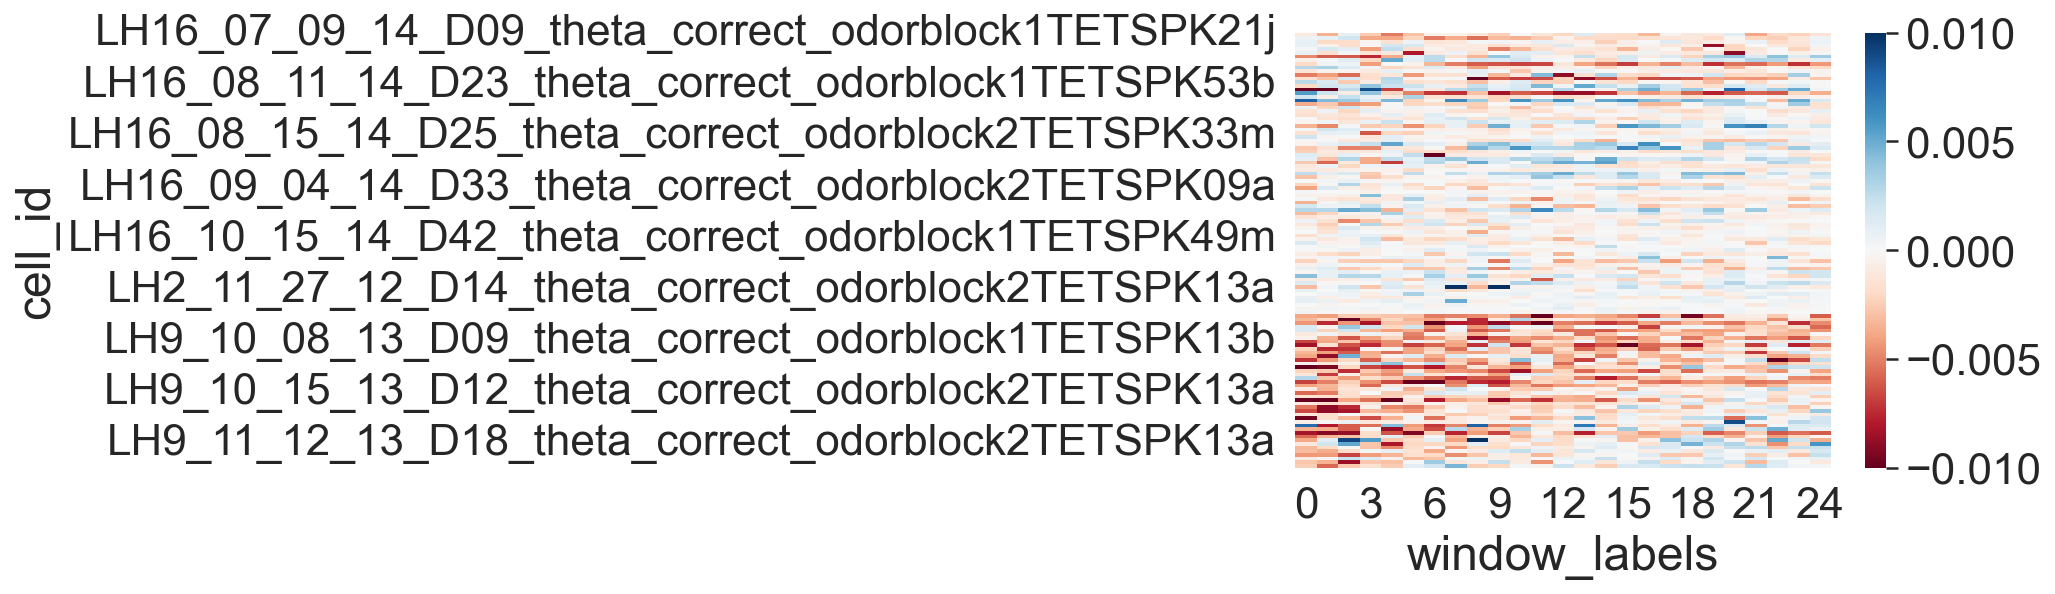

In [30]:
sns.heatmap(tmp3,cmap="RdBu",center=0,vmin=-0.01,vmax=0.01)

In [5]:
loss_delta_df

cell_id  \
0   LH16_08_11_14_D23_theta_correct_odorblock2TETSPK09c   
1   LH16_08_11_14_D23_theta_correct_odorblock2TETSPK09c   
2   LH16_08_11_14_D23_theta_correct_odorblock2TETSPK09c   
3   LH16_08_11_14_D23_theta_correct_odorblock2TETSPK09c   
4   LH16_08_11_14_D23_theta_correct_odorblock2TETSPK09c   
..                                                  ...   
20  LH16_08_11_14_D23_theta_correct_odorblock2TETSPK09c   
21  LH16_08_11_14_D23_theta_correct_odorblock2TETSPK09c   
22  LH16_08_11_14_D23_theta_correct_odorblock2TETSPK09c   
23  LH16_08_11_14_D23_theta_correct_odorblock2TETSPK09c   
24  LH16_08_11_14_D23_theta_correct_odorblock2TETSPK09c   

    delta_logloss_theta_minus_lowgamma  delta_logloss_theta_minus_hshort  \
0                            -0.015582                         -0.011977   
1                            -0.005549                         -0.007289   
2                             0.001982                         -0.006607   
3                             0.004260                         -0.001274   
4                            -0.008616                         -0.007046   
..                                 ...                               ...   
20                            0.012722                          0.001640   
21                            0.000697                         -0.004000   
22                            0.001670                          0.002541   
23                            0.009635                          0.001981   
24                            0.001771                         -0.000138   

    delta_logloss_lowgamma_minus_hshort  window_labels  fold  
0                              0.003605              0     0  
1                             -0.001740              1     0  
2                             -0.008589              2     0  
3                             -0.005534              3     0  
4                              0.001570              4     0  
..                                  ...            ...   ...  
20                            -0.011082             20    19  
21                            -0.004697             21    19  
22                             0.000871             22    19  
23                            -0.007654             23    19  
24                            -0.001909             24    19  

[500 rows x 6 columns]

stopped at cell index 74, cells 0:73 don't have the hshort based deltas

In [17]:
tmp = loss_delta_df.reset_index()
tmp2 = tmp.groupby(['cell_id','window_labels']).mean()['delta_logloss_theta_minus_hshort'].reset_index()
tmp3 = tmp2.pivot("cell_id","window_labels","delta_logloss_theta_minus_hshort")

tmp = loss_delta_df.reset_index()
tmp2 = tmp.groupby(['cell_id','window_labels']).mean()['delta_logloss_theta_minus_lowgamma'].reset_index()
tmp3 = tmp2.pivot("cell_id","window_labels","delta_logloss_theta_minus_lowgamma")

tmp = loss_delta_df.reset_index()
tmp2 = tmp.groupby(['cell_id','window_labels']).mean()['delta_logloss_lowgamma_minus_hshort'].reset_index()
tmp3 = tmp2.pivot("cell_id","window_labels","delta_logloss_lowgamma_minus_hshort")

<AxesSubplot:xlabel='window_labels', ylabel='cell_id'>

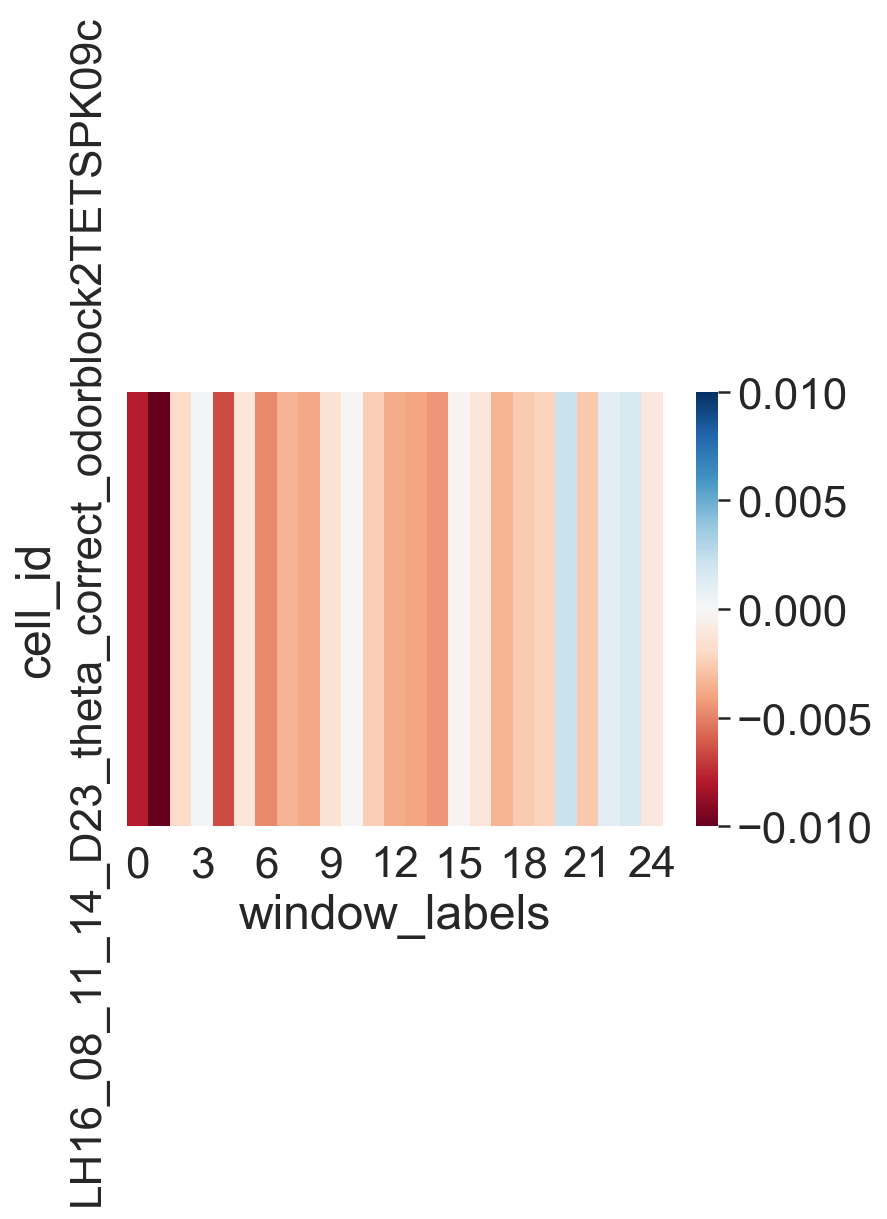

In [12]:
sns.heatmap(tmp3,cmap="RdBu",center=0, vmin =-0.01, vmax=0.01)


<AxesSubplot:xlabel='window_labels', ylabel='cell_id'>

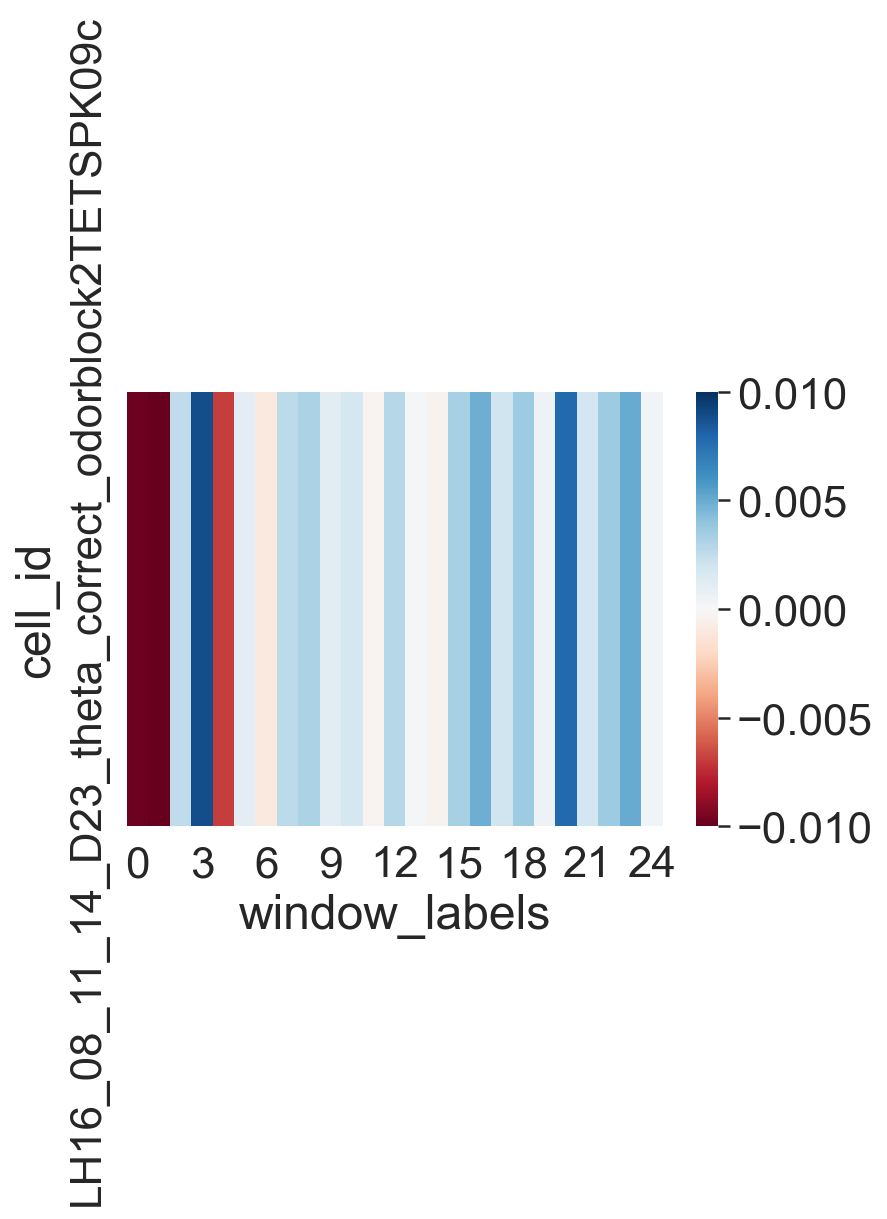

In [16]:
sns.heatmap(tmp3,cmap="RdBu",center=0, vmin =-0.01, vmax=0.01)


<AxesSubplot:xlabel='window_labels', ylabel='cell_id'>

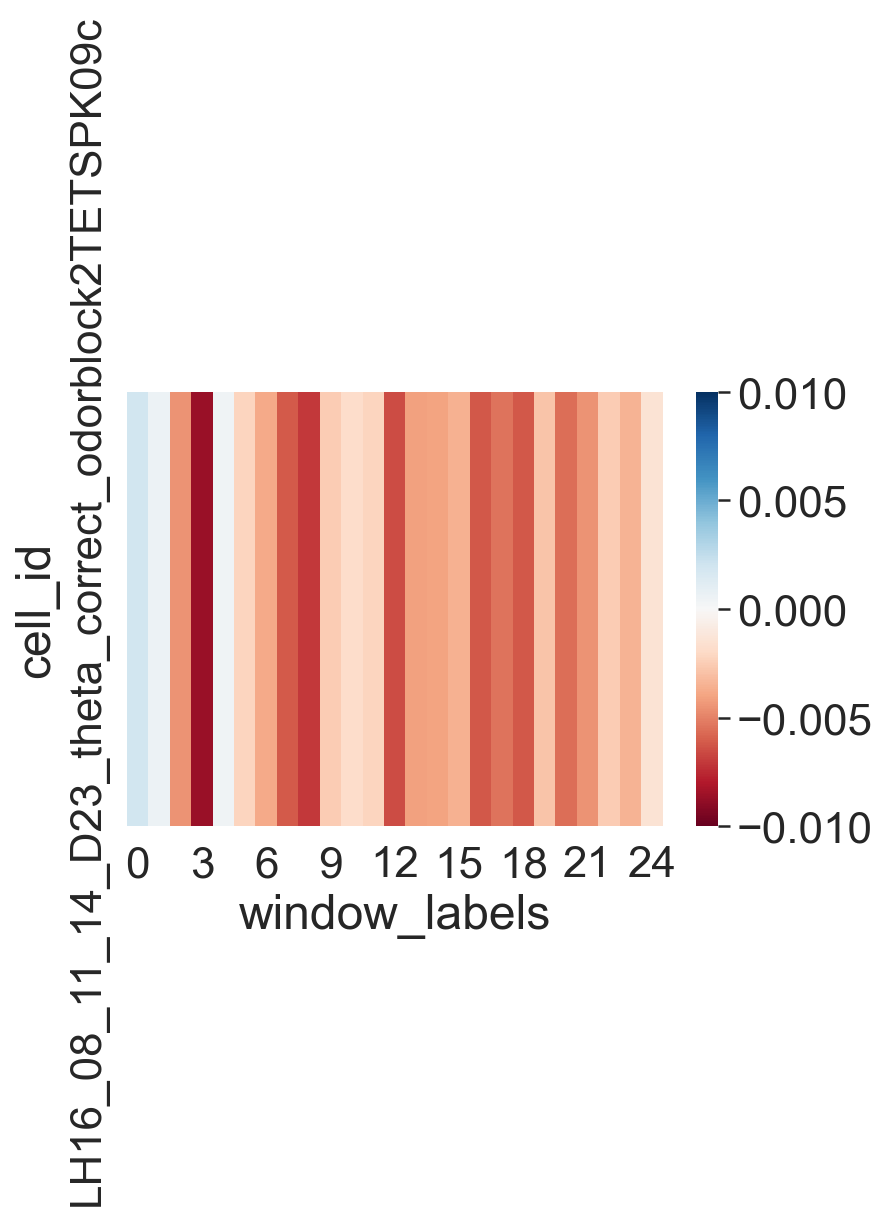

In [18]:
sns.heatmap(tmp3,cmap="RdBu",center=0, vmin =-0.01, vmax=0.01)


In [61]:
loss_delta_df = pd.concat(loss_delta_tmp)
# loss_delta_df.to_csv('inprogress_loss_delta_theta_lowgamma.csv')

In [62]:
loss_delta_df


cell_id  \
0   LH16_08_11_14_D23_theta_correct_odorblock2TETSPK09c   
1   LH16_08_11_14_D23_theta_correct_odorblock2TETSPK09c   
2   LH16_08_11_14_D23_theta_correct_odorblock2TETSPK09c   
3   LH16_08_11_14_D23_theta_correct_odorblock2TETSPK09c   
4   LH16_08_11_14_D23_theta_correct_odorblock2TETSPK09c   
..                                                  ...   
20  LH16_08_08_14_D22_theta_correct_odorblock1TETSPK29g   
21  LH16_08_08_14_D22_theta_correct_odorblock1TETSPK29g   
22  LH16_08_08_14_D22_theta_correct_odorblock1TETSPK29g   
23  LH16_08_08_14_D22_theta_correct_odorblock1TETSPK29g   
24  LH16_08_08_14_D22_theta_correct_odorblock1TETSPK29g   

    delta_logloss_theta_minus_lowgamma  window_labels  fold  
0                            -0.015582              0     0  
1                            -0.005549              1     0  
2                             0.001982              2     0  
3                             0.004260              3     0  
4                            -0.008616              4     0  
..                                 ...            ...   ...  
20                           -0.002644             20     8  
21                           -0.001180             21     8  
22                           -0.000877             22     8  
23                           -0.003917             23     8  
24                            0.000781             24     8  

[37225 rows x 4 columns]

In [46]:
loss_delta_df

cell_id  \
0   LH16_08_22_14_D29_theta_correct_odorblock2TETSPK53c   
1   LH16_08_22_14_D29_theta_correct_odorblock2TETSPK53c   
2   LH16_08_22_14_D29_theta_correct_odorblock2TETSPK53c   
3   LH16_08_22_14_D29_theta_correct_odorblock2TETSPK53c   
4   LH16_08_22_14_D29_theta_correct_odorblock2TETSPK53c   
..                                                  ...   
20  LH16_08_08_14_D22_theta_correct_odorblock2TETSPK09a   
21  LH16_08_08_14_D22_theta_correct_odorblock2TETSPK09a   
22  LH16_08_08_14_D22_theta_correct_odorblock2TETSPK09a   
23  LH16_08_08_14_D22_theta_correct_odorblock2TETSPK09a   
24  LH16_08_08_14_D22_theta_correct_odorblock2TETSPK09a   

    delta_logloss_theta_minus_lowgamma  window_labels  fold  
0                             0.002269              0     0  
1                            -0.000622              1     0  
2                             0.002097              2     0  
3                            -0.002567              3     0  
4                            -0.002255              4     0  
..                                 ...            ...   ...  
20                            0.001221             20    19  
21                           -0.001470             21    19  
22                            0.002984             22    19  
23                            0.000713             23    19  
24                            0.001559             24    19  

[1500 rows x 4 columns]

In [47]:
tmp = loss_delta_df.reset_index()

In [48]:
tmp2 = tmp.groupby(['cell_id','window_labels']).mean()['delta_logloss_theta_minus_lowgamma'].reset_index()

In [49]:
tmp3 = tmp2.pivot("cell_id","window_labels","delta_logloss_theta_minus_lowgamma")

<AxesSubplot:xlabel='window_labels', ylabel='cell_id'>

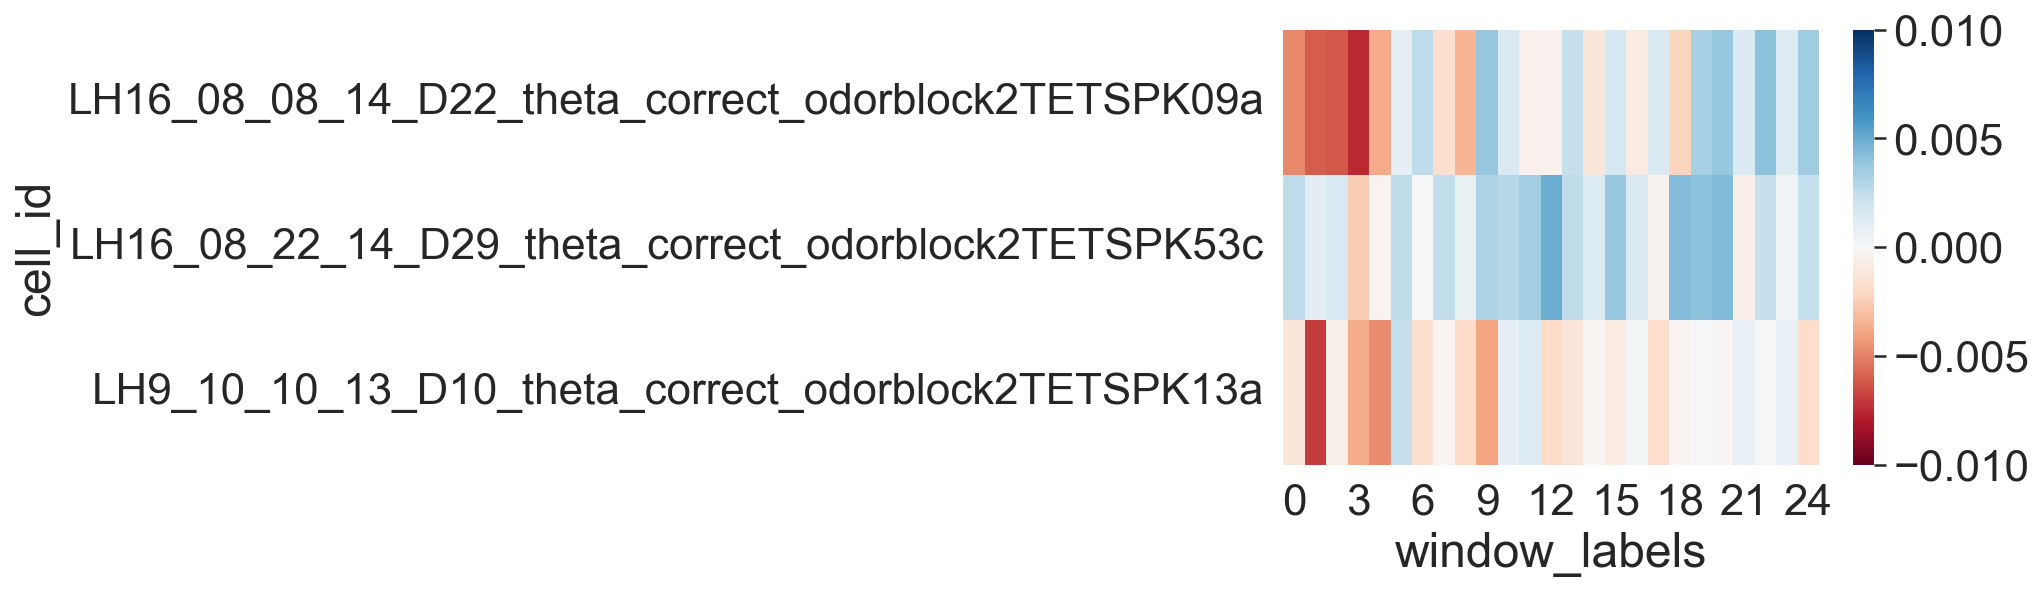

In [52]:
sns.heatmap(tmp3,cmap='RdBu',center=0,vmin =-0.01, vmax=0.01)

In [53]:
unite = pd.concat([tmp2,tst2])

In [55]:
unite2 = unite.pivot("cell_id","window_labels","delta_logloss_theta_minus_lowgamma")

<AxesSubplot:xlabel='window_labels', ylabel='cell_id'>

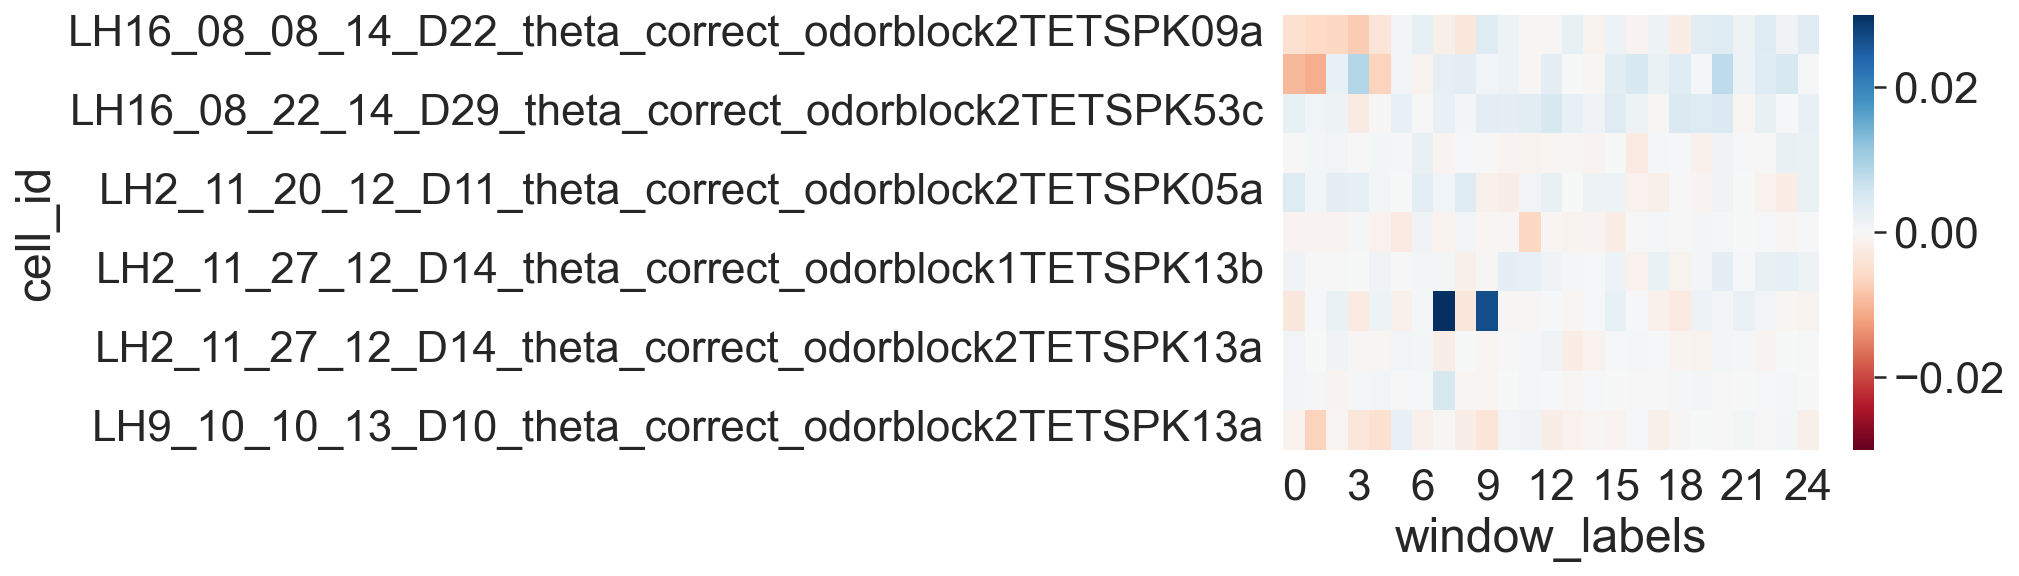

In [58]:
sns.heatmap(unite2,cmap='RdBu',center=0,vmin=-0.03, vmax=0.03)

In [59]:
tst2

cell_id  window_labels  \
0    LH16_08_11_14_D23_theta_correct_odorblock2TETSPK09c              0   
1    LH16_08_11_14_D23_theta_correct_odorblock2TETSPK09c              1   
2    LH16_08_11_14_D23_theta_correct_odorblock2TETSPK09c              2   
3    LH16_08_11_14_D23_theta_correct_odorblock2TETSPK09c              3   
4    LH16_08_11_14_D23_theta_correct_odorblock2TETSPK09c              4   
..                                                   ...            ...   
195   LH3_11_19_12_D20_theta_correct_odorblock1TETSPK61a             20   
196   LH3_11_19_12_D20_theta_correct_odorblock1TETSPK61a             21   
197   LH3_11_19_12_D20_theta_correct_odorblock1TETSPK61a             22   
198   LH3_11_19_12_D20_theta_correct_odorblock1TETSPK61a             23   
199   LH3_11_19_12_D20_theta_correct_odorblock1TETSPK61a             24   

     delta_logloss_theta_minus_lowgamma  
0                             -0.009792  
1                             -0.010858  
2                              0.002573  
3                              0.008902  
4                             -0.006932  
..                                  ...  
195                           -0.000086  
196                            0.000066  
197                            0.000446  
198                            0.000649  
199                            0.000216  

[200 rows x 3 columns]

In [16]:
loss_delta_df= pd.concat(loss_delta_tmp)

In [17]:
loss_delta_df

cell_id  \
0   LH16_08_11_14_D23_theta_correct_odorblock2TETSPK09c   
1   LH16_08_11_14_D23_theta_correct_odorblock2TETSPK09c   
2   LH16_08_11_14_D23_theta_correct_odorblock2TETSPK09c   
3   LH16_08_11_14_D23_theta_correct_odorblock2TETSPK09c   
4   LH16_08_11_14_D23_theta_correct_odorblock2TETSPK09c   
..                                                  ...   
20   LH2_11_27_12_D14_theta_correct_odorblock2TETSPK13a   
21   LH2_11_27_12_D14_theta_correct_odorblock2TETSPK13a   
22   LH2_11_27_12_D14_theta_correct_odorblock2TETSPK13a   
23   LH2_11_27_12_D14_theta_correct_odorblock2TETSPK13a   
24   LH2_11_27_12_D14_theta_correct_odorblock2TETSPK13a   

    delta_logloss_theta_minus_lowgamma  window_labels  fold  
0                            -0.015582              0     0  
1                            -0.005549              1     0  
2                             0.001982              2     0  
3                             0.004260              3     0  
4                            -0.008616              4     0  
..                                 ...            ...   ...  
20                            0.000763             20     0  
21                            0.000524             21     0  
22                           -0.000897             22     0  
23                            0.000206             23     0  
24                            0.000260             24     0  

[3525 rows x 4 columns]

In [18]:
tst = loss_delta_df.reset_index()

In [31]:
tst2 = tst.groupby(['cell_id','window_labels']).mean()['delta_logloss_theta_minus_lowgamma'].reset_index()
# tst2 = tst.pivot("cell_id","window_labels","delta_logloss_theta_minus_lowgamma")

In [34]:
tst3 = tst2.pivot("cell_id","window_labels","delta_logloss_theta_minus_lowgamma")

<AxesSubplot:xlabel='window_labels', ylabel='cell_id'>

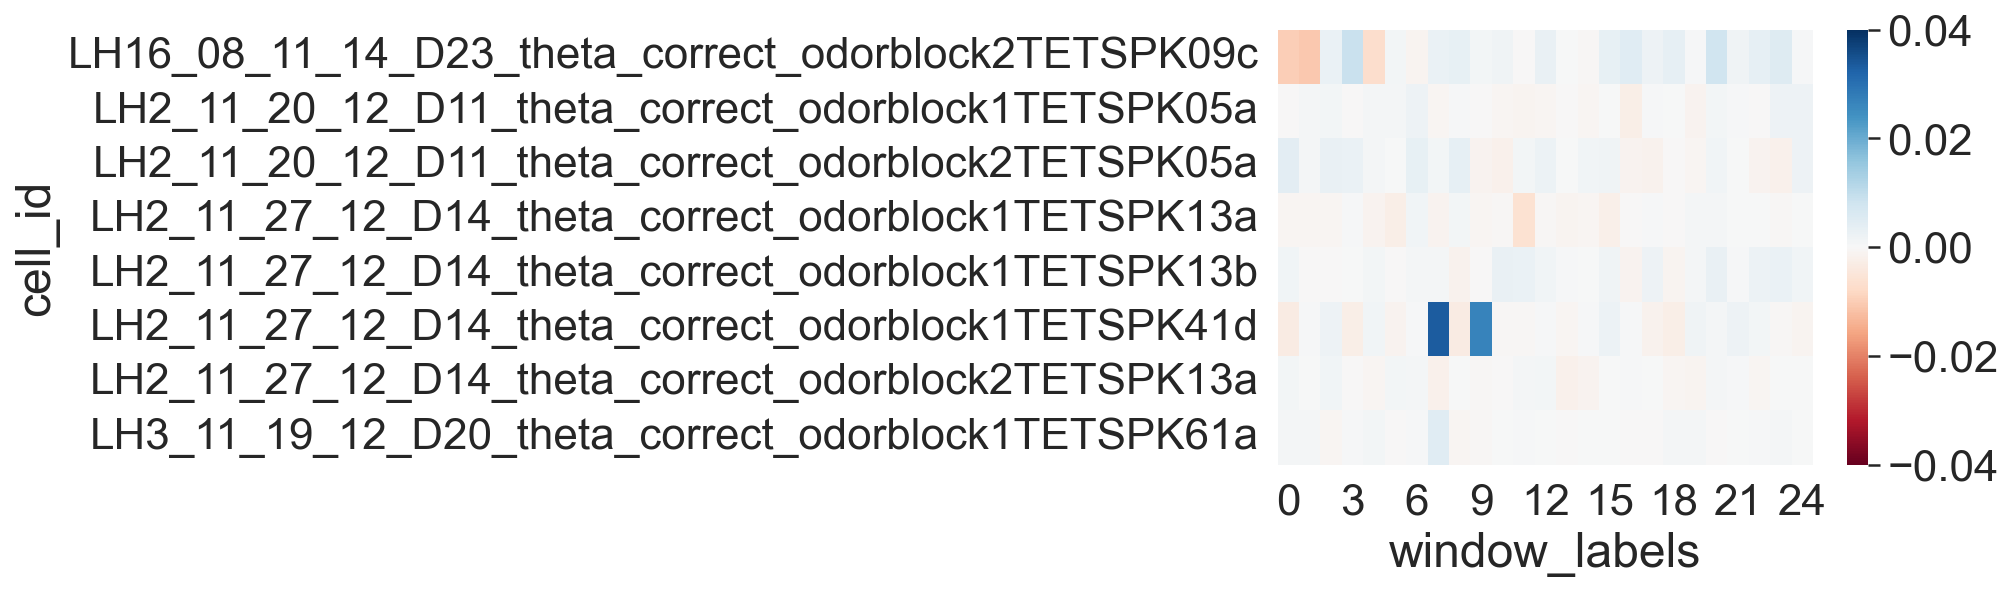

In [44]:
sns.heatmap(tst3, cmap="RdBu", center=0, vmin=-0.04, vmax=0.04)

In [73]:
cell_id = 'LH16_08_22_14_D29_theta_correct_odorblock2TETSPK53c'
datapath = 'RESULTS/PHASE_HIST_MODELS_all_realcells/intlogoddsCompleteSinglePredMdls940/'
rh_folders = os.listdir(datapath)



window_size = 50
window_slide = 50
model_subset = ['cshort']
rhythm_subset = ['theta','lowgamma']
loss_delta_tmp = []
for fold in range(20): 
    
    ptest, test = grab_probs_and_data(datapath,rh_folders,cell_id,fold,'probs_models_test.csv','test_data.csv')
    
    
    ll_ptest = compute_logloss_deltas(ptest, test, window_size, window_slide, model_subset, rhythm_subset)

    grouped_ptest = ll_ptest.groupby(['rhythm','trial_labels','window_labels']).mean()['logloss_cshort'].reset_index()
    grouped_ptest = ll_ptest.groupby(['rhythm','window_labels']).mean()['logloss_cshort'].reset_index()
    
    
    subthetaloss = grouped_ptest[grouped_ptest['rhythm'] == 'theta']
    sublowgammaloss = grouped_ptest[grouped_ptest['rhythm'] == 'lowgamma']
    delta = subthetaloss['logloss_cshort'].values - sublowgammaloss['logloss_cshort'].values
    
    
    tmp = {'delta_logloss_theta_minus_lowgamma': delta,
           'window_labels': sublowgammaloss['window_labels'].to_list(),
           'fold': np.repeat(fold,subthetaloss.shape[0])
                     }
    
    loss_delta_tmp.append(pd.DataFrame(tmp))
    
loss_delta_df = pd.concat(loss_delta_tmp)
    

  0%|                                                    | 0/21 [00:00<?, ?it/s]/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_1601/1014385923.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subptest['spikes'] = subtest['spikes']
/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_1601/1014385923.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subptest['phases'] = subtest['phase']
/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_1601/1014385923.py:76: SettingWithCopyWa

100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 40.55it/s]


In [89]:
tst = loss_delta_df.reset_index()

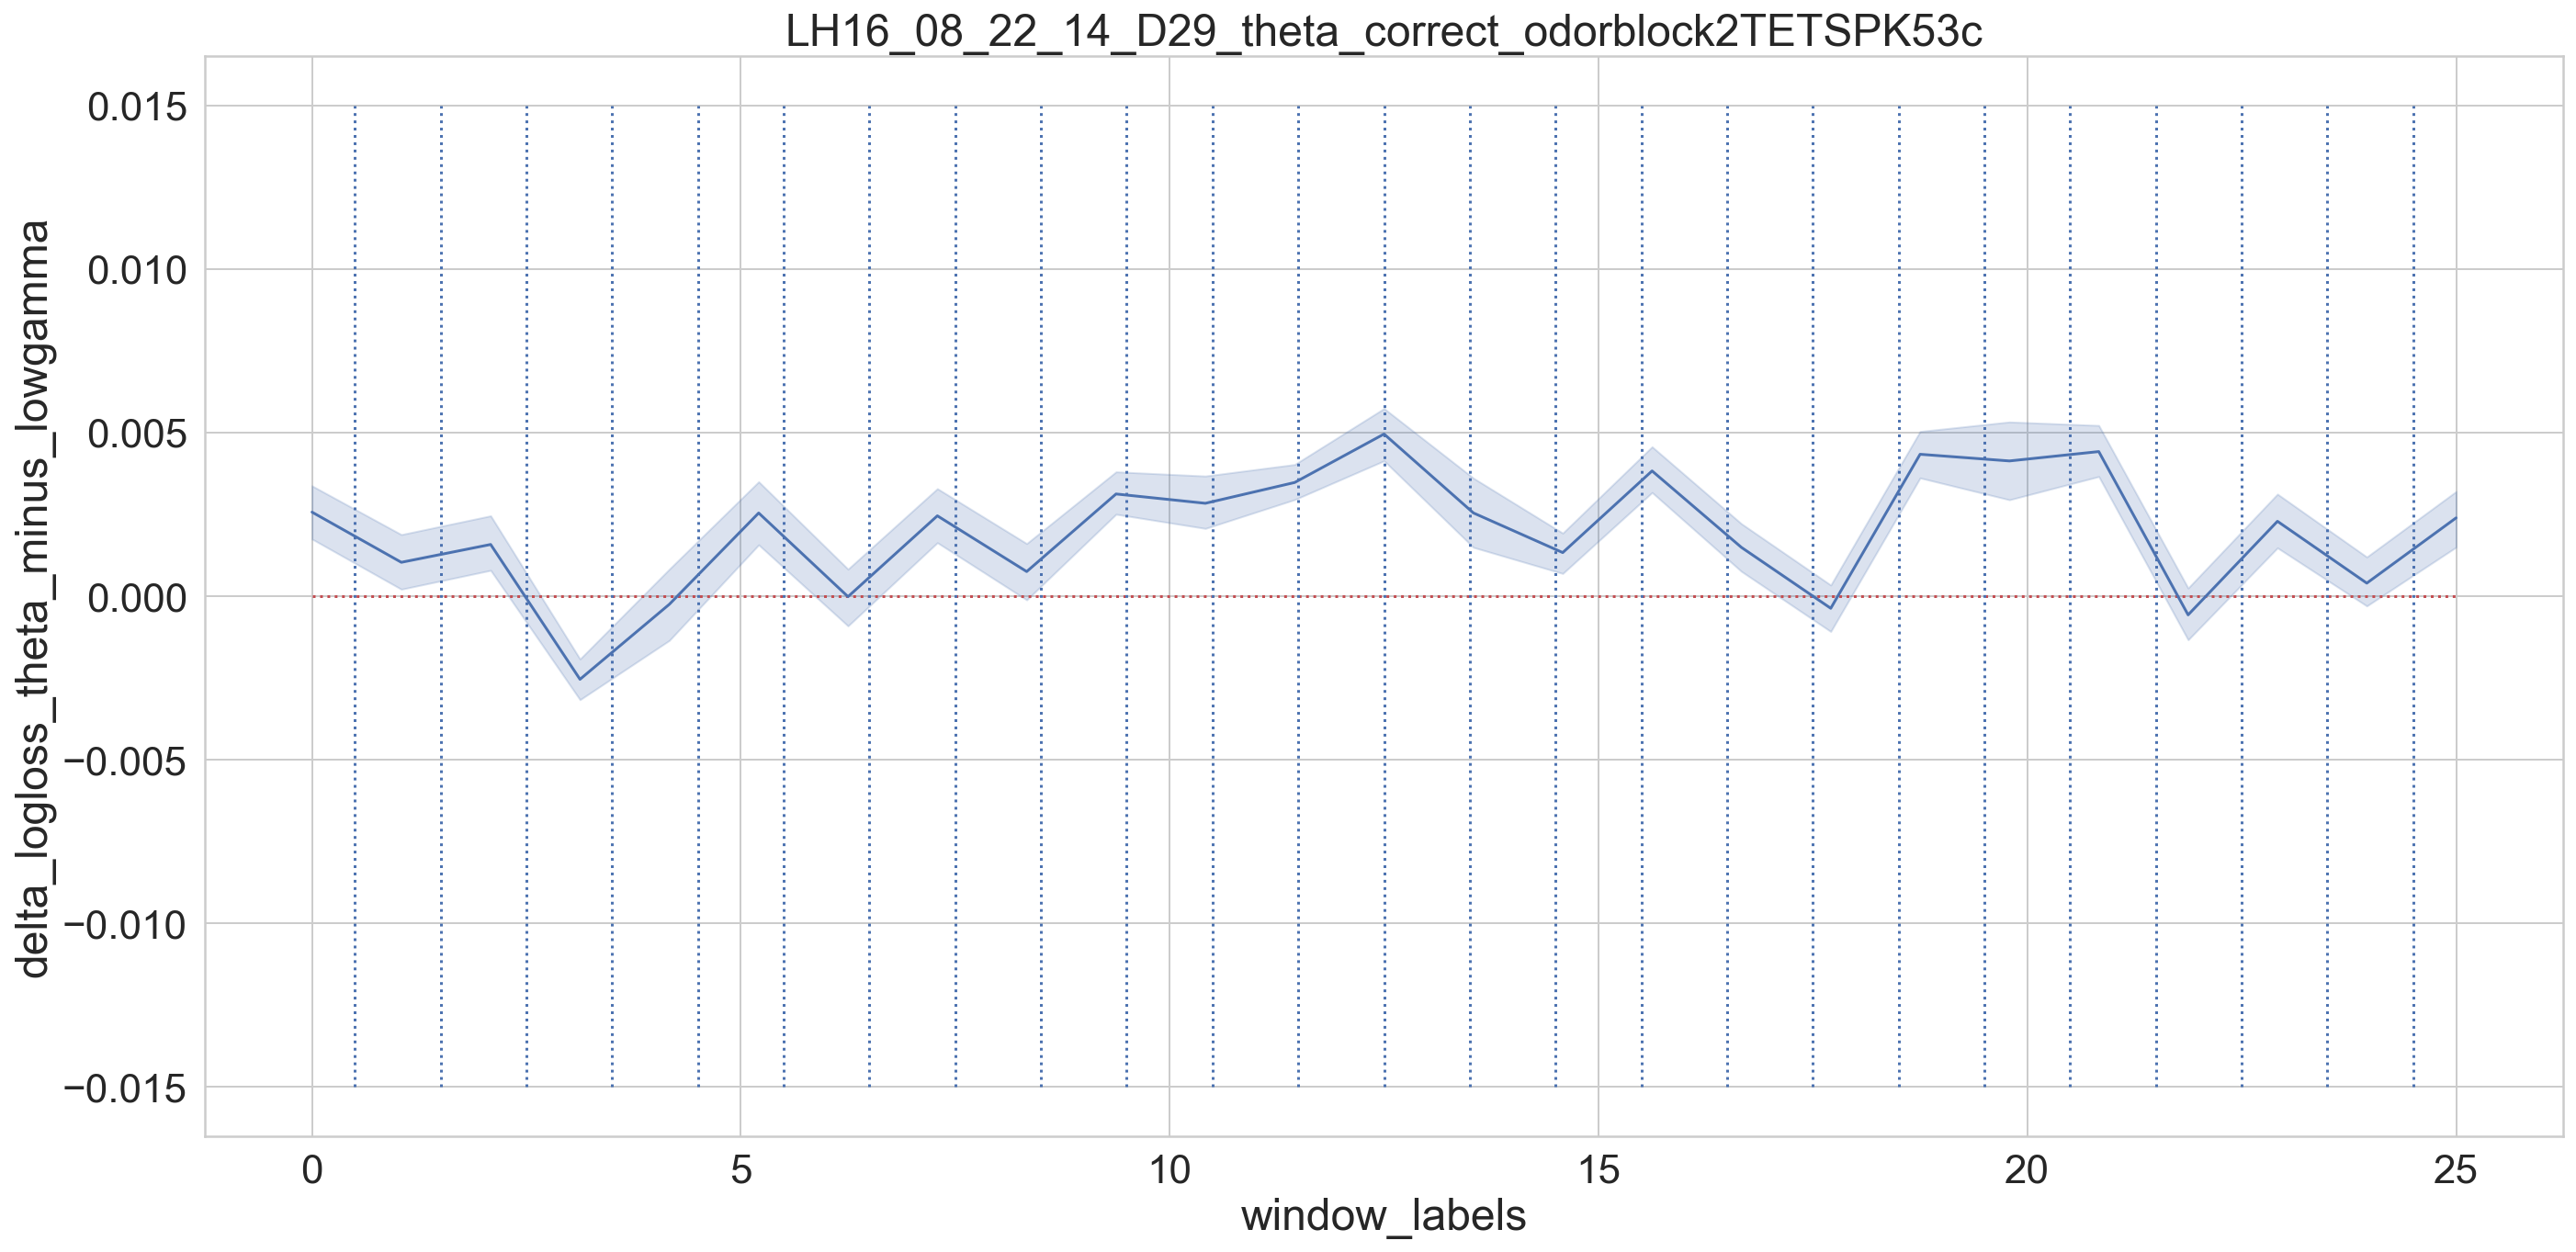

In [94]:
fig,ax=plt.subplots(figsize=(20,10))

# sns.scatterplot(x='window_labels',y='delta_logloss_theta_minus_lowgamma',data=subthetaloss,s=100)
sns.lineplot(x='window_labels',y='delta_logloss_theta_minus_lowgamma',data=tst)



ax.hlines(xmin=0,xmax=len(window_labels),y = 0,linestyle='dotted',color='r')
ax.vlines(x=[w+0.5 for w in window_labels], ymin=-0.015,ymax=0.015,linestyle='dotted')
ax.set_title(cell_id)
fig.tight_layout()


# fig.savefig(cell_id+'_fold'+str(fold)+'window_size'+str(window_size)+'window_slide'+str(window_slide)+'_loglossdeltas_'+logloss_model+'theta'+'lowgamma'+'.pdf')

In [95]:
cell_id = 'LH9_10_10_13_D10_theta_correct_odorblock2TETSPK13a'
datapath = 'RESULTS/PHASE_HIST_MODELS_all_realcells/intlogoddsCompleteSinglePredMdls940/'
rh_folders = os.listdir(datapath)

window_size = 50
window_slide = 50
model_subset = ['cshort']
rhythm_subset = ['theta','lowgamma']
loss_delta_tmp = []
for fold in range(20): 
    
    ptest, test = grab_probs_and_data(datapath,rh_folders,cell_id,fold,'probs_models_test.csv','test_data.csv')
    
    
    ll_ptest = compute_logloss_deltas(ptest, test, window_size, window_slide, model_subset, rhythm_subset)

    grouped_ptest = ll_ptest.groupby(['rhythm','trial_labels','window_labels']).mean()['logloss_cshort'].reset_index()
    grouped_ptest = ll_ptest.groupby(['rhythm','window_labels']).mean()['logloss_cshort'].reset_index()
    
    
    subthetaloss = grouped_ptest[grouped_ptest['rhythm'] == 'theta']
    sublowgammaloss = grouped_ptest[grouped_ptest['rhythm'] == 'lowgamma']
    delta = subthetaloss['logloss_cshort'].values - sublowgammaloss['logloss_cshort'].values
    
    
    tmp = {'delta_logloss_theta_minus_lowgamma': delta,
           'window_labels': sublowgammaloss['window_labels'].to_list(),
           'fold': np.repeat(fold,subthetaloss.shape[0])
                     }
    
    loss_delta_tmp.append(pd.DataFrame(tmp))
    
loss_delta_df = pd.concat(loss_delta_tmp)
    

  0%|                                                    | 0/20 [00:00<?, ?it/s]/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_1601/1014385923.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subptest['spikes'] = subtest['spikes']
/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_1601/1014385923.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subptest['phases'] = subtest['phase']
/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_1601/1014385923.py:76: SettingWithCopyWa

100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 45.81it/s]


In [96]:
tst = loss_delta_df.reset_index()

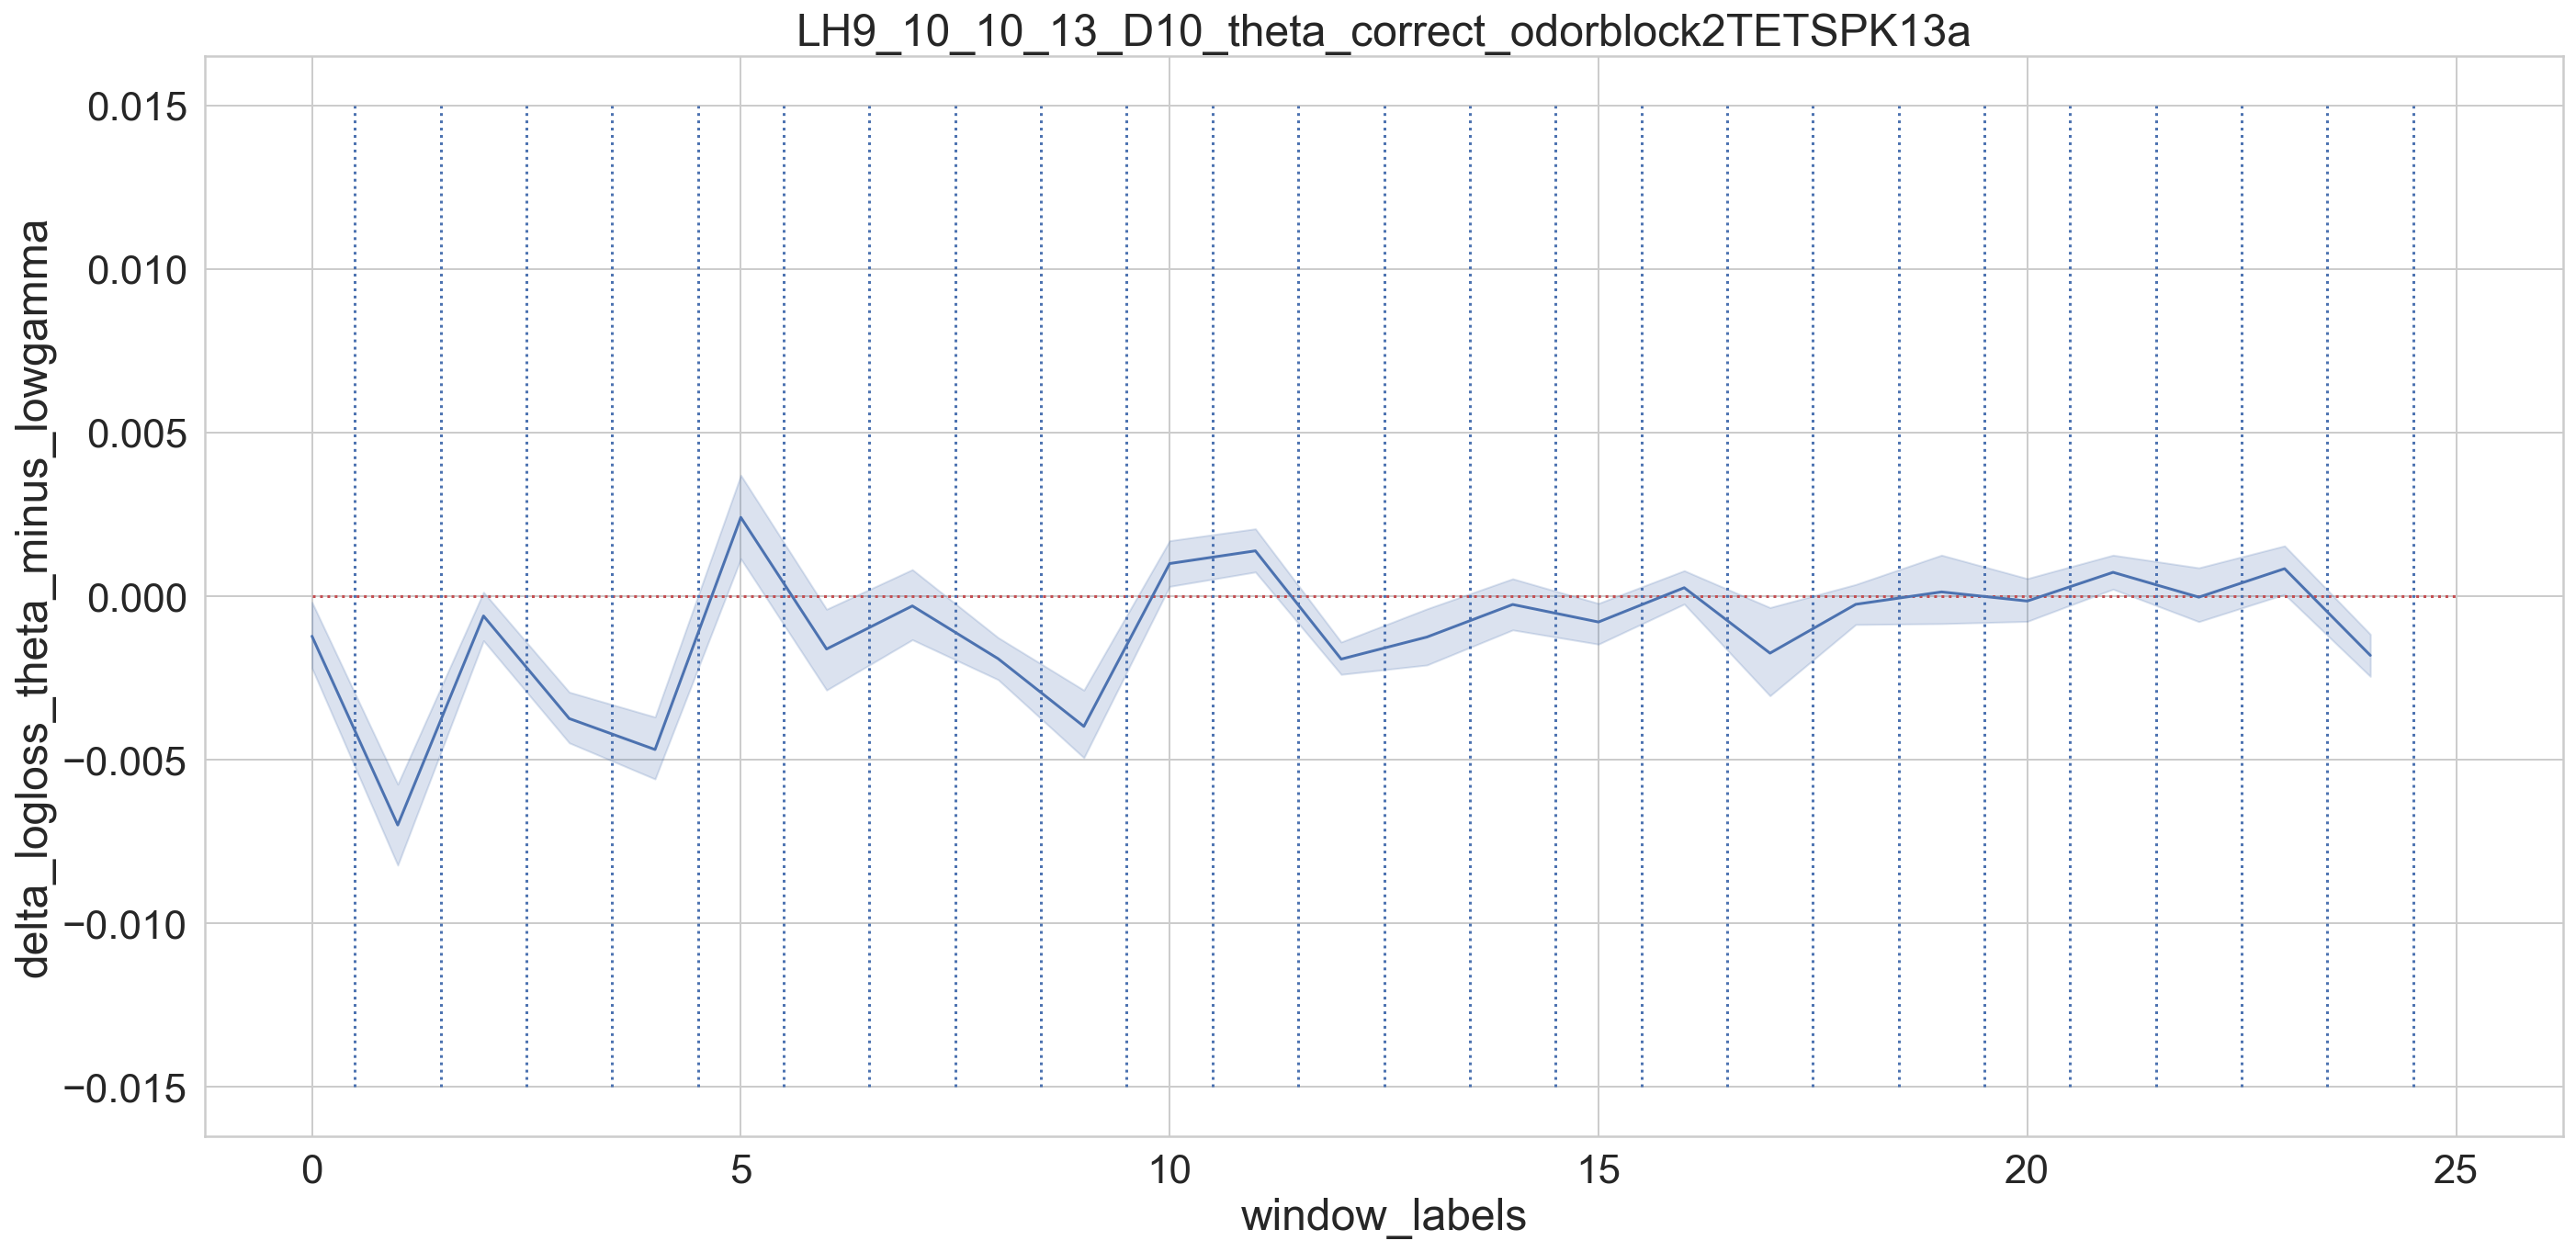

In [98]:
fig,ax=plt.subplots(figsize=(20,10))

# sns.scatterplot(x='window_labels',y='delta_logloss_theta_minus_lowgamma',data=subthetaloss,s=100)
sns.lineplot(x='window_labels',y='delta_logloss_theta_minus_lowgamma',data=tst)



ax.hlines(xmin=0,xmax=len(window_labels),y = 0,linestyle='dotted',color='r')
ax.vlines(x=[w+0.5 for w in window_labels], ymin=-0.015,ymax=0.015,linestyle='dotted')
ax.set_title(cell_id)
fig.tight_layout()


# fig.savefig(cell_id+'_fold'+str(fold)+'window_size'+str(window_size)+'window_slide'+str(window_slide)+'_loglossdeltas_'+logloss_model+'theta'+'lowgamma'+'.pdf')

In [99]:
cell_id = 'LH16_08_08_14_D22_theta_correct_odorblock2TETSPK09a'
datapath = 'RESULTS/PHASE_HIST_MODELS_all_realcells/intlogoddsCompleteSinglePredMdls940/'
rh_folders = os.listdir(datapath)

window_size = 50
window_slide = 50
model_subset = ['cshort']
rhythm_subset = ['theta','lowgamma']
loss_delta_tmp = []
for fold in range(20): 
    
    ptest, test = grab_probs_and_data(datapath,rh_folders,cell_id,fold,'probs_models_test.csv','test_data.csv')
    
    
    ll_ptest = compute_logloss_deltas(ptest, test, window_size, window_slide, model_subset, rhythm_subset)

    grouped_ptest = ll_ptest.groupby(['rhythm','trial_labels','window_labels']).mean()['logloss_cshort'].reset_index()
    grouped_ptest = ll_ptest.groupby(['rhythm','window_labels']).mean()['logloss_cshort'].reset_index()
    
    
    subthetaloss = grouped_ptest[grouped_ptest['rhythm'] == 'theta']
    sublowgammaloss = grouped_ptest[grouped_ptest['rhythm'] == 'lowgamma']
    delta = subthetaloss['logloss_cshort'].values - sublowgammaloss['logloss_cshort'].values
    
    
    tmp = {'delta_logloss_theta_minus_lowgamma': delta,
           'window_labels': sublowgammaloss['window_labels'].to_list(),
           'fold': np.repeat(fold,subthetaloss.shape[0])
                     }
    
    loss_delta_tmp.append(pd.DataFrame(tmp))
    
loss_delta_df = pd.concat(loss_delta_tmp)

  0%|                                                    | 0/19 [00:00<?, ?it/s]/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_1601/1014385923.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subptest['spikes'] = subtest['spikes']
/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_1601/1014385923.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subptest['phases'] = subtest['phase']
/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_1601/1014385923.py:76: SettingWithCopyWa

100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 43.73it/s]


In [100]:
tst = loss_delta_df.reset_index()

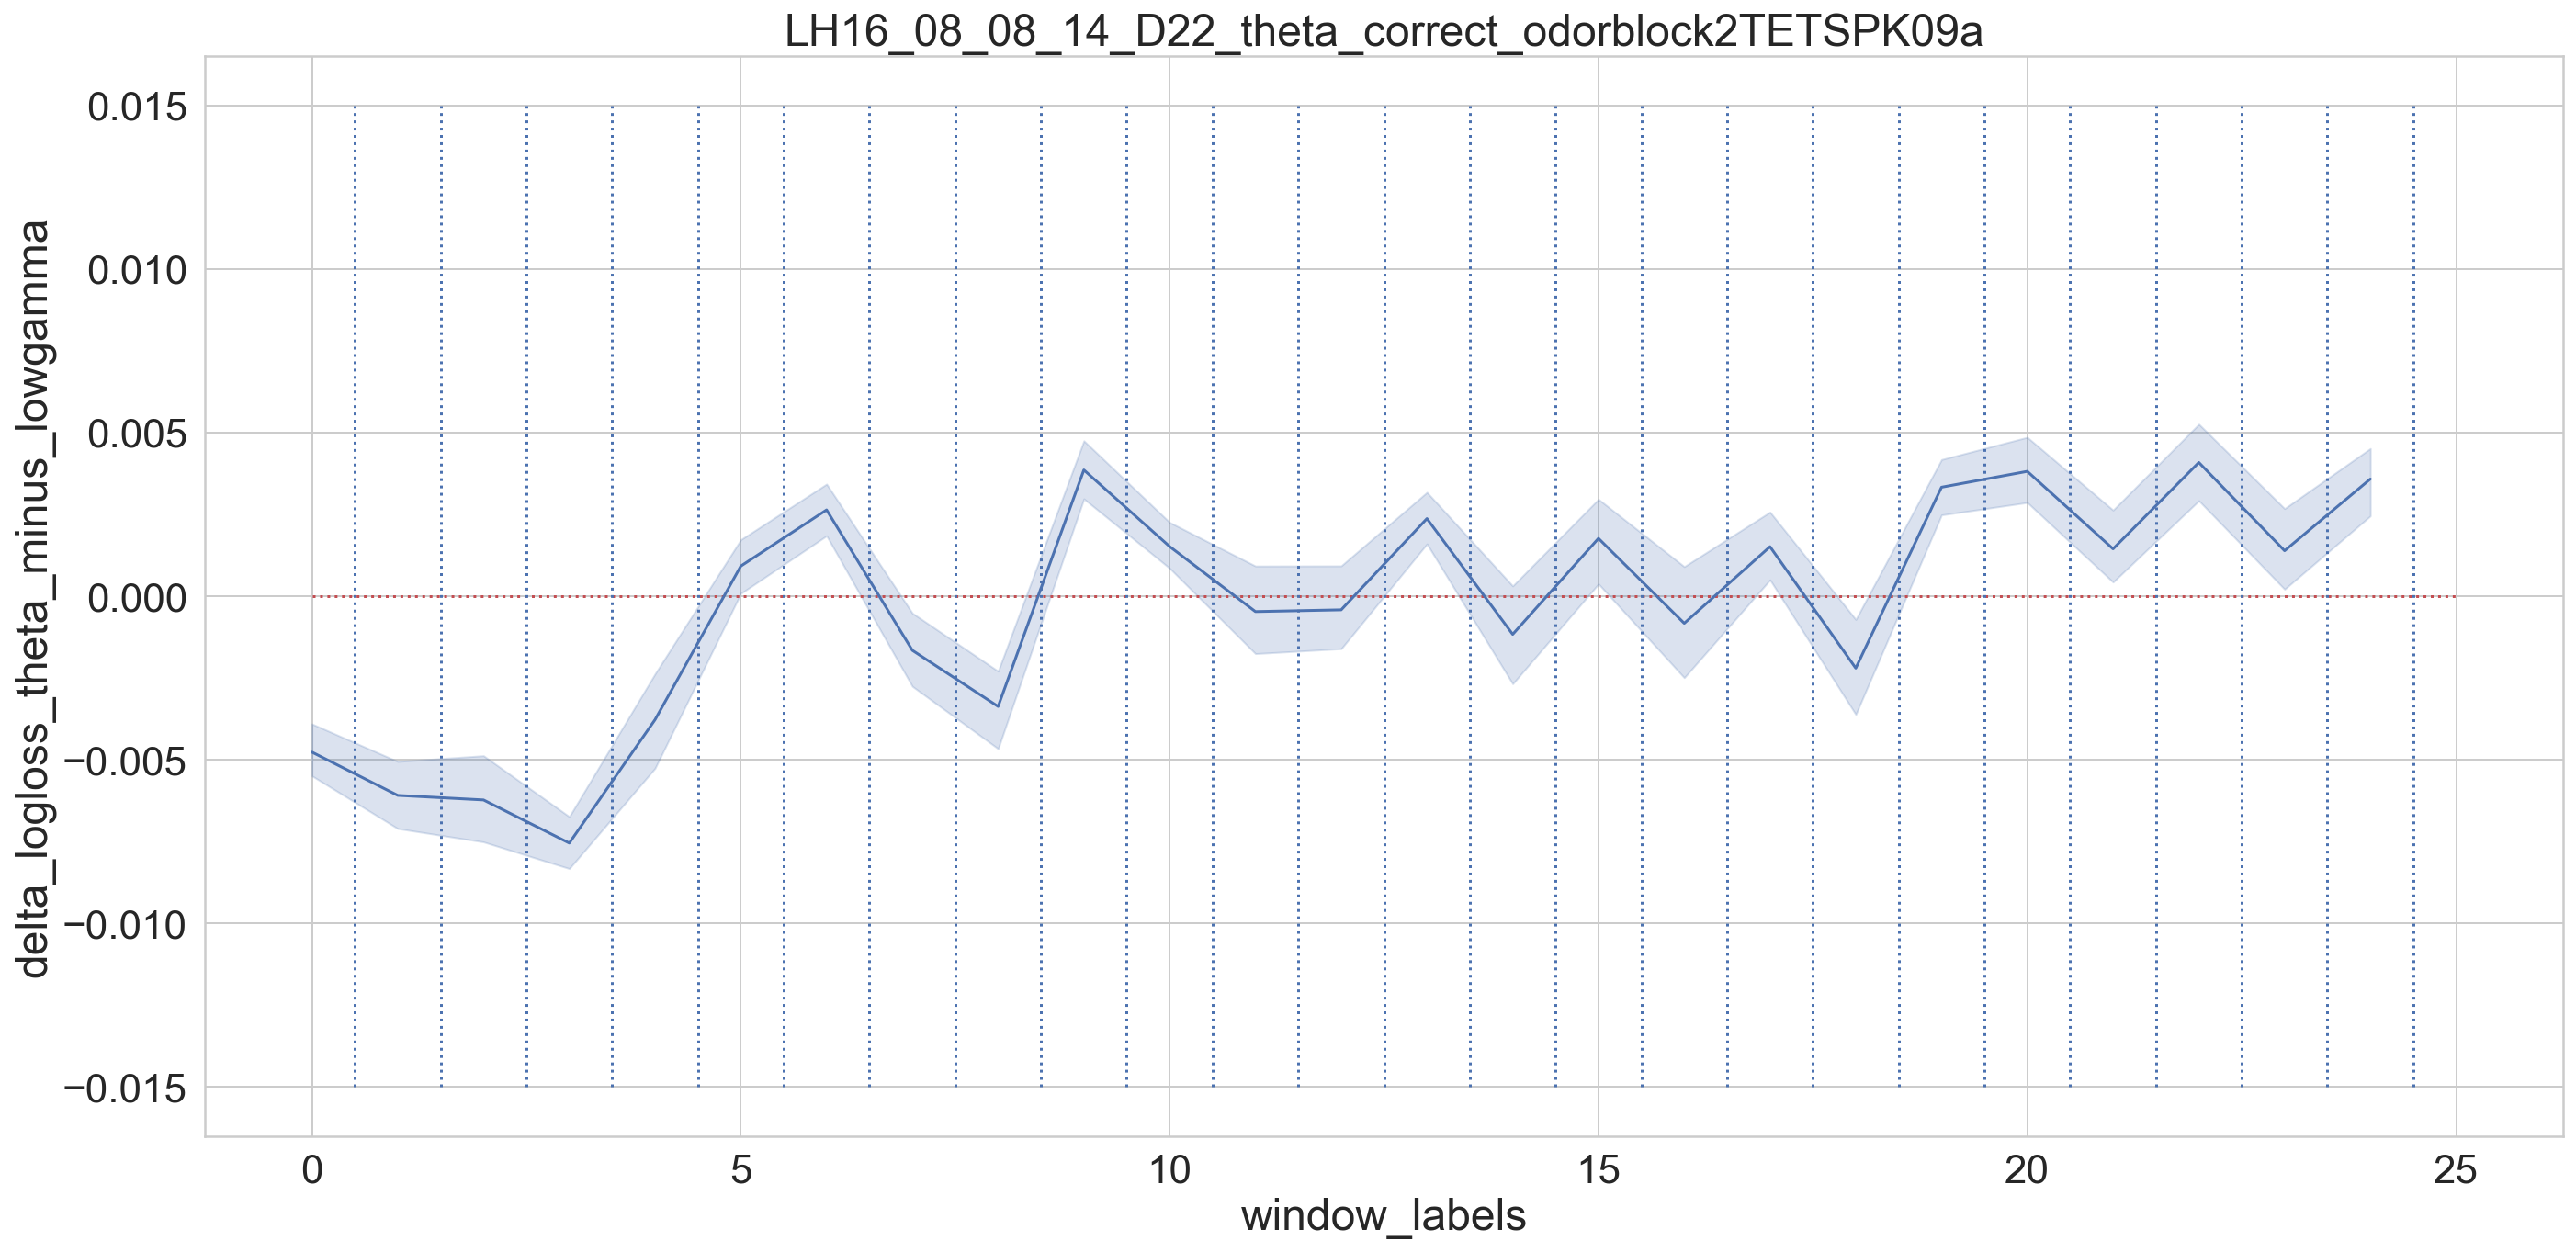

In [102]:
fig,ax=plt.subplots(figsize=(20,10))

# sns.scatterplot(x='window_labels',y='delta_logloss_theta_minus_lowgamma',data=subthetaloss,s=100)
sns.lineplot(x='window_labels',y='delta_logloss_theta_minus_lowgamma',data=tst)



ax.hlines(xmin=0,xmax=len(window_labels),y = 0,linestyle='dotted',color='r')
ax.vlines(x=[w+0.5 for w in window_labels], ymin=-0.015,ymax=0.015,linestyle='dotted')
ax.set_title(cell_id)
fig.tight_layout()



In [106]:
cell_id = 'LH16_08_15_14_D25_theta_correct_odorblock1TETSPK09a'
datapath = 'RESULTS/PHASE_HIST_MODELS_all_realcells/intlogoddsCompleteSinglePredMdls940/'
rh_folders = os.listdir(datapath)

window_size = 50
window_slide = 50
model_subset = ['cshort']
rhythm_subset = ['theta','lowgamma']
loss_delta_tmp = []
for fold in range(20): 
    
    ptest, test = grab_probs_and_data(datapath,rh_folders,cell_id,fold,'probs_models_test.csv','test_data.csv')
    
    
    ll_ptest = compute_logloss_deltas(ptest, test, window_size, window_slide, model_subset, rhythm_subset)

    grouped_ptest = ll_ptest.groupby(['rhythm','trial_labels','window_labels']).mean()['logloss_cshort'].reset_index()
    grouped_ptest = ll_ptest.groupby(['rhythm','window_labels']).mean()['logloss_cshort'].reset_index()
    
    
    subthetaloss = grouped_ptest[grouped_ptest['rhythm'] == 'theta']
    sublowgammaloss = grouped_ptest[grouped_ptest['rhythm'] == 'lowgamma']
    delta = subthetaloss['logloss_cshort'].values - sublowgammaloss['logloss_cshort'].values
    
    
    tmp = {'delta_logloss_theta_minus_lowgamma': delta,
           'window_labels': sublowgammaloss['window_labels'].to_list(),
           'fold': np.repeat(fold,subthetaloss.shape[0])
                     }
    
    loss_delta_tmp.append(pd.DataFrame(tmp))
    
loss_delta_df = pd.concat(loss_delta_tmp)

  0%|                                                    | 0/23 [00:00<?, ?it/s]/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_1601/1014385923.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subptest['spikes'] = subtest['spikes']
/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_1601/1014385923.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subptest['phases'] = subtest['phase']
/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_1601/1014385923.py:76: SettingWithCopyWa

100%|███████████████████████████████████████████| 23/23 [00:00<00:00, 36.70it/s]


In [107]:
tst = loss_delta_df.reset_index()

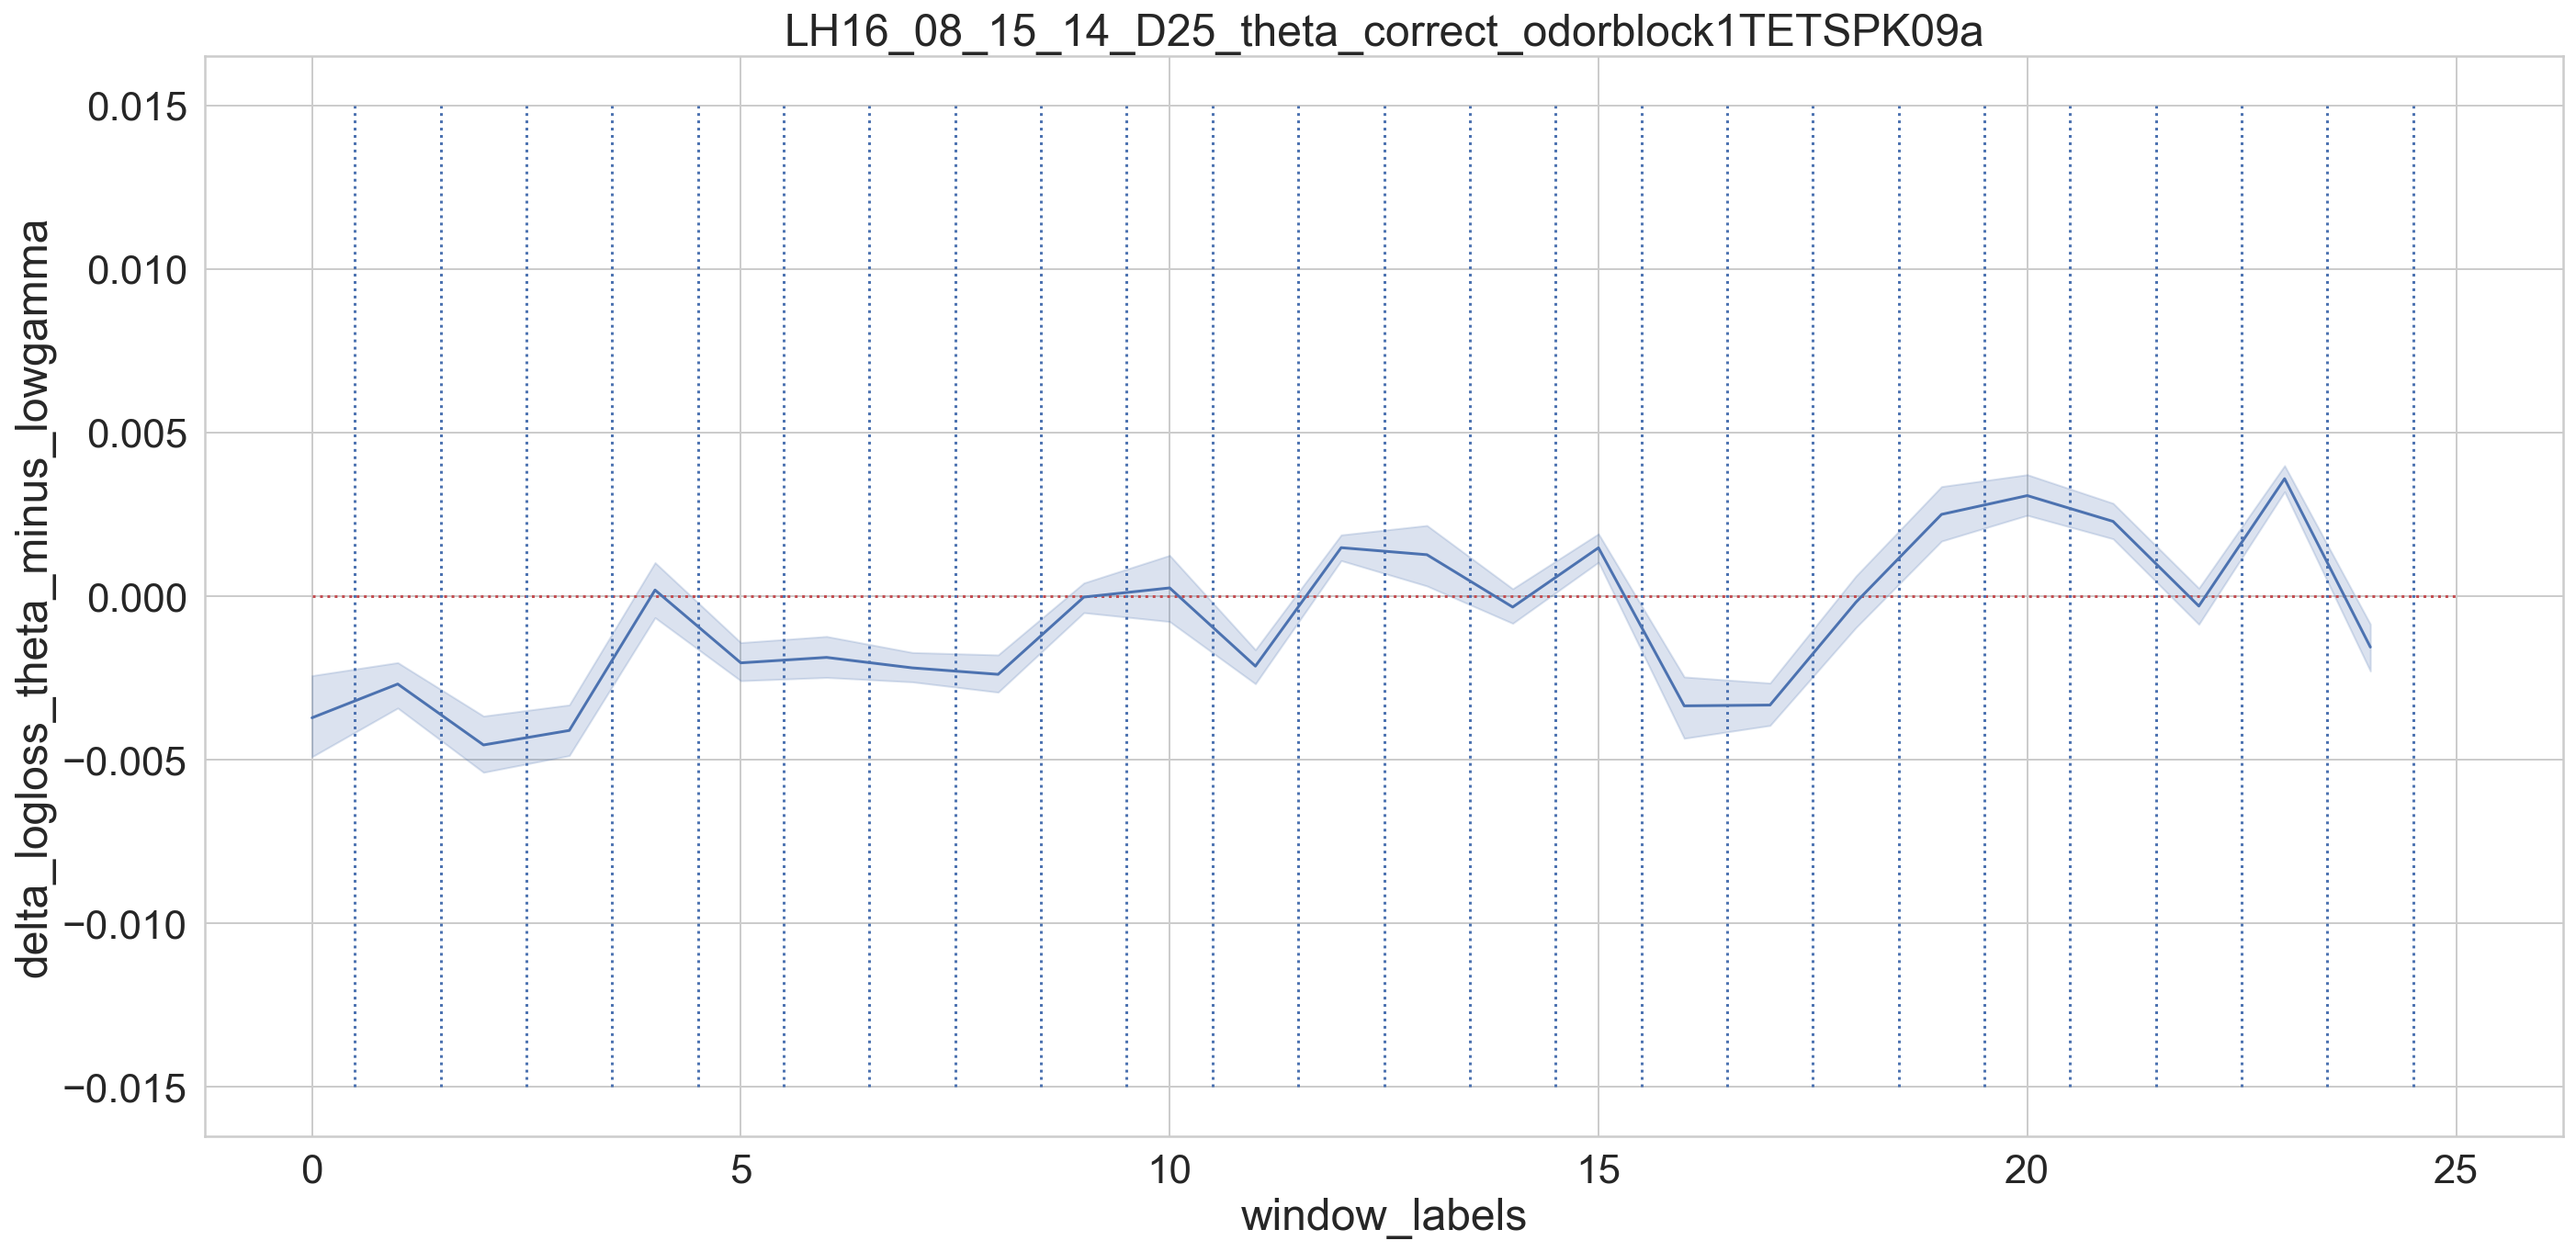

In [108]:
fig,ax=plt.subplots(figsize=(20,10))

# sns.scatterplot(x='window_labels',y='delta_logloss_theta_minus_lowgamma',data=subthetaloss,s=100)
sns.lineplot(x='window_labels',y='delta_logloss_theta_minus_lowgamma',data=tst)



ax.hlines(xmin=0,xmax=len(window_labels),y = 0,linestyle='dotted',color='r')
ax.vlines(x=[w+0.5 for w in window_labels], ymin=-0.015,ymax=0.015,linestyle='dotted')
ax.set_title(cell_id)
fig.tight_layout()

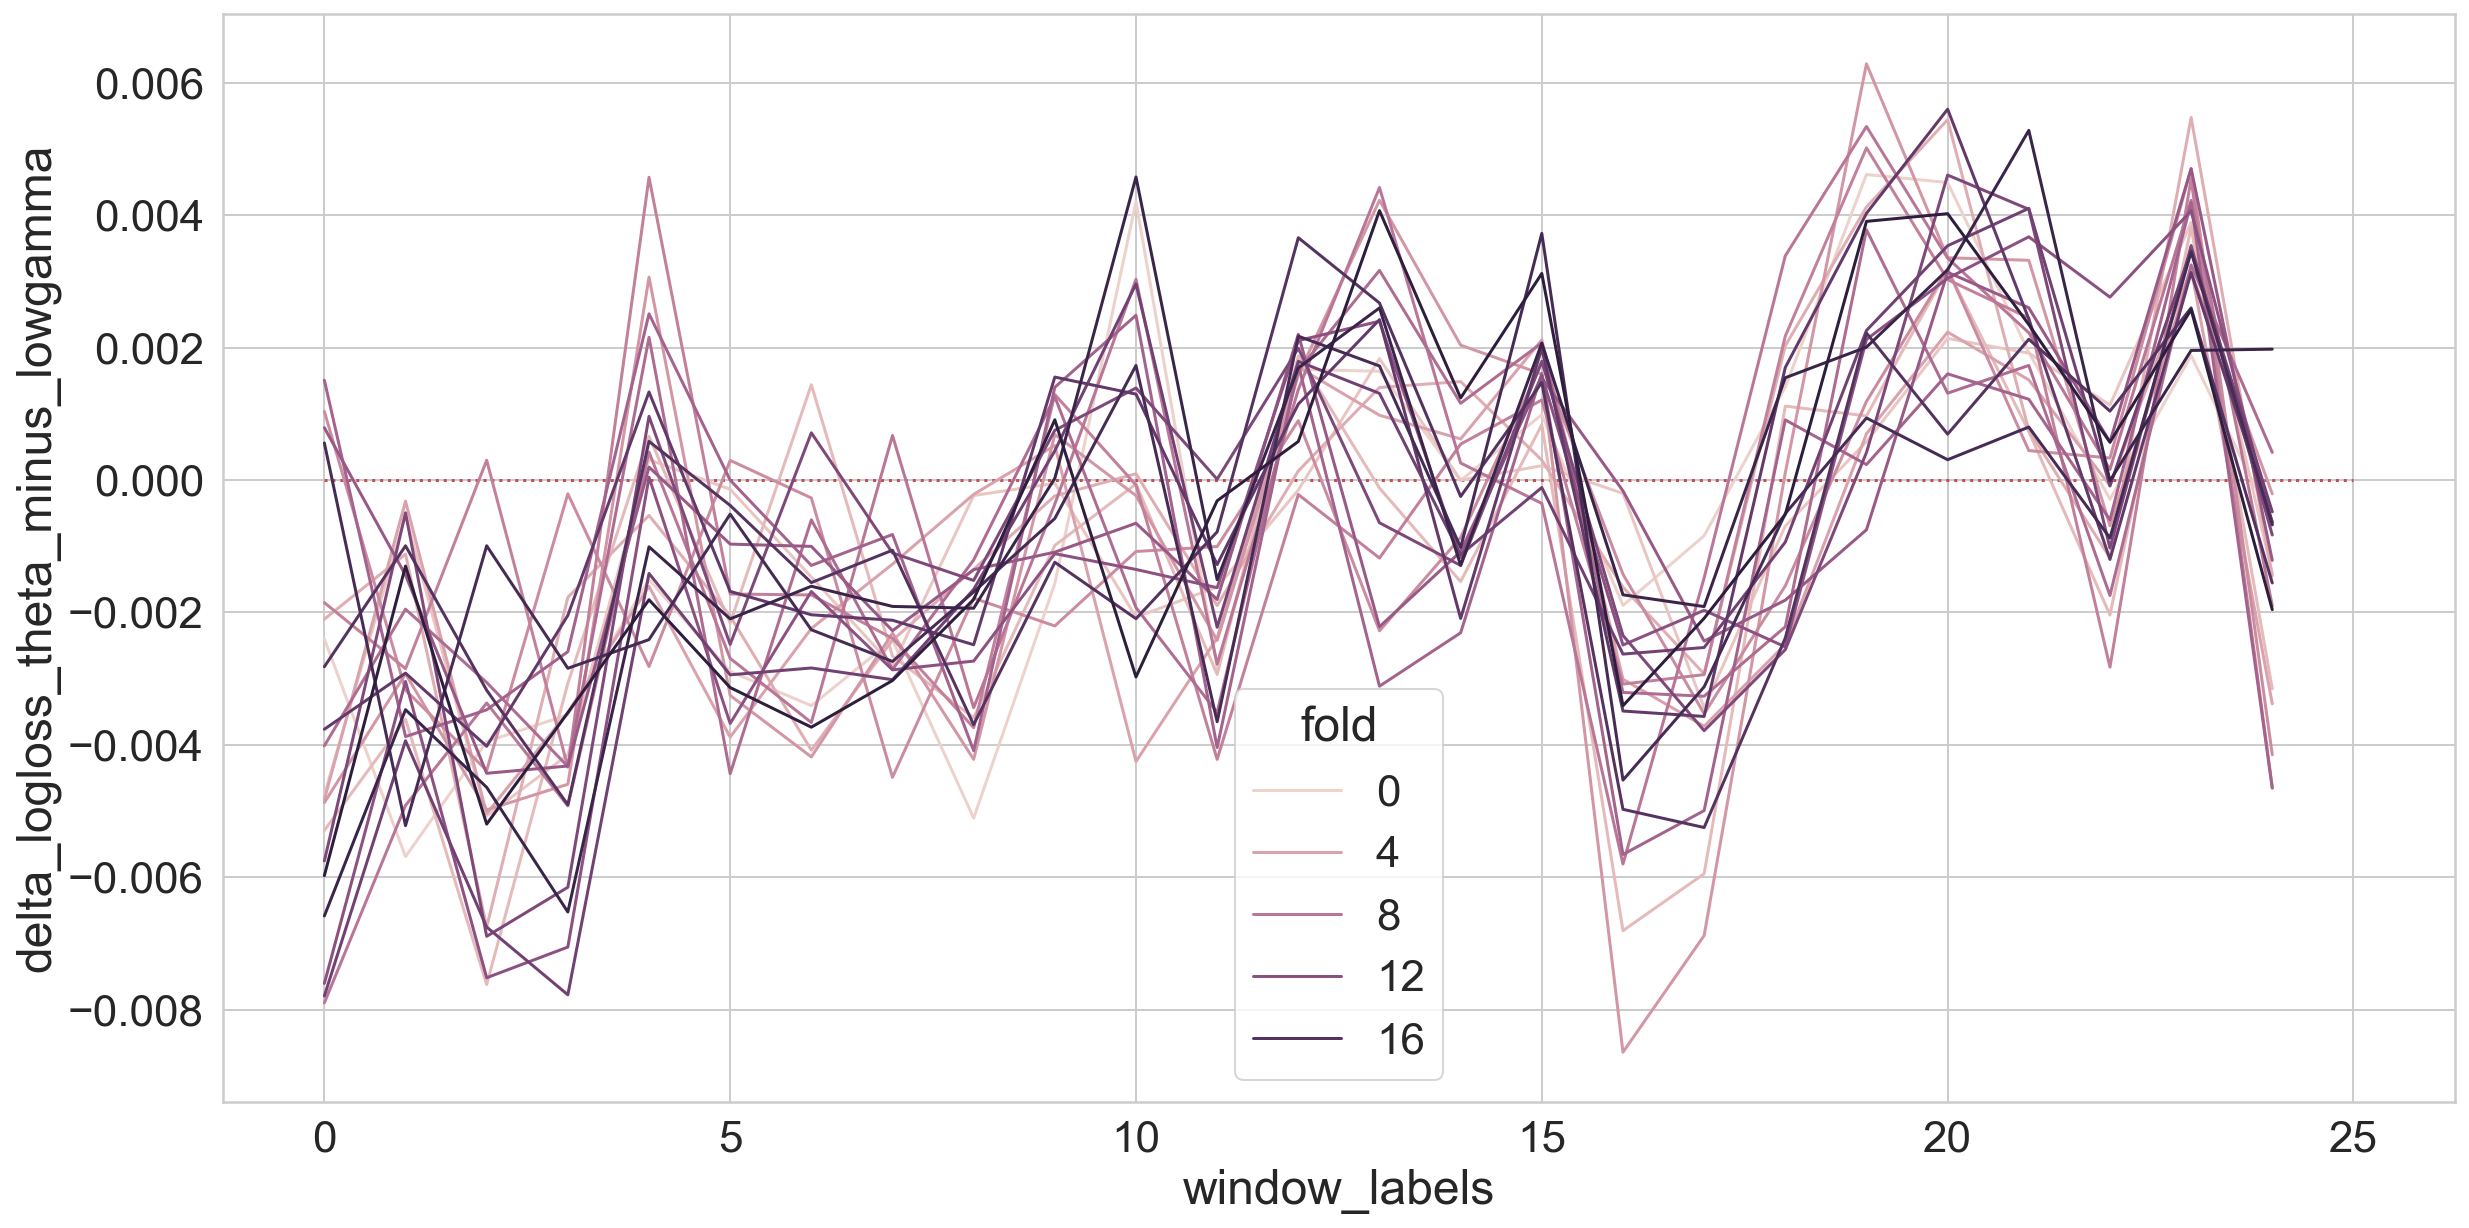

In [110]:
fig,ax=plt.subplots(figsize=(20,10))

sns.lineplot(x='window_labels',y='delta_logloss_theta_minus_lowgamma',hue='fold',data=tst)
ax.hlines(xmin=0,xmax=len(window_labels),y = 0,linestyle='dotted',color='r')


In [111]:
cell_id = 'LH16_08_15_14_D25_theta_correct_odorblock2TETSPK09a'
datapath = 'RESULTS/PHASE_HIST_MODELS_all_realcells/intlogoddsCompleteSinglePredMdls940/'
rh_folders = os.listdir(datapath)

window_size = 50
window_slide = 50
model_subset = ['cshort']
rhythm_subset = ['theta','lowgamma']
loss_delta_tmp = []
for fold in range(20): 
    
    ptest, test = grab_probs_and_data(datapath,rh_folders,cell_id,fold,'probs_models_test.csv','test_data.csv')
    
    
    ll_ptest = compute_logloss_deltas(ptest, test, window_size, window_slide, model_subset, rhythm_subset)

    grouped_ptest = ll_ptest.groupby(['rhythm','trial_labels','window_labels']).mean()['logloss_cshort'].reset_index()
    grouped_ptest = ll_ptest.groupby(['rhythm','window_labels']).mean()['logloss_cshort'].reset_index()
    
    
    subthetaloss = grouped_ptest[grouped_ptest['rhythm'] == 'theta']
    sublowgammaloss = grouped_ptest[grouped_ptest['rhythm'] == 'lowgamma']
    delta = subthetaloss['logloss_cshort'].values - sublowgammaloss['logloss_cshort'].values
    
    
    tmp = {'delta_logloss_theta_minus_lowgamma': delta,
           'window_labels': sublowgammaloss['window_labels'].to_list(),
           'fold': np.repeat(fold,subthetaloss.shape[0])
                     }
    
    loss_delta_tmp.append(pd.DataFrame(tmp))
    
loss_delta_df = pd.concat(loss_delta_tmp)

  0%|                                                    | 0/23 [00:00<?, ?it/s]/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_1601/1014385923.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subptest['spikes'] = subtest['spikes']
/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_1601/1014385923.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subptest['phases'] = subtest['phase']
/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_1601/1014385923.py:76: SettingWithCopyWa

100%|███████████████████████████████████████████| 23/23 [00:00<00:00, 28.90it/s]


In [112]:
tst = loss_delta_df.reset_index()

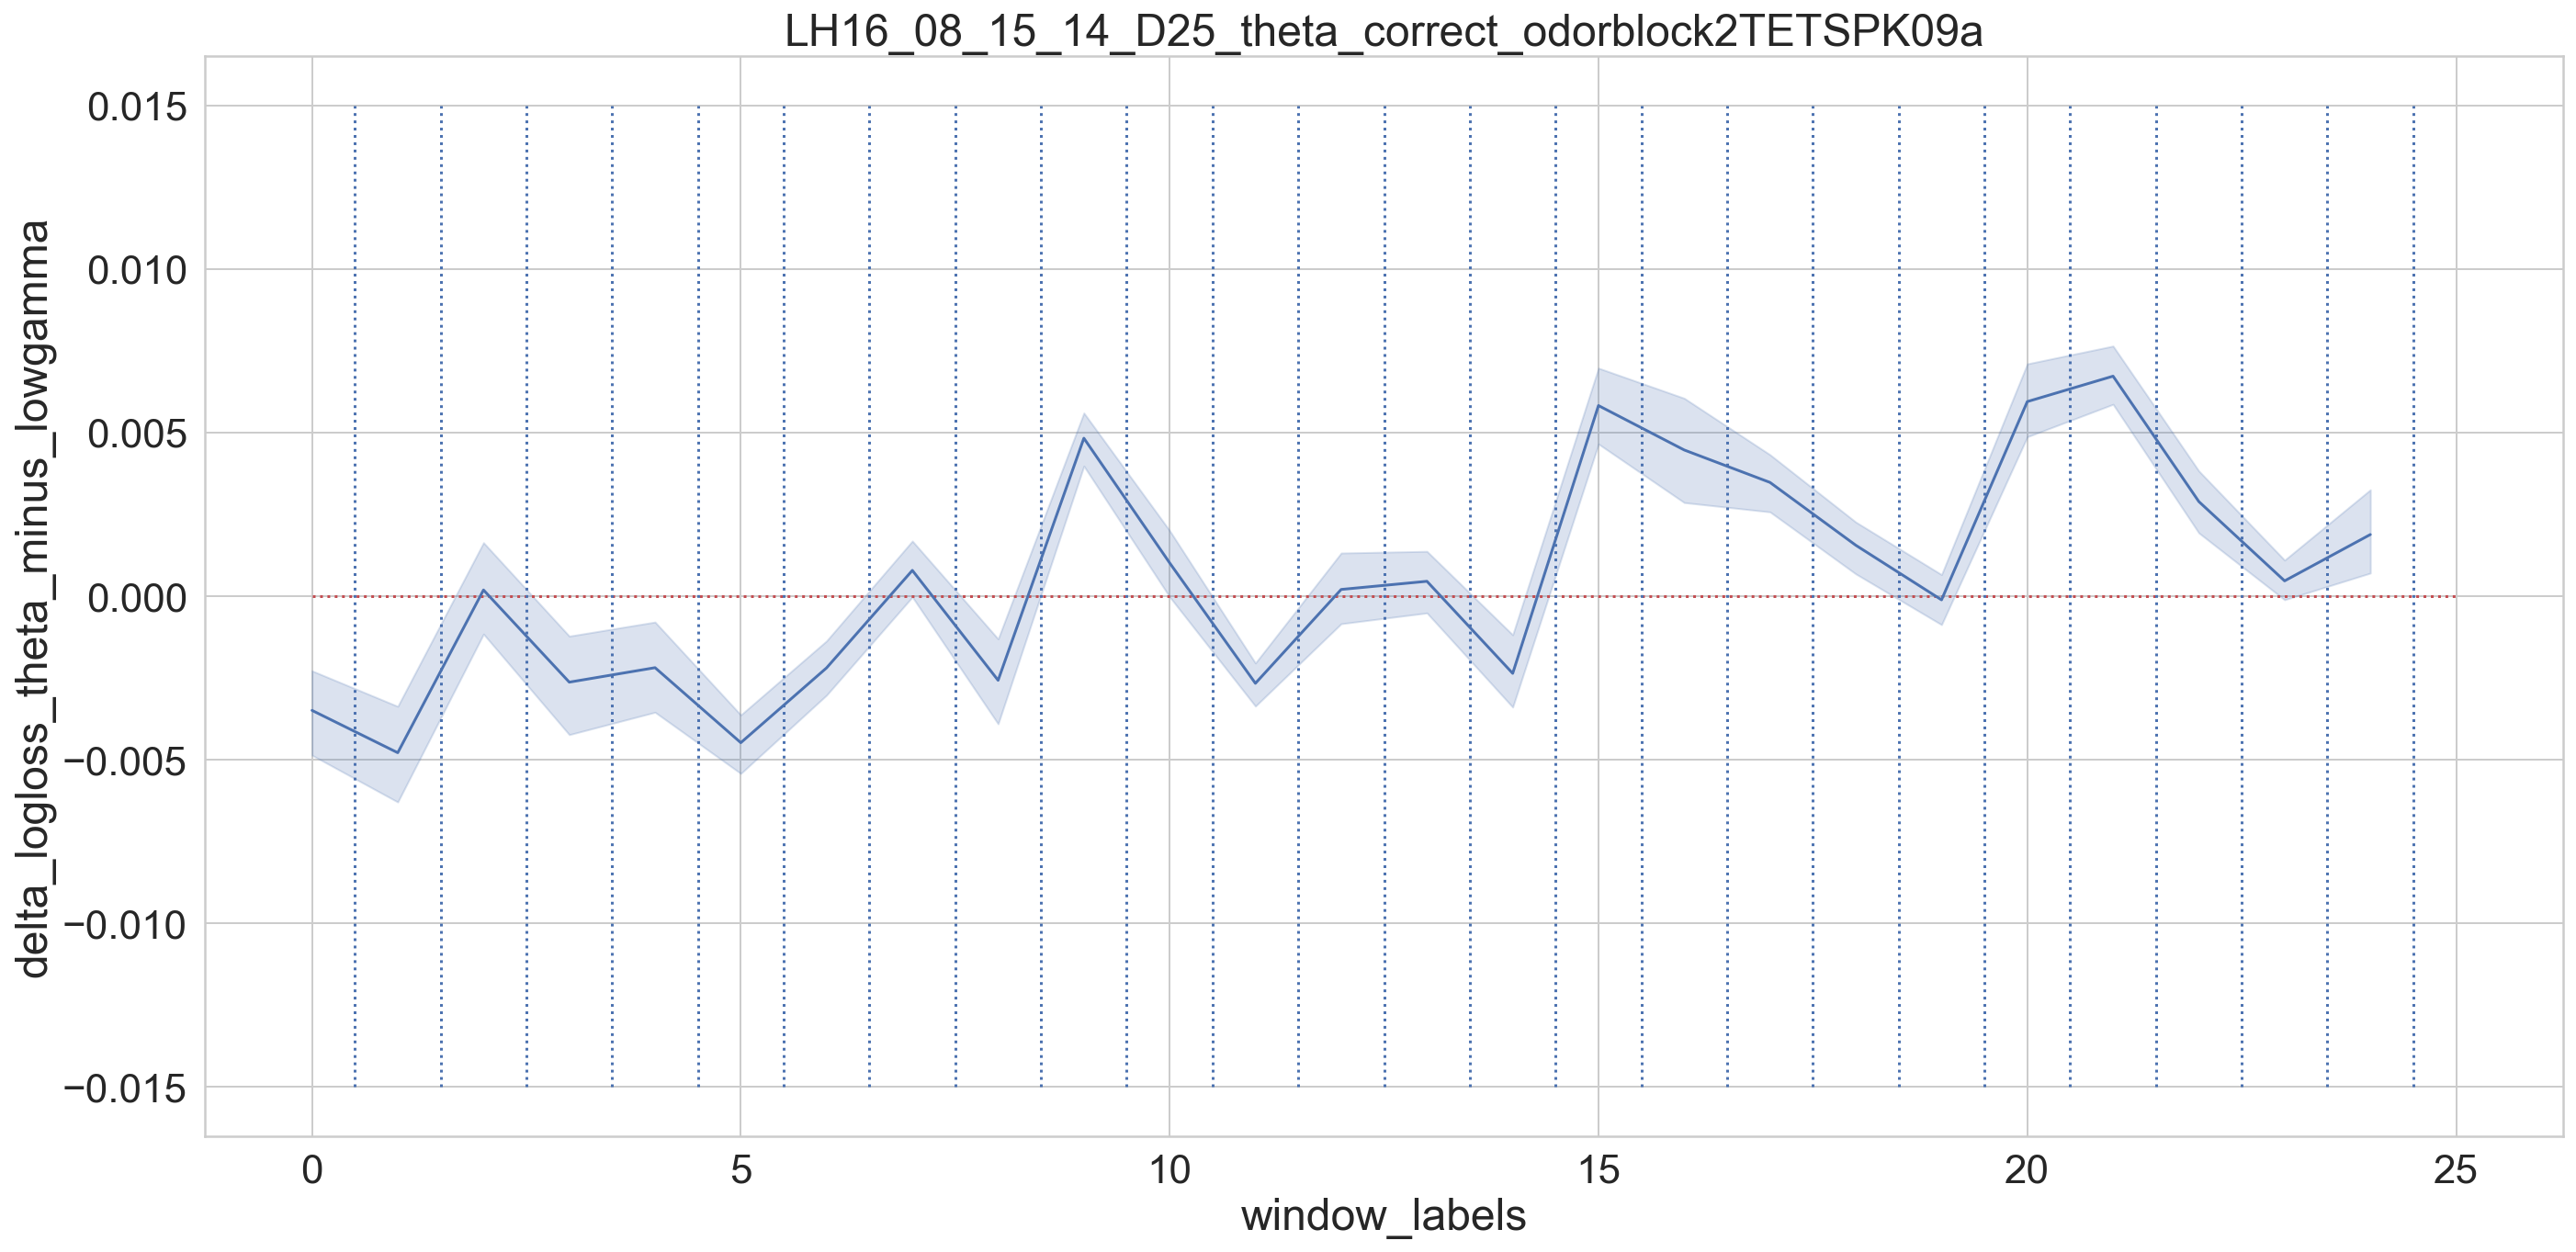

In [113]:
fig,ax=plt.subplots(figsize=(20,10))

# sns.scatterplot(x='window_labels',y='delta_logloss_theta_minus_lowgamma',data=subthetaloss,s=100)
sns.lineplot(x='window_labels',y='delta_logloss_theta_minus_lowgamma',data=tst)



ax.hlines(xmin=0,xmax=len(window_labels),y = 0,linestyle='dotted',color='r')
ax.vlines(x=[w+0.5 for w in window_labels], ymin=-0.015,ymax=0.015,linestyle='dotted')
ax.set_title(cell_id)
fig.tight_layout()

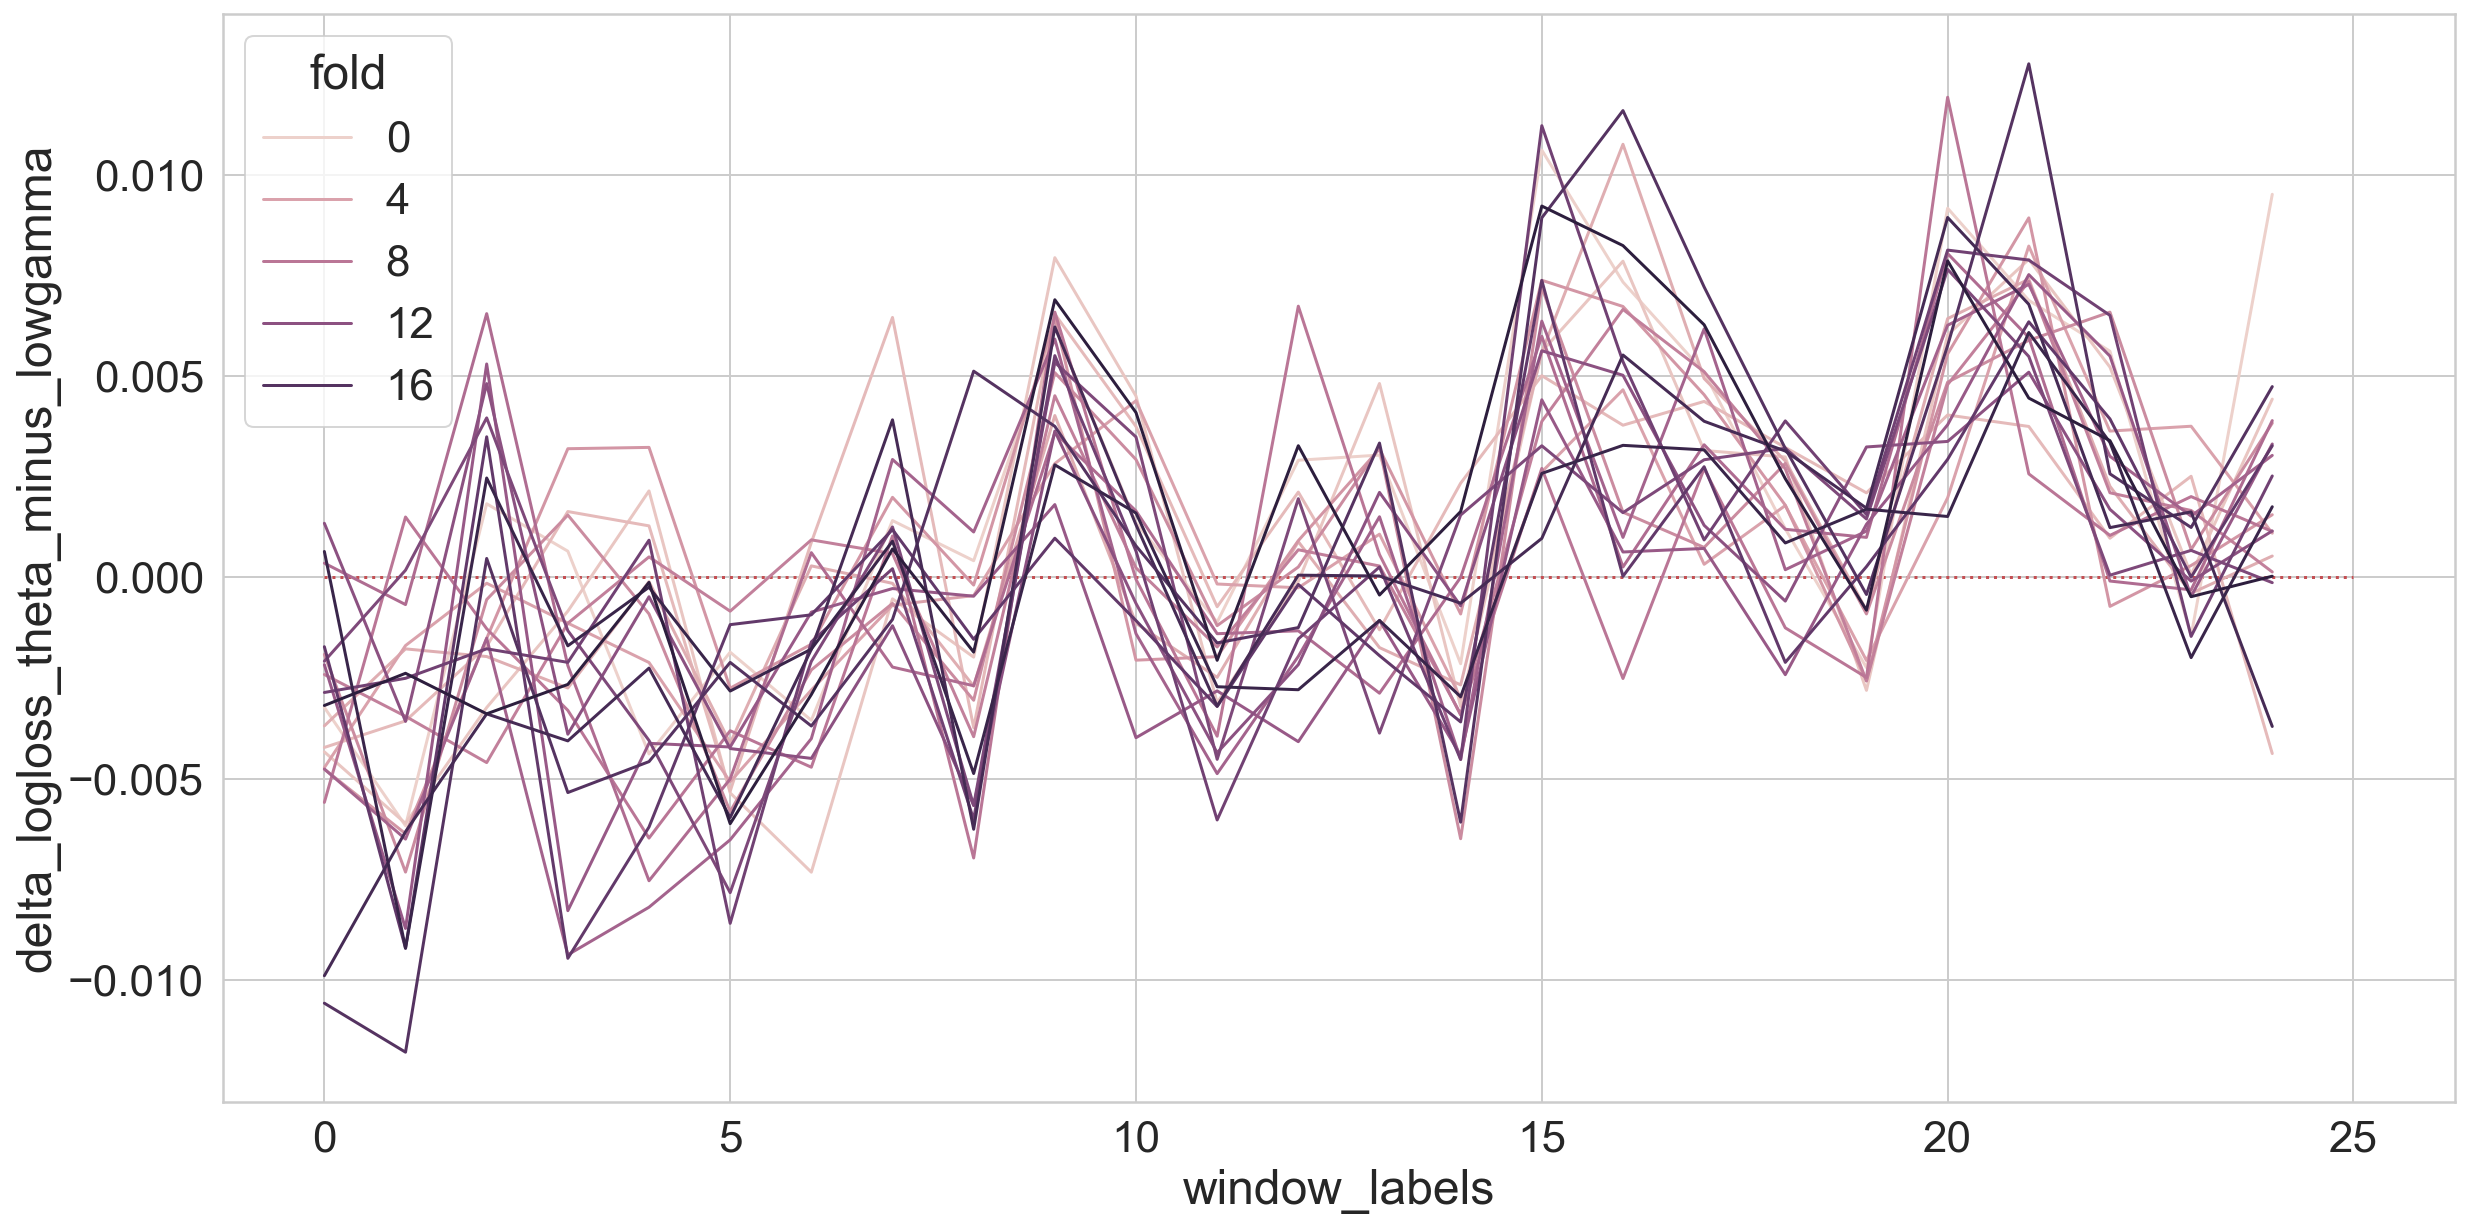

In [114]:
fig,ax=plt.subplots(figsize=(20,10))

sns.lineplot(x='window_labels',y='delta_logloss_theta_minus_lowgamma',hue='fold',data=tst)
ax.hlines(xmin=0,xmax=len(window_labels),y = 0,linestyle='dotted',color='r')


Prototyping below, cleaner functions above

### compute the log losses between theta and low gamma

In [50]:
from process_lfps import create_data_segments

In [51]:
trial_labels = list(set(test['trial_labels'].to_list()))
rhythm_labels = list(set(test['rhythm'].to_list()))

In [52]:
# break the trials into 100ms windows
window_size = 50
window_slide = 50
gather_dfs = []
for rhythm in rhythm_labels:
    
    for trial in tqdm(trial_labels):

        subtest = test[(test['trial_labels']==trial) & (test['rhythm'] == rhythm)]
        subptest = ptest[(ptest['trial_labels']==trial) & (ptest['rhythm'] == rhythm)]

        tmp = create_data_segments(subtest['spikes'].values,window_size,window_slide,['spikes','win_labels'])
        tmp['trial_labels'] = np.repeat(trial,tmp.shape[0])
        tmp['rhythm'] = np.repeat(rhythm,tmp.shape[0])

        gather_dfs.append(tmp)
        
windowed_data = pd.concat(gather_dfs)       

100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 47.30it/s]


In [53]:
#since the windowed data drops some ms, make sure to drop the corresponding ms for each trial in test/ptest dfs
len_trial = test[(test['trial_labels'] == trial_labels[0]) & (test['rhythm'] == rhythm)].shape[0]
windowed_len_trial = windowed_data[(windowed_data['trial_labels'] == trial_labels[0]) & (windowed_data['rhythm'] == rhythm)].shape[0]

rows_to_drop = len_trial - windowed_len_trial
gather_test = []
gather_ptest = []
for rhythm in rhythm_labels:
    
    for trial in tqdm(trial_labels):
        
        subtest = test[(test['trial_labels']==trial) & (test['rhythm'] == rhythm)]
        subptest = ptest[(ptest['trial_labels']==trial) & (ptest['rhythm'] == rhythm)]
        subwin = windowed_data[(windowed_data['trial_labels'] == trial) & (windowed_data['rhythm'] == rhythm)]
        
        n = subtest.drop(index=subtest.tail(rows_to_drop).index)
        m = subptest.drop(index=subptest.tail(rows_to_drop).index)
        
        n['window_labels'] = subwin['win_labels'].values
        m['window_labels'] = subwin['win_labels'].values
         
        gather_test.append(n)
        gather_ptest.append(m)
        
shaved_test = pd.concat(gather_test)
shaved_ptest = pd.concat(gather_ptest)  


100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 37.15it/s]


In [54]:
shaved_test.shape,shaved_ptest.shape,windowed_data.shape

((105000, 258), (105000, 12), (105000, 4))

In [55]:
shaved_ptest

Unnamed: 0   p_clong  p_Transhlong   p_hlong   p_phase  p_Transhshort  \
0               0  0.018720      0.022312  0.022591  0.019456   2.123215e-02   
1               1  0.019232      0.022518  0.022780  0.019534   2.123215e-02   
2               2  0.012720      0.014655  0.015410  0.019613   2.123215e-02   
3               3  0.018989      0.021467  0.021810  0.019690   2.123215e-02   
4               4  0.011481      0.012786  0.013611  0.019764   2.123215e-02   
...           ...       ...           ...       ...       ...            ...   
26265       26265  0.001903      0.001763  0.002244  0.020767   5.356873e-09   
26266       26266  0.002619      0.002434  0.003009  0.020749   1.802037e-03   
26267       26267  0.007638      0.007125  0.007996  0.020731   1.082916e-02   
26268       26268  0.010715      0.010028  0.010912  0.020711   2.123215e-02   
26269       26269  0.007872      0.007384  0.008260  0.020690   2.123215e-02   

           p_hshort      p_cshort rhythm  \
0      2.123216e-02  1.785134e-02   beta   
1      2.123216e-02  1.816807e-02   beta   
2      2.123216e-02  1.849215e-02   beta   
3      2.123216e-02  1.881452e-02   beta   
4      2.123216e-02  1.912679e-02   beta   
...             ...           ...    ...   
26265  5.359347e-09  5.461878e-09  theta   
26266  1.802174e-03  1.932526e-03  theta   
26267  1.082939e-02  1.165998e-02  theta   
26268  2.123216e-02  2.283977e-02  theta   
26269  2.123216e-02  2.276951e-02  theta   

                                                   cell_id  trial_labels  \
0      LH16_08_22_14_D29_theta_correct_odorblock2TETSPK53c             0   
1      LH16_08_22_14_D29_theta_correct_odorblock2TETSPK53c             0   
2      LH16_08_22_14_D29_theta_correct_odorblock2TETSPK53c             0   
3      LH16_08_22_14_D29_theta_correct_odorblock2TETSPK53c             0   
4      LH16_08_22_14_D29_theta_correct_odorblock2TETSPK53c             0   
...                                                    ...           ...   
26265  LH16_08_22_14_D29_theta_correct_odorblock2TETSPK53c            42   
26266  LH16_08_22_14_D29_theta_correct_odorblock2TETSPK53c            42   
26267  LH16_08_22_14_D29_theta_correct_odorblock2TETSPK53c            42   
26268  LH16_08_22_14_D29_theta_correct_odorblock2TETSPK53c            42   
26269  LH16_08_22_14_D29_theta_correct_odorblock2TETSPK53c            42   

       window_labels  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
26265             24  
26266             24  
26267             24  
26268             24  
26269             24  

[105000 rows x 12 columns]

In [56]:
window_labels = list(set(shaved_test['window_labels'].to_list()))

In [57]:
# now compute the log loss delta between models per window
rhythm_subset = ['theta', 'lowgamma','beta','highgamma']
model_subset = ['cshort','phase']
gather_ptest = []
gather_test = []
for rhythm in rhythm_subset: 
    for trial in tqdm(trial_labels): 
        subptest = shaved_ptest[(shaved_ptest['rhythm'] == rhythm) & (shaved_ptest['trial_labels'] == trial)]
        subtest = shaved_test[(shaved_test['rhythm'] == rhythm) & (shaved_test['trial_labels'] == trial)]
        
        subptest['spikes'] = subtest['spikes']
        subptest['phases'] = subtest['phase']
            
        for model in model_subset: 
             

            _, _, subptest['logloss_'+model] = logloss(subptest['p_'+model].values, subtest['spikes'].values)
            

            gather_ptest.append(subptest)
        
ll_ptest = pd.concat(gather_ptest)

        

  0%|                                                    | 0/21 [00:00<?, ?it/s]/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_1601/2765252699.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subptest['spikes'] = subtest['spikes']
/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_1601/2765252699.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subptest['phases'] = subtest['phase']
/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_1601/2765252699.py:17: SettingWithCopyWa

In [58]:
grouped_ptest = ll_ptest.groupby(['rhythm','trial_labels','window_labels']).mean()['logloss_cshort'].reset_index()
grouped_ptest = ll_ptest.groupby(['rhythm','window_labels']).mean()['logloss_cshort'].reset_index()
# grouped_spikes = ll_ptest.groupby(['trial_labels','window_labels']).count()['spikes'].reset_index()

In [59]:
# grouped_ptest = pd.concat([grouped_ptest,grouped_spikes])

In [60]:
grouped_ptest

rhythm  window_labels  logloss_cshort
0    beta              0        0.206385
1    beta              1        0.215892
2    beta              2        0.137468
3    beta              3        0.170653
4    beta              4        0.180915
..    ...            ...             ...
95  theta             20        0.129334
96  theta             21        0.103452
97  theta             22        0.144546
98  theta             23        0.108791
99  theta             24        0.145199

[100 rows x 3 columns]

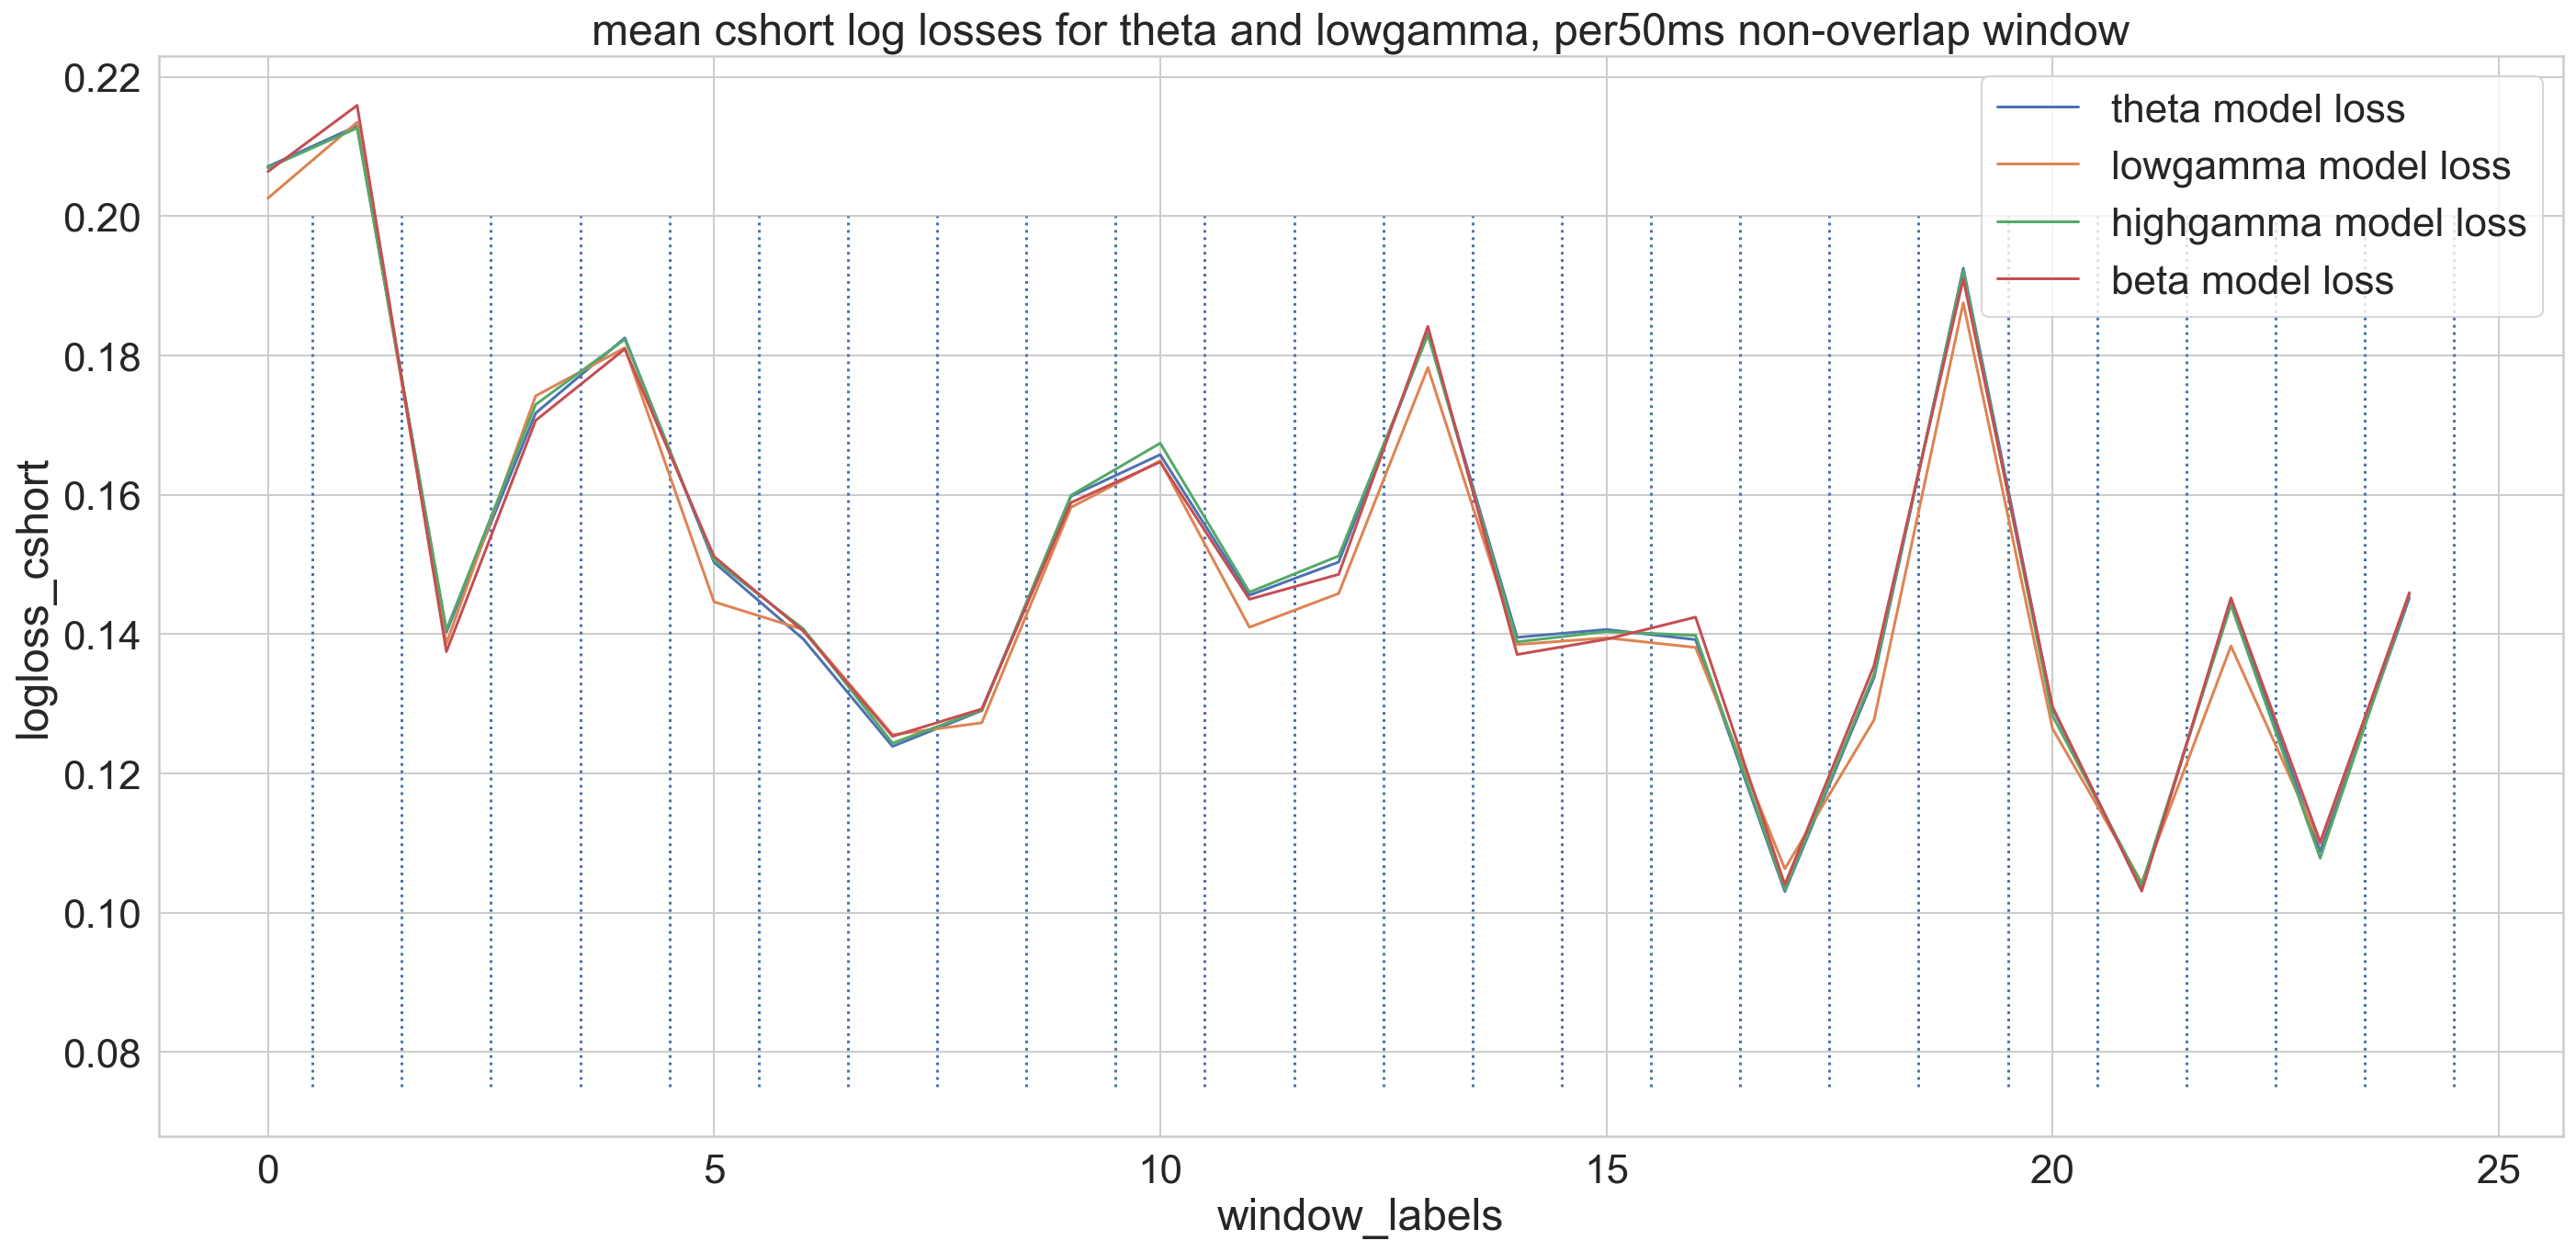

In [61]:
subthetaloss = grouped_ptest[grouped_ptest['rhythm'] == 'theta']
sublowgammaloss = grouped_ptest[grouped_ptest['rhythm'] == 'lowgamma']
subhighgammaloss = grouped_ptest[grouped_ptest['rhythm'] == 'highgamma']
subbetaloss = grouped_ptest[grouped_ptest['rhythm'] == 'beta']

logloss_model = 'logloss_cshort'
fig,ax=plt.subplots(figsize=(20,10))
# sns.boxplot(x='window_labels',y='logloss_cshort',data=grouped_ptest, hue='rhythm')
# sns.scatterplot(x='window_labels',y=logloss_model,data=grouped_ptest, hue='rhythm',s=100)
sns.lineplot(x='window_labels',y=logloss_model,data=subthetaloss,label='theta model loss')
sns.lineplot(x='window_labels',y=logloss_model,data=sublowgammaloss,label='lowgamma model loss')
sns.lineplot(x='window_labels',y=logloss_model,data=subhighgammaloss,label='highgamma model loss')
sns.lineplot(x='window_labels',y=logloss_model,data=subbetaloss,label='beta model loss')

ax.vlines(x=[w+0.5 for w in window_labels], ymin=0.075,ymax=0.2,linestyle='dotted')
ax.set_title('mean cshort log losses for theta and lowgamma, per' + str(window_size) + 'ms non-overlap window')
fig.tight_layout()
fig.savefig(cell_id+'_fold'+str(fold)+'window_size'+str(window_size)+'window_slide'+str(window_slide)+'_logloss_'+logloss_model+str(rhythm_subset)+'.pdf')


/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_1601/3158696033.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subthetaloss['delta_logloss_theta_minus_lowgamma'] = subthetaloss['logloss_cshort'].values - sublowgammaloss['logloss_cshort'].values


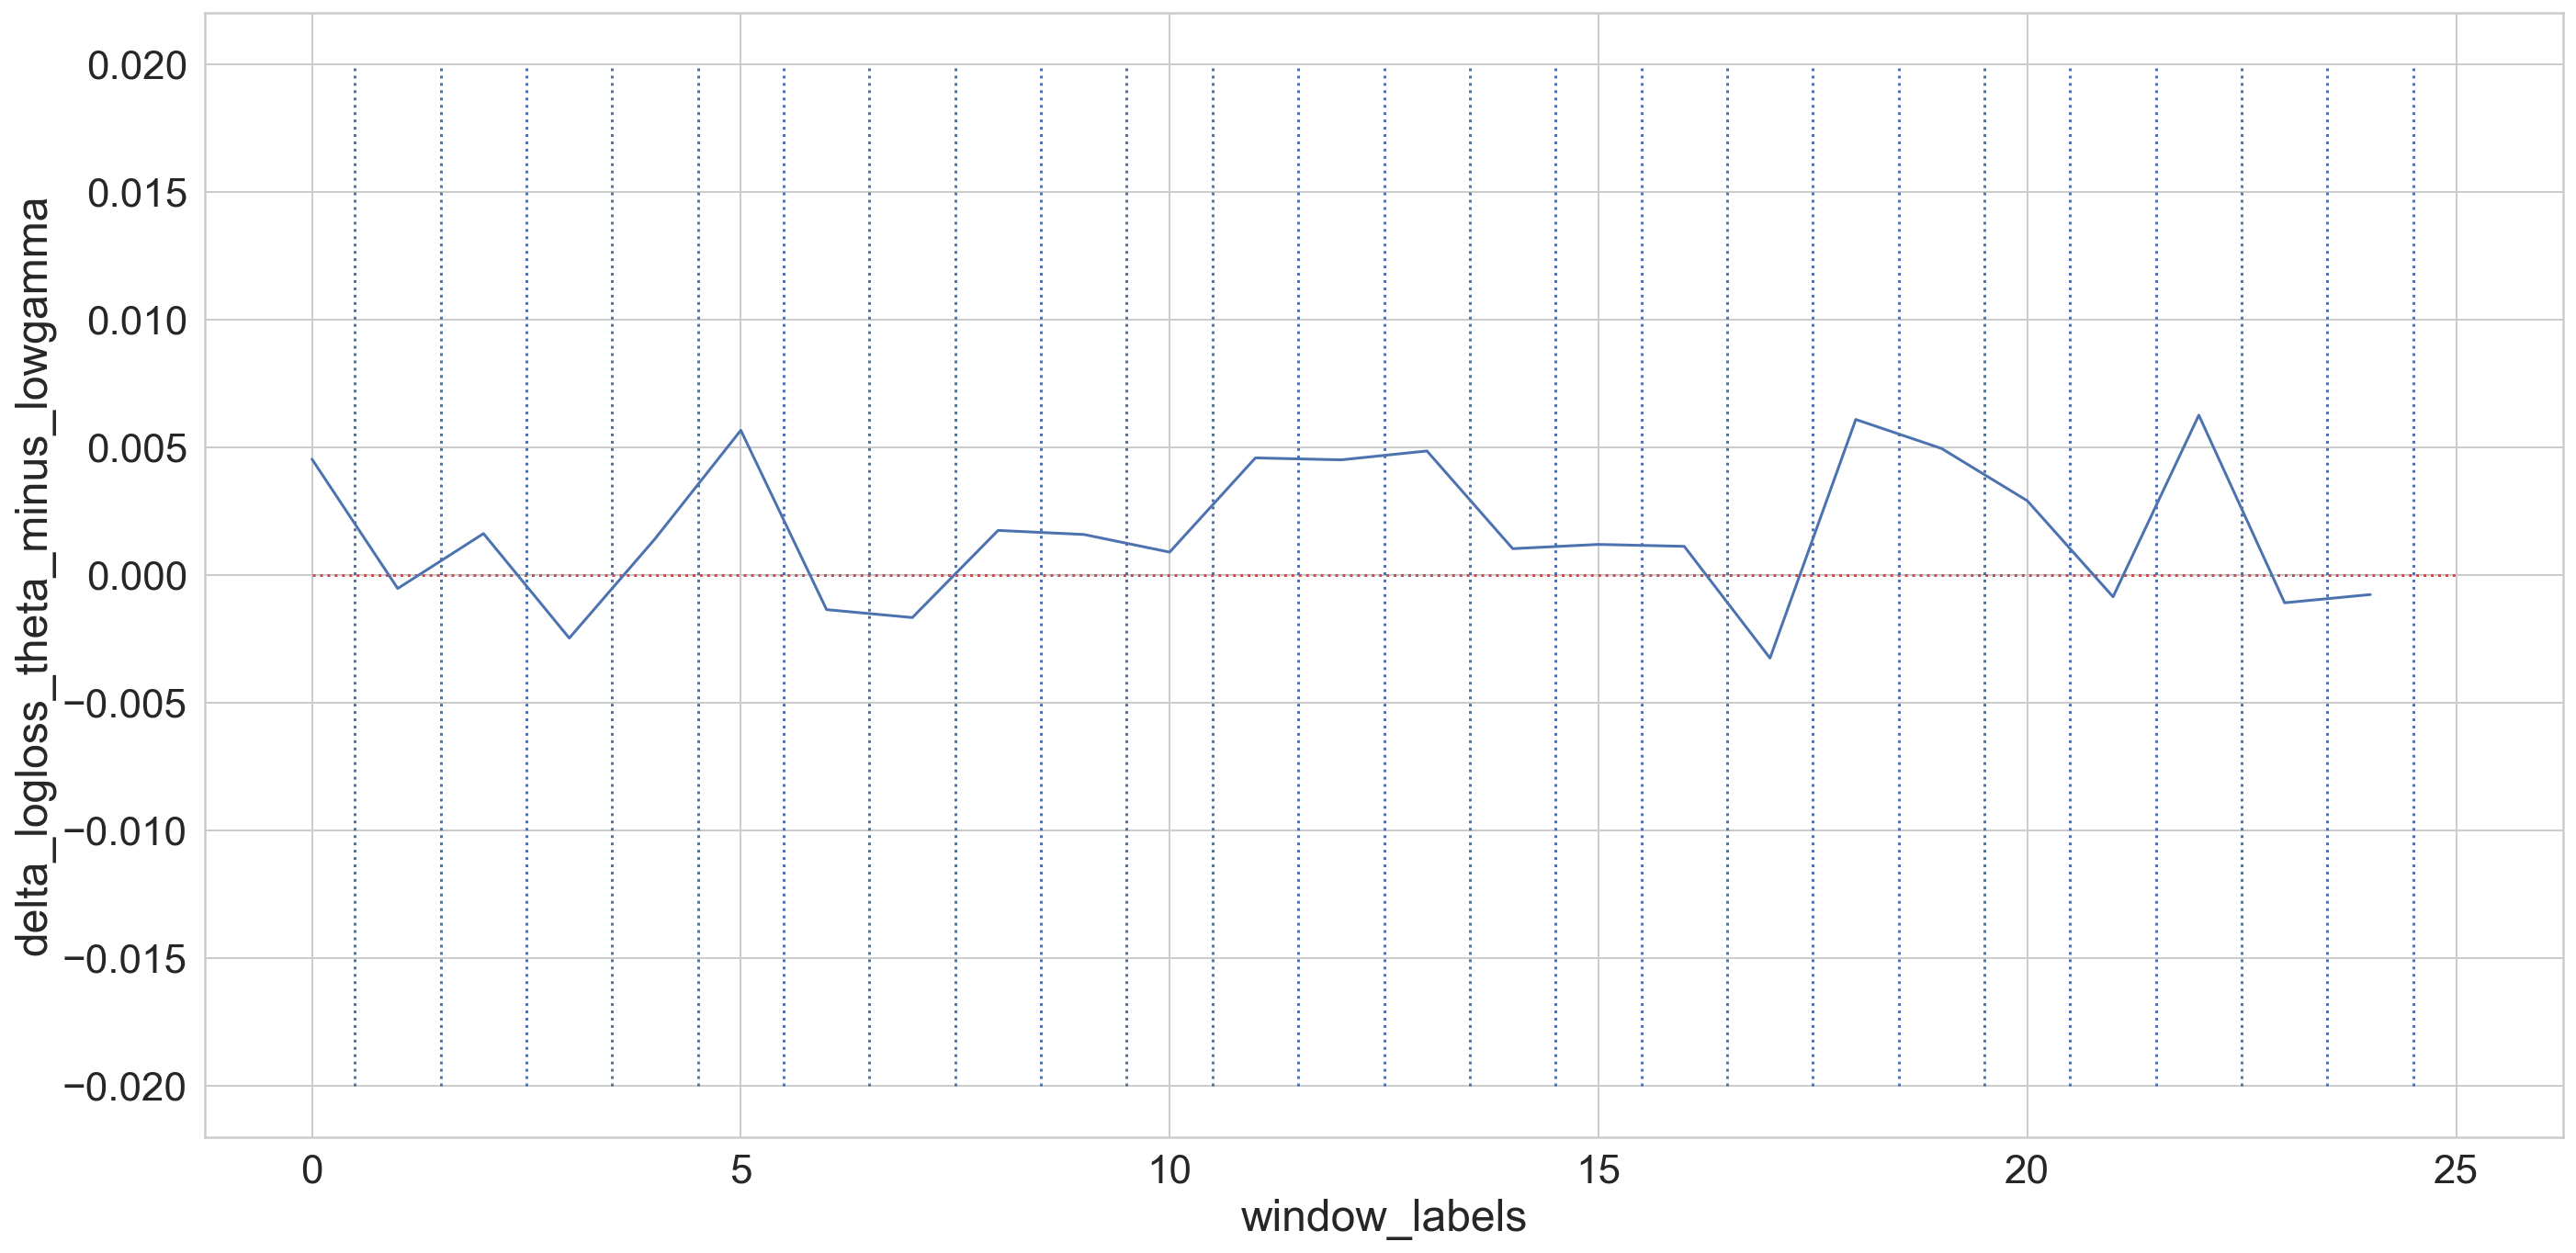

In [62]:

subthetaloss = grouped_ptest[grouped_ptest['rhythm'] == 'theta']
sublowgammaloss = grouped_ptest[grouped_ptest['rhythm'] == 'lowgamma']
subthetaloss['delta_logloss_theta_minus_lowgamma'] = subthetaloss['logloss_cshort'].values - sublowgammaloss['logloss_cshort'].values

fig,ax=plt.subplots(figsize=(20,10))

# sns.scatterplot(x='window_labels',y='delta_logloss_theta_minus_lowgamma',data=subthetaloss,s=100)
sns.lineplot(x='window_labels',y='delta_logloss_theta_minus_lowgamma',data=subthetaloss)

ax.hlines(xmin=0,xmax=len(window_labels),y = 0,linestyle='dotted',color='r')
ax.vlines(x=[w+0.5 for w in window_labels], ymin=-0.02,ymax=0.02,linestyle='dotted')
# ax.set_title('mean cshort log losses for theta and lowgamma, per 10ms non-overlap window')
fig.tight_layout()
# fig.savefig(cell_id+'_fold'+str(fold)+'window_size'+str(window_size)+'window_slide'+str(window_slide)+'_loglossdeltas_'+logloss_model+'theta'+'lowgamma'+'.pdf')

I want to append all 20 curves for a single cell and plot the average across all of them. 

In [88]:
cell_id = 'LH16_08_08_14_D22_theta_correct_odorblock1TETSPK09a'
#container for test data dfs per rhythm
test = []
ptest=[]
datapath = 'RESULTS/PHASE_HIST_MODELS_all_realcells/intlogoddsCompleteSinglePredMdls940/'

for fold in tqdm(range(20)):

    
    for f in rh_folders:

        rh_path = os.path.join(datapath, f)
        rh_path_to_cell = rh_path + '/folds/' + str(fold) + '/single_neuron/' + cell_id

        rhythm = f.split('phase')[0]

        testtmp = pd.read_csv(os.path.join(rh_path_to_cell,'test_data.csv'))
        testtmp['rhythm'] = np.repeat(rhythm, testtmp.shape[0])
        testtmp['cell_id'] = np.repeat(cell_id, testtmp.shape[0])
        testtmp['fold_labels'] = np.repeat(fold, testtmp.shape[0])

        test.append(testtmp)

        ptesttmp = pd.read_csv(os.path.join(rh_path_to_cell,'probs_models_test.csv'))
        ptesttmp['rhythm'] = np.repeat(rhythm, ptesttmp.shape[0])
        ptesttmp['cell_id'] = np.repeat(cell_id, ptesttmp.shape[0])
        ptesttmp['trial_labels'] = testtmp['trial_labels'].values
        ptesttmp['fold_labels'] = np.repeat(fold, ptesttmp.shape[0])

        ptest.append(ptesttmp)

ptest = pd.concat(ptest)
test = pd.concat(test)

100%|███████████████████████████████████████████| 20/20 [01:00<00:00,  3.02s/it]


In [103]:
subtest

Unnamed: 0       lfp     phase  spikes  249  248  247  246  245  244  \
0              0  0.118256  1.908151       0  0.0  0.0  0.0  0.0  0.0  0.0   
1              1  0.116501  1.863634       0  0.0  0.0  0.0  0.0  0.0  0.0   
2              2  0.108795  1.819132       0  0.0  0.0  0.0  0.0  0.0  0.0   
3              3  0.119362  1.774644       0  0.0  0.0  0.0  0.0  0.0  0.0   
4              4  0.149994  1.730167       0  0.0  0.0  0.0  0.0  0.0  0.0   
...          ...       ...       ...     ...  ...  ...  ...  ...  ...  ...   
1246        1246 -0.021019  0.097614       0  0.0  0.0  0.0  0.0  0.0  0.0   
1247        1247 -0.048790  0.054213       0  0.0  0.0  0.0  0.0  0.0  0.0   
1248        1248 -0.036507  0.010890       0  0.0  0.0  0.0  0.0  0.0  0.0   
1249        1249  0.022430 -0.032357       0  0.0  0.0  0.0  0.0  0.0  0.0   
1250        1250 -0.060234 -0.075531       0  0.0  0.0  0.0  0.0  0.0  0.0   

      ...    5    4    3    2    1    0  trial_labels  rhythm  \
0     ...  0.0  0.0  0.0  0.0  0.0  0.0             0   theta   
1     ...  0.0  0.0  0.0  0.0  0.0  0.0             0   theta   
2     ...  0.0  0.0  0.0  0.0  0.0  0.0             0   theta   
3     ...  0.0  0.0  0.0  0.0  0.0  0.0             0   theta   
4     ...  0.0  0.0  0.0  0.0  0.0  0.0             0   theta   
...   ...  ...  ...  ...  ...  ...  ...           ...     ...   
1246  ...  0.0  0.0  0.0  0.0  0.0  0.0             0   theta   
1247  ...  0.0  0.0  0.0  0.0  0.0  0.0             0   theta   
1248  ...  0.0  0.0  0.0  0.0  0.0  0.0             0   theta   
1249  ...  0.0  0.0  0.0  0.0  0.0  0.0             0   theta   
1250  ...  0.0  0.0  0.0  0.0  0.0  0.0             0   theta   

                                                  cell_id  fold_labels  
0     LH16_08_08_14_D22_theta_correct_odorblock1TETSPK09a           18  
1     LH16_08_08_14_D22_theta_correct_odorblock1TETSPK09a           18  
2     LH16_08_08_14_D22_theta_correct_odorblock1TETSPK09a           18  
3     LH16_08_08_14_D22_theta_correct_odorblock1TETSPK09a           18  
4     LH16_08_08_14_D22_theta_correct_odorblock1TETSPK09a           18  
...                                                   ...          ...  
1246  LH16_08_08_14_D22_theta_correct_odorblock1TETSPK09a           18  
1247  LH16_08_08_14_D22_theta_correct_odorblock1TETSPK09a           18  
1248  LH16_08_08_14_D22_theta_correct_odorblock1TETSPK09a           18  
1249  LH16_08_08_14_D22_theta_correct_odorblock1TETSPK09a           18  
1250  LH16_08_08_14_D22_theta_correct_odorblock1TETSPK09a           18  

[1251 rows x 258 columns]

In [89]:
# break the trials into 100ms windows
window_size = 50
window_slide = 50
gather_dfs = []

for fold in range(20):
    
    for rhythm in rhythm_labels:

        for trial in tqdm(trial_labels):

            subtest = test[(test['trial_labels']==trial) & (test['rhythm'] == rhythm) & (test['fold_labels'] == fold)]
            subptest = ptest[(ptest['trial_labels']==trial) & (ptest['rhythm'] == rhythm) & (ptest['fold_labels'] == fold)]

#             tmp = create_data_segments(subtest['spikes'].values,window_size,window_slide,['spikes','win_labels'])
#             tmp['trial_labels'] = np.repeat(trial,tmp.shape[0])
#             tmp['rhythm'] = np.repeat(rhythm,tmp.shape[0])
#             tmp['fold_labels'] = np.repeat(fold,tmp.shape[0])

#             gather_dfs.append(tmp)
        
# windowed_data = pd.concat(gather_dfs)       

100%|███████████████████████████████████████████| 21/21 [00:08<00:00,  2.59it/s]


In [187]:
trial = 41
subtheta_ptest = ptest[(ptest['rhythm'] == 'theta') & (ptest['trial_labels'] == trial)]
sublowgamma_ptest = ptest[(ptest['rhythm'] == 'lowgamma') & (ptest['trial_labels'] == trial)]

subtheta_test = test[(test['rhythm'] == 'theta') & (test['trial_labels'] == trial)]
sublowgamma_test = test[(test['rhythm'] == 'lowgamma') & (test['trial_labels'] == trial)]


meanloss_theta, _, logloss_theta = logloss(subtheta_ptest['p_cshort'].values, subtheta_test['spikes'].values)
meanloss_lowgamma, _, logloss_lowgamma = logloss(sublowgamma_ptest['p_cshort'].values, sublowgamma_test['spikes'].values)

In [188]:
trial_labels = list(set(ptest['trial_labels'].to_list()))

In [189]:
trial_labels

[0, 1, 3, 5, 9, 10, 13, 15, 17, 18, 19, 20, 21, 22, 23, 28, 32, 33, 35, 37, 41]

In [190]:
subtheta_test.shape[0]

1251

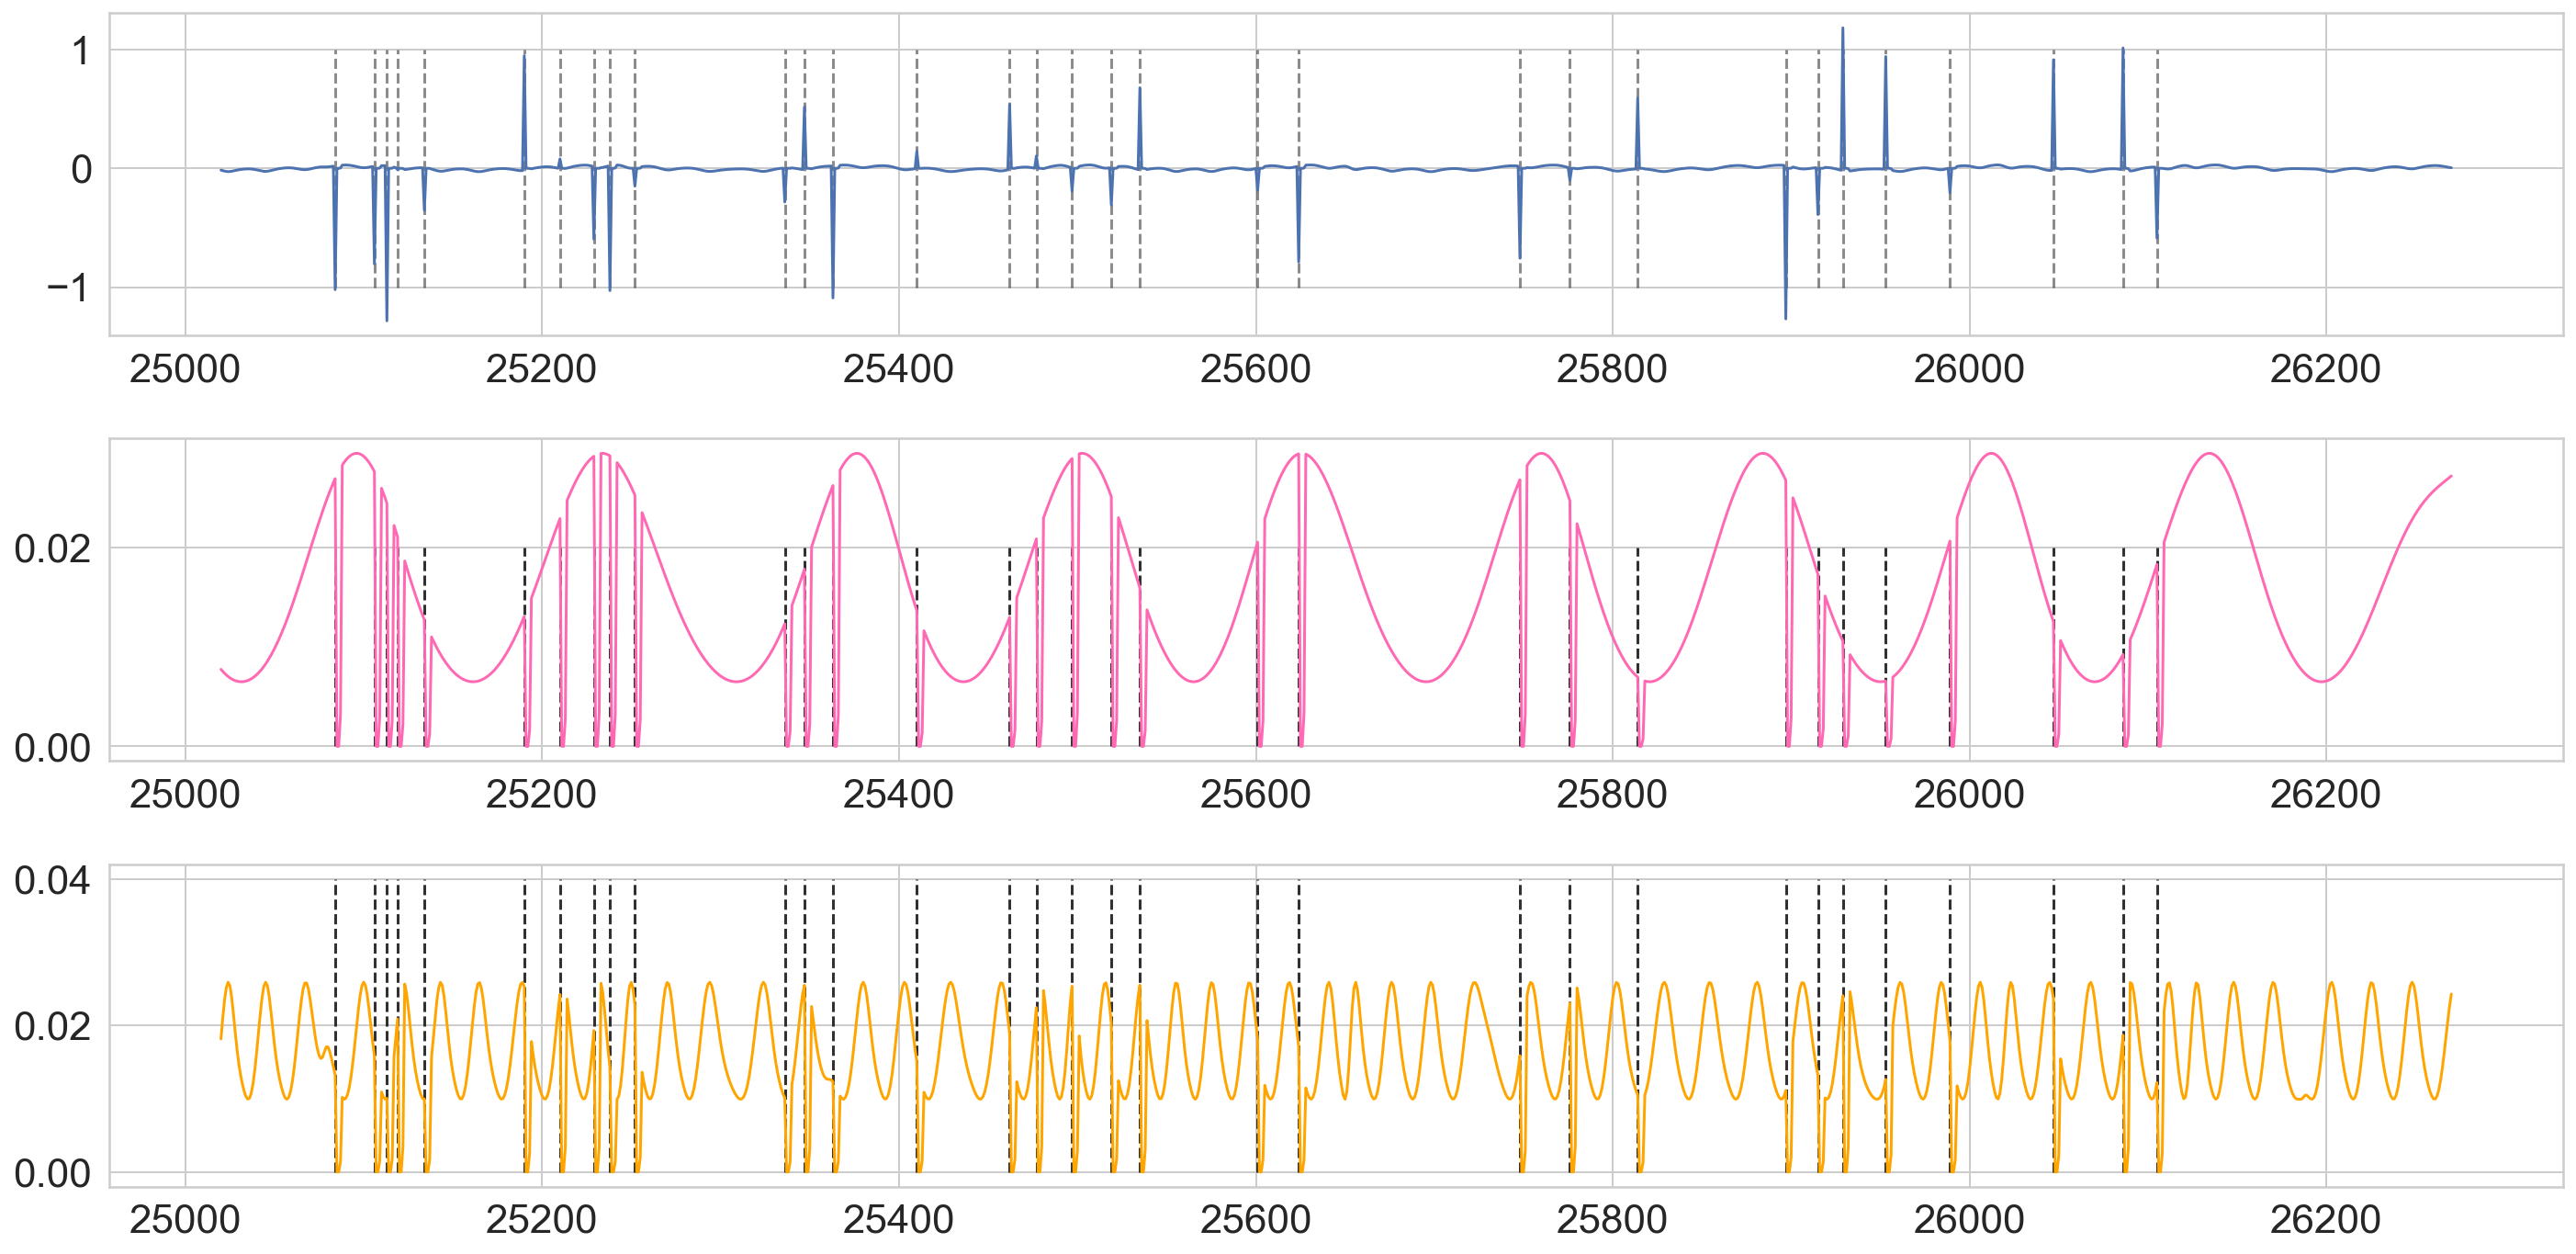

In [191]:
fig, ax = plt.subplots(3,1,figsize=(20,10))
time = subtheta_test.index
spikes_ts = subtheta_test[subtheta_test['spikes'] == 1].index

ax[0].plot(time, np.subtract(logloss_theta, logloss_lowgamma))

ax[0].vlines(x = spikes_ts, 
             ymax = 1, 
             ymin = -1,color='k',alpha=0.5, linestyle='--')

ax[1].plot(time, subtheta_ptest['p_cshort'],color='hotpink')
ax[1].vlines(x = spikes_ts, 
             ymax = 0.02, 
             ymin = 0,color='k',alpha=0.9, linestyle='--')

ax[2].plot(time, sublowgamma_ptest['p_cshort'],color='orange')

ax[2].vlines(x = spikes_ts, 
             ymax = 0.04, 
             ymin = 0,color='k',alpha=0.9, linestyle='--')

fig.tight_layout()

In [166]:
# trial = 0
subtheta_ptest = ptest[(ptest['rhythm'] == 'theta') & (ptest['trial_labels'] == trial)]
sublowgamma_ptest = ptest[(ptest['rhythm'] == 'lowgamma') & (ptest['trial_labels'] == trial)]

subtheta_test = test[(test['rhythm'] == 'theta') & (test['trial_labels'] == trial)]
sublowgamma_test = test[(test['rhythm'] == 'lowgamma') & (test['trial_labels'] == trial)]


meanloss_theta, _, logloss_theta = logloss(subtheta_ptest['p_phase'].values, subtheta_test['spikes'].values)
meanloss_hshort, _, logloss_hshort = logloss(subtheta_ptest['p_hshort'].values, subtheta_test['spikes'].values)

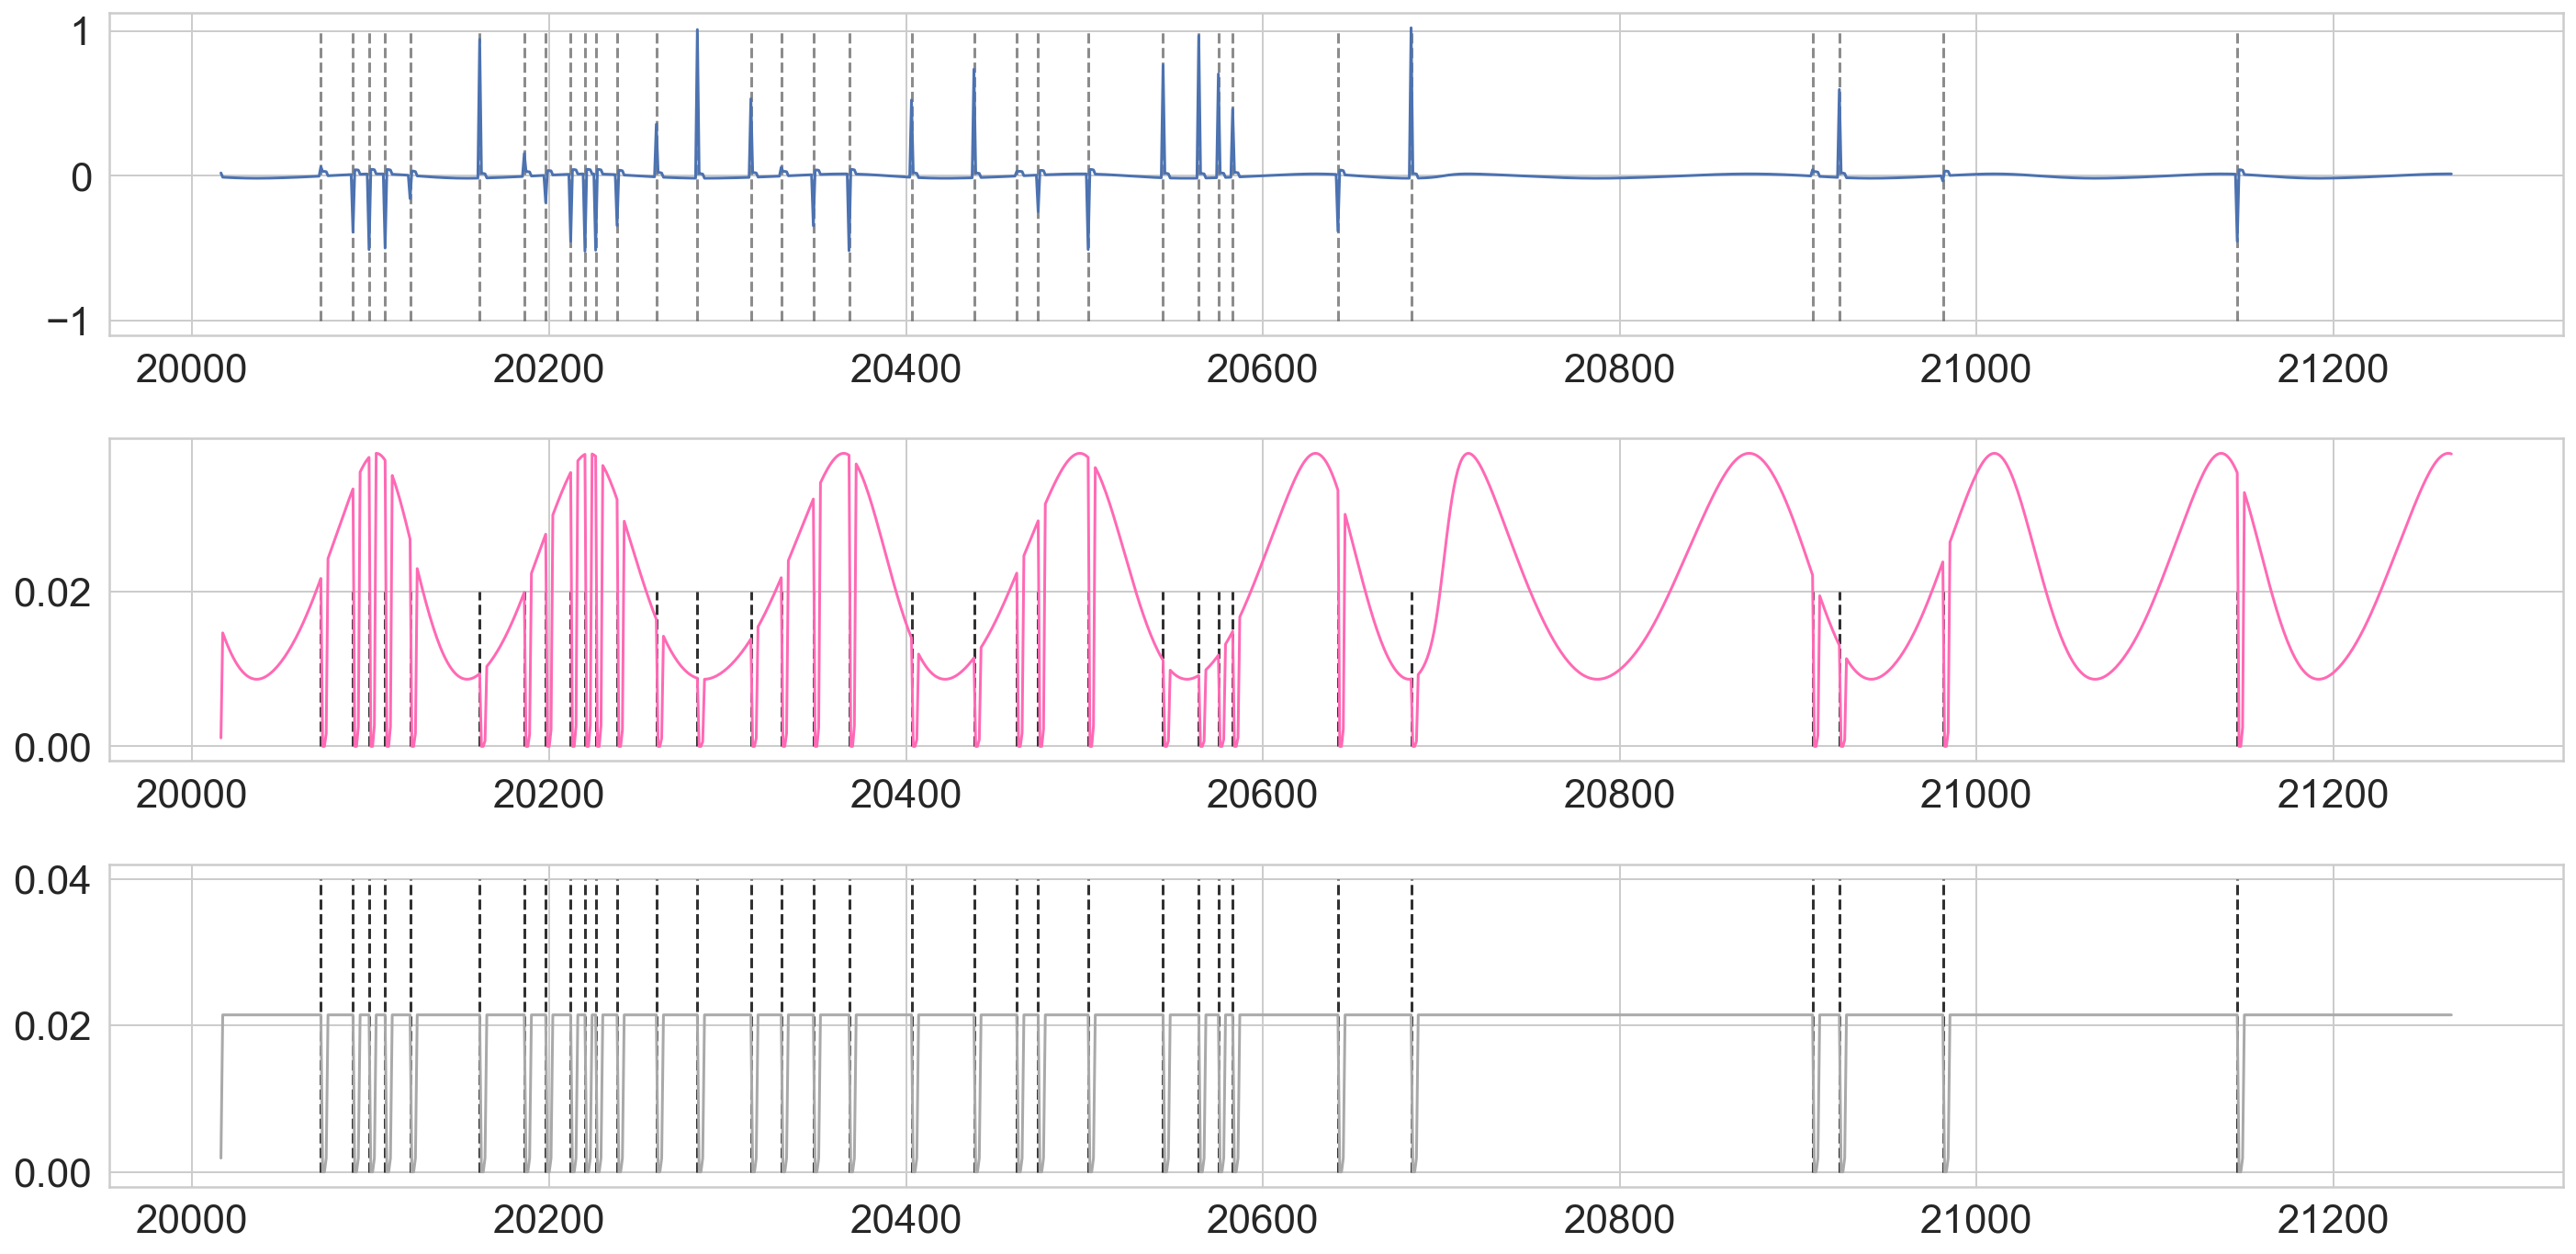

In [167]:
fig, ax = plt.subplots(3,1,figsize=(20,10))
time = subtheta_test.index
spikes_ts = subtheta_test[subtheta_test['spikes'] == 1].index

ax[0].plot(time, np.subtract(logloss_theta, logloss_hshort))

ax[0].vlines(x = spikes_ts, 
             ymax = 1, 
             ymin = -1,color='k',alpha=0.5, linestyle='--')

ax[1].plot(time, subtheta_ptest['p_cshort'],color='hotpink')
ax[1].vlines(x = spikes_ts, 
             ymax = 0.02, 
             ymin = 0,color='k',alpha=0.9, linestyle='--')

ax[2].plot(time, subtheta_ptest['p_hshort'],color='darkgrey')

ax[2].vlines(x = spikes_ts, 
             ymax = 0.04, 
             ymin = 0,color='k',alpha=0.9, linestyle='--')

fig.tight_layout()

In [168]:
# trial = 0
subtheta_ptest = ptest[(ptest['rhythm'] == 'theta') & (ptest['trial_labels'] == trial)]
sublowgamma_ptest = ptest[(ptest['rhythm'] == 'lowgamma') & (ptest['trial_labels'] == trial)]

subtheta_test = test[(test['rhythm'] == 'theta') & (test['trial_labels'] == trial)]
sublowgamma_test = test[(test['rhythm'] == 'lowgamma') & (test['trial_labels'] == trial)]


meanloss_theta, _, logloss_theta = logloss(subtheta_ptest['p_phase'].values, subtheta_test['spikes'].values)
meanloss_lowgamma, _, logloss_lowgamma = logloss(sublowgamma_ptest['p_phase'].values, sublowgamma_test['spikes'].values)

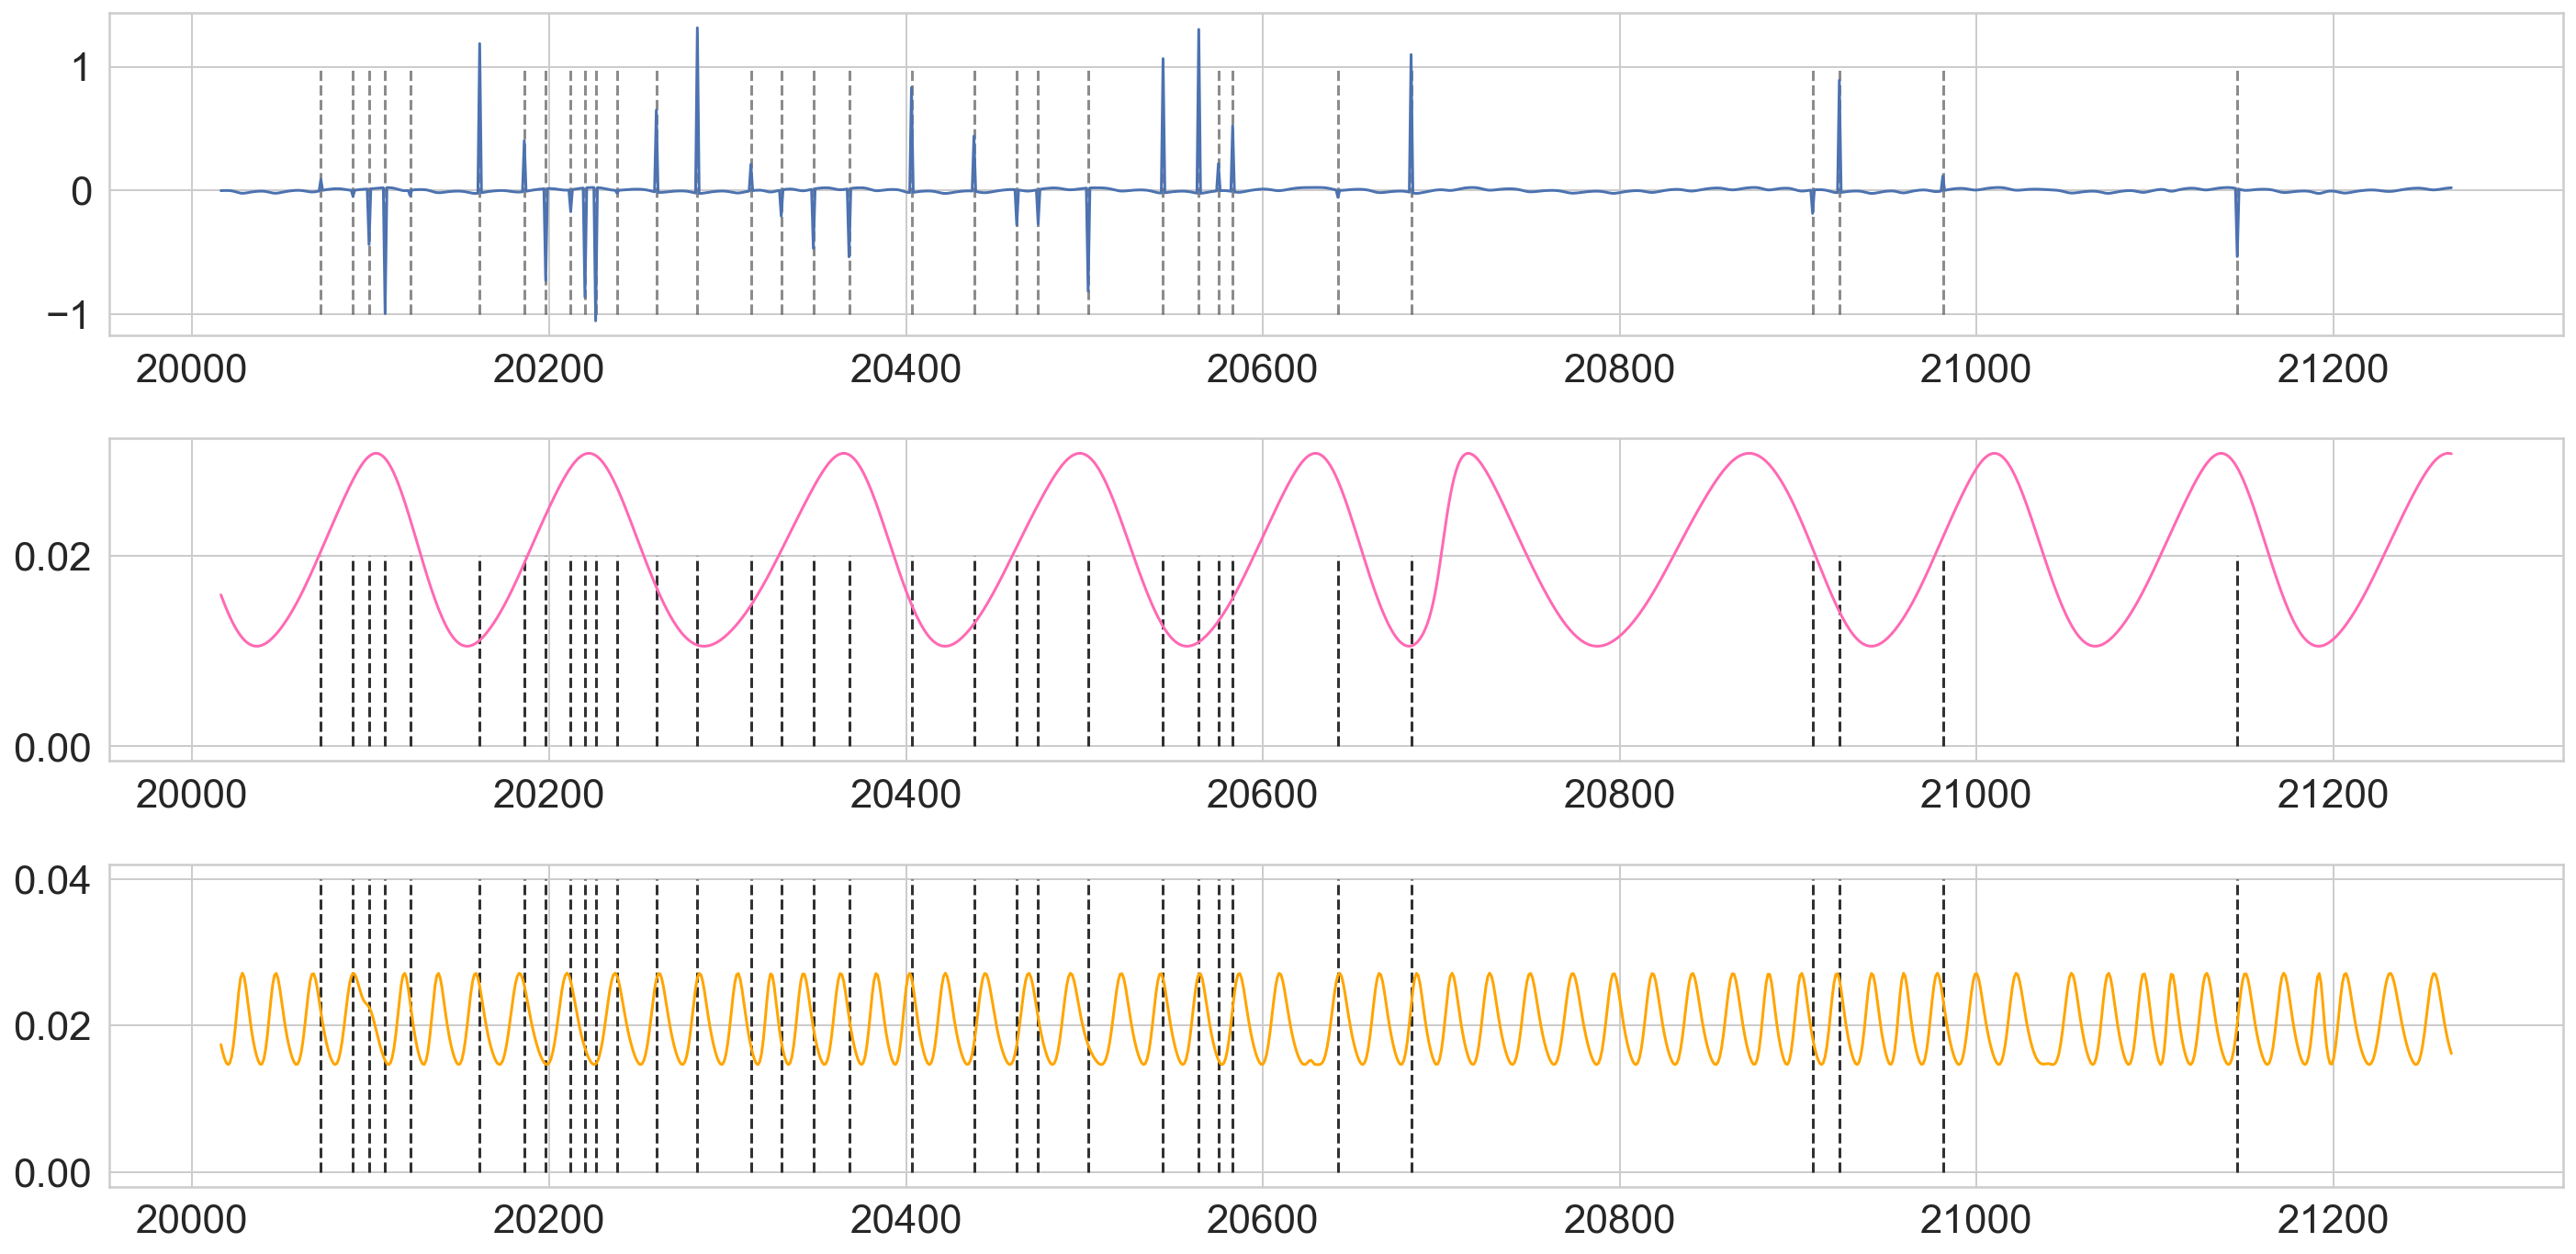

In [169]:
fig, ax = plt.subplots(3,1,figsize=(20,10))
time = subtheta_test.index
spikes_ts = subtheta_test[subtheta_test['spikes'] == 1].index

ax[0].plot(time, np.subtract(logloss_theta, logloss_lowgamma))

ax[0].vlines(x = spikes_ts, 
             ymax = 1, 
             ymin = -1,color='k',alpha=0.5, linestyle='--')

ax[1].plot(time, subtheta_ptest['p_phase'],color='hotpink')
ax[1].vlines(x = spikes_ts, 
             ymax = 0.02, 
             ymin = 0,color='k',alpha=0.9, linestyle='--')

ax[2].plot(time, sublowgamma_ptest['p_phase'],color='orange')

ax[2].vlines(x = spikes_ts, 
             ymax = 0.04, 
             ymin = 0,color='k',alpha=0.9, linestyle='--')

fig.tight_layout()